# <font color='green'>Machine Learning techniques in claim by claim Reserving</font>

## 01 - Problem 

Insurance companies face a reversed business cycle as they receive money before in promise for a service to be delivered in the future. Moreover, the amount in monetary terms of service to be paid or even the chance of offering it is uncertain. This is the reason why, in order to protect policyholders, it is one of the role of the actuary to predict the future amounts of service to be paid in order for the company to account for those future losses.<br>
Moreover, those future amounts are set as provisions by the insurer and can be invested in the market. It is therefore useful for the insurer to know what amount can be invested and when 
Many claims reserving techniques are used in the sector with all the same purpose : Getting more accuracy on the prediction of future costs. <br>
The quasi totality of those claims reserving methods are based on aggregate data of one particular Line of Business and don't take advantage of granular information that insurance get on claims (policy contrats information, cause of accident, salary of claimants, deductibles, medical experts insight, qualitative claims handler insight and so on). <br>
<br>
I would like in this project to test if we can use information at a more granular level using ML techniques and to compare it with the most populalar reserving techniques used in the sector.  

## 02 - Data

#### Source and context

Working as a Non Life Actuary at Vaudoise Assurances, we have plenty of available data relative to claims. Unfortunately, at the time questions relative to data privacy are more and more frequent, the company was reluctant to give access to part of its data to the EPFL Extension School as part of this project.

Fortunately, academic researchers in the field of reserving, developped a stochastic simulation machine based on Neural Network to generate synthetic non-life insurance claims to support the development of individual claim reserving. 
This simulation machine is based on anonymised 10 year history claims data from SUVA which is the largest compulsory accident (and professional illness) insurer in Switzerland with more than 2Mio people insured in the country. The way the simulation claims portfolio works is that these individual claims histories should depend on individual claims feature information such as the line of business concerned, the claims code involved or the age of the injured. This feature information should influence the reporting delay of the individual claim, the claim amount paid, its individual cash flow pattern as well as its settlement delay. The resulting (simulated) individual claims histories is compared to the real ones of SUVA in the paper and looks very similar. 

Can find more information in the paper below : [An Individual Claims History Simulation Machine](https://www.mdpi.com/2227-9091/6/2/29/htm)

####  Accident Insurance - Overview

Accident Insurance is compulsory in Switerland and each company having business in Switzerland must ensure that each of its workers are insured. Each workers are insured against **professional**, **non-professional** accidents as well as **professional** illness resulting from their work. The majority of the working sectors are insured by SUVA and some sectors which are less prone to professional accident (banking sector, health sector, tourism sector,..) are insured by private insurers. The compulsory accident insurance (LAA) is well regulated and covers medical costs, invalidity and survival annuities as well as salary indemnity loss relative to an accident.    

**Complementary Accident Insurance** is another Line of Business which is this time not compulsory and covers additional costs (medical cost in specialised hospital, private room in case of hospitalisation,..), loss of salary which excess the Annual Salary of 148'000 CHF, capital amounts to be cashed in at once (contrary to annuties) in case of Invalidity or death of the insured. The independant workers or workers working less than a certain amount of hours each week (home cleaners for example) are not subject to compulsory accident insurance but can still choose to take this insurance individually. This type of insurance refers to another Line of Business which is called **Individual Accident Insurance** in the insurance industry. 

As we will see when looking at the data from SUVA, they have 4 Line of Business (LoB) called (LoB1, LoB2,..) which might well correspond to the 4 Accident Line of Business known in the private sector.

#### Database - Overview 

The database contains 500000 claims history which have happened between 1994 and 2005 with their full history payment during 11 years. <br> Hence, claims that happened in 2005 are observed until end of year 2016.

In [1]:
import pandas as pd

data = pd.read_csv('Simulated.Cashflow.txt', sep=';',thousands=",")
data.head()

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,...,Open02,Open03,Open04,Open05,Open06,Open07,Open08,Open09,Open10,Open11
0,1.0,2,49,1994,2,32,71,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2,46,1994,2,15,34,0,651,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,3,50,1994,1,39,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,41,1994,3,36,33,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.0,3,20,1994,1,59,53,0,4455,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
print('Size of full database : ', data.shape)

Size of full database :  (500926, 32)


**Features Description :**

> - The claims number *ClNr*, which serves as a distinct claims identifier<br>
<br>
- The line of business *LoB*, which is categorical with labels in {1,…,4}<br>
<br>
- The claims code *cc*, which is categorical with labels in {1,…,53} and denotes the labor sector of the injured <br>
<br>
- The accident year *AY*, which is in {1994,…,2005} and denotes the year in which the accident happened <br>
<br>
- The accident quarter *AQ*, which is in {1,…,4} and denotes the quarter in which the accident happened <br>
<br>
- The age of the injured *age*, which is in {15,..,70} <br>
<br>
- The injured part *inj_part*, which is categorical with labels in {10,…,99} and denotes the part of the body injured<br>
<br>
- The reporting Delay *RepDel*, which is in {0,…,11} and is computed as the *reporting year - accident year*
<br>

Notes : <br> 
The injured part in reality only contains 46 distinct body parts. <br> We will maybe group some of them relative to their claims severity in order to have a fewer number of features with one-hot encoding. Same reasoning with the claim code.

- The columns *'PayN'* with N in {01,02,..,11} refers to the **incremental** payment in development year N of each individual claims.<br>
<br>
- The columns *'OpenN'* with N in {01,02,..,11} refers to a **indicator variable** which indicates if the claim is Open (1) at the end of development year N or if the claim is closed (0). <br>Note that those features allow for the inclusion of re-opening of claims once already closed at a previous development year.

The individual claims information from the simulated claims history (the one given by SUVA) is quite simple and is the minimal information private insurer collect from individual claims relative to accident insurance.

In [3]:
#List of Paid and Open columns for future use :
import numpy as np
Paid = []
Open=[]
PaidCum=[]
for i in range(0,10):
    Paid.append('Pay0'+str(i))
    Open.append('Open0'+str(i))
    PaidCum.append('PayCum0'+str(i))

PaidCum.append('PayCum10')
PaidCum.append('PayCum11')
Paid.append('Pay10')
Paid.append('Pay11')
Open.append('Open10')
Open.append('Open11')

Create functions which cumulates the incremental and cumulative payment by LoB and AY : 

In [169]:
def full_paid_cum(lob):
    
    return np.cumsum(data[data['LoB']==lob].groupby(['AY']).sum()[Paid],axis=1)  

#'{0:,.0f}'.format(full) 

In [170]:
def full_paid_incr(lob):
    
    return data[data['LoB']==lob].groupby(['AY']).sum()[Paid]  

#'{0:,.0f}'.format(full) 

### Formulation of the problem : 

Here you see the cumulative Paid Loss of the Simulated Data for a certain LoB : 

In [171]:
full_paid_cum(lob=1)

,Pay00,Pay01,Pay02,Pay03,Pay04,Pay05,Pay06,Pay07,Pay08,Pay09,Pay10,Pay11
AY,,,,,,,,,,,,
1994,4886132,7363679,8139833,8594268,8880164,9089846,9267965,9410000,9524710,9607299,9689604,9765715
1995,4612842,7108985,7968217,8454491,8788048,9048899,9241558,9391097,9502705,9619445,9704762,9760077
1996,5088984,7850518,8921835,9566172,10015298,10342237,10590655,10786866,10954558,11099733,11235976,11352483
1997,4831571,7298087,8242308,8768668,9118656,9352272,9516797,9641454,9732478,9809598,9899030,9953927
1998,4893652,7495450,8427767,8952398,9265981,9486539,9621089,9751792,9839832,9895818,9958000,10002360
1999,5341277,8418726,9704000,10417418,10891363,11235692,11489030,11730775,11938817,12097821,12250460,12379955
2000,5310480,8221715,9219734,9777379,10166320,10450394,10663234,10825250,10955156,11054213,11139809,11216494
2001,5571165,8736946,9909599,10604152,11090472,11427552,11642177,11830205,11958886,12068963,12137737,12212500
2002,5571019,8812714,9975282,10681783,11144230,11469776,11730473,11911215,12042170,12138584,12231427,12290119


In [172]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_CumPaid_full(lob):
    upper_1 = full_paid_cum(lob)
    upper_1.columns = [np.arange(0,12,1)]
    upper_2 = upper_1.unstack().reset_index()
    upper_2.columns=['Development Period', 'Accident Year', 'Cumulative Paid Loss']


    plt.figure(figsize=(20,10))
    sns.set_style('whitegrid')
    plt.title('Cumulative Payment Development by AY: LoB '+str(lob),size=20)
    g = sns.pointplot(x='Development Period', y='Cumulative Paid Loss',
                  hue='Accident Year', data=upper_2)
    plt.show()

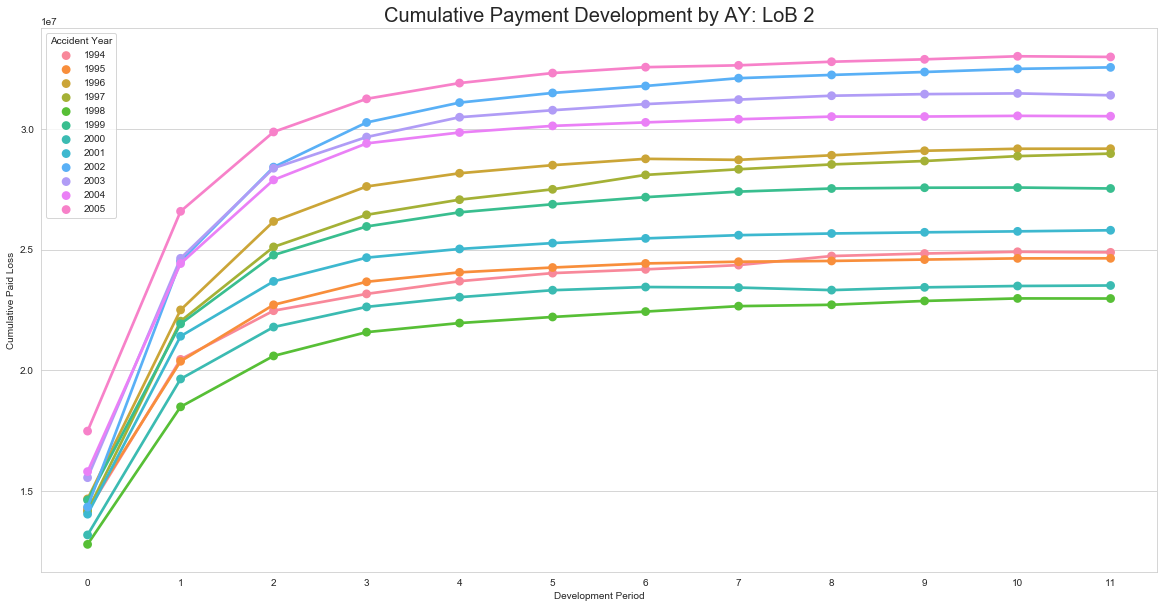

In [173]:
plot_CumPaid_full(lob=2)

We can see that the Total Amount Paid is in most cases increasing with the accident year. It is a common pattern we see and can be explained by either the positive inflation (particularly in health cost in accident insurance) or an increasing business volumes in terms of premium and thus of people insured. We will check that hypothesis later with the number of claims by AY. <br>
<br> All LoB are relatively long term as we see that the payment is increasing each year. It makes sense if it related to accident insurance which contains annuities for invalidity and death until retirement. <br>
for LoB3, we see a highly increasing payment in the first 4 years of accident year 2005 which resorbs after that to come back the total amount of the previous AY (2004).
<br>LoB2 seems to be more short-tailed than the other ones as total amount paid is almost already complete after 5 years of development

In the real world, we do not have the full development of claims for each accident year in a particular LoB. 
The actuary group the data payment data by AY and development year in order to see the infer from the previous development of older accident years, the future development for more recent accident years. The data is "triangulared". 
<br>At the end of year 2005, we only have this information at our disposal : 

In [174]:
def upper_paid_cum(lob):
    full_triangle = full_paid_cum(lob)
    for i,j in enumerate(full_triangle.index,0):
        full_triangle.loc[full_triangle.index > j, Paid[-1-i]] =''
    return full_triangle

In [175]:
def upper_paid_incr(lob):
    full_triangle = full_paid_incr(lob)
    for i,j in enumerate(full_triangle.index,0):
        full_triangle.loc[full_triangle.index > j, Paid[-1-i]] =''
    return full_triangle

In [176]:
upper_paid_cum(lob=1)

,Pay00,Pay01,Pay02,Pay03,Pay04,Pay05,Pay06,Pay07,Pay08,Pay09,Pay10,Pay11
AY,,,,,,,,,,,,
1994,4886132,7363679,8139833,8594268,8880164,9089846,9267965,9410000,9524710,9607299,9689604,9765715
1995,4612842,7108985,7968217,8454491,8788048,9048899,9241558,9391097,9502705,9619445,9704762,
1996,5088984,7850518,8921835,9566172,10015298,10342237,10590655,10786866,10954558,11099733,,
1997,4831571,7298087,8242308,8768668,9118656,9352272,9516797,9641454,9732478,,,
1998,4893652,7495450,8427767,8952398,9265981,9486539,9621089,9751792,,,,
1999,5341277,8418726,9704000,10417418,10891363,11235692,11489030,,,,,
2000,5310480,8221715,9219734,9777379,10166320,10450394,,,,,,
2001,5571165,8736946,9909599,10604152,11090472,,,,,,,
2002,5571019,8812714,9975282,10681783,,,,,,,,


Plot the cumulative payment by AY and development year seen at the end of year 2005 :

In [177]:
def plot_CumPaid_upper(lob):
    upper_1 = upper_paid_cum(lob)
    upper_1.columns = [np.arange(0,12,1)]
    upper_2 = upper_1.unstack().reset_index()
    upper_2.columns=['Development Period', 'Accident Year', 'Cumulative Paid Loss']
    upper_2 = upper_2[upper_2['Cumulative Paid Loss']!='']

    plt.figure(figsize=(20,10))
    sns.set_style('whitegrid')
    plt.title('Cumulative Payment Development by AY: LoB '+str(lob),size=20)
    g = sns.pointplot(x='Development Period', y='Cumulative Paid Loss',
                  hue='Accident Year', data=upper_2)
    plt.show()

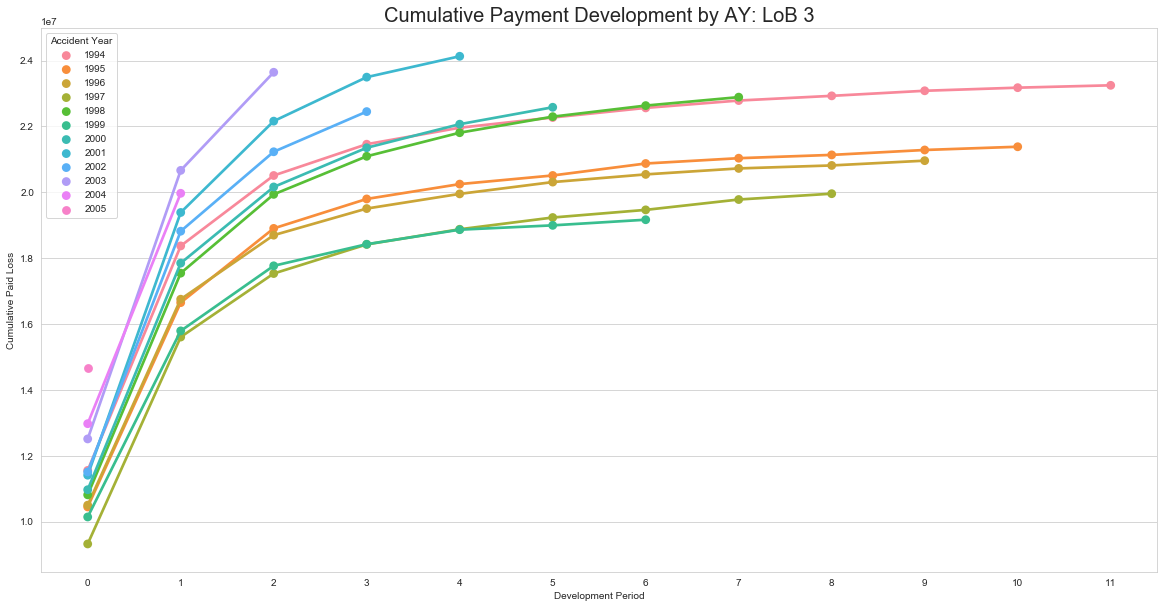

In [13]:
plot_CumPaid_upper(lob=3)

The goal of the reserving Actuary is then to estimate the true value of the total amount which will be paid. This will be referred to as the **Ultimate cost**. The amount the insurance company has to put aside in order to ensure the future payments of claims is the difference between the Ultimate cost and the Observed Payment. It will be referred to as **the IBNR (Incurred but not yet reported) Reserves**

The advantage of having those simulated data with full history of each claim is that we know the true IBNR Reserves for each Line of Business and we will have a benchmark to evaluate the estimated IBNR we will find with Machine Learning techniques.

During this project, we will evaluate the accuracy of our predictions with respect to the real value of claims (true IBNR reserves) but also with the most common technique of reserving used by insurance companies called Chain Ladder. This very intuitive method has been used for decades in the field of reserving due to its low complexity and relative efficienty. We will therefore try to assess if a claim-by-claim prediction using Machine Learning which leverages information relative to individual claims (cc, inj_part, age...) can outperform and be used as a complement to traditional reserving technique. 

### True IBNR computation

Computes last cumulative payment after 11 years of development per LoB and AY : 

In [178]:
Last_Paid_obs = np.zeros((12,4))
for i in range(1,5):
    Last_Paid_obs[:,i-1] = full_paid_cum(lob=i).iloc[:,-1]
Last_Paid_obs_df = pd.DataFrame(Last_Paid_obs,columns=['LoB1','LoB2','LoB3','LoB4'], index=np.unique(data['AY']))

print('Last Cumulative Payment after 11 years of development : ')
Last_Paid_obs_df.style.format("{:,.0f}")

Last Cumulative Payment after 11 years of development : 


,LoB1,LoB2,LoB3,LoB4
1994,"9,765,715","24,893,064","23,249,543","14,415,216"
1995,"9,760,077","24,645,705","21,432,555","15,307,579"
1996,"11,352,483","29,188,351","21,151,877","15,891,374"
1997,"9,953,927","28,984,507","20,249,445","18,549,875"
1998,"10,002,360","22,980,417","23,687,758","17,644,097"
1999,"12,379,955","27,539,158","19,293,528","17,759,371"
2000,"11,216,494","23,520,222","23,795,048","16,371,584"
2001,"12,212,500","25,807,955","25,493,849","17,986,026"
2002,"12,290,119","32,556,812","24,136,152","20,088,414"
2003,"14,027,976","31,400,893","26,815,221","23,196,432"


Compute last known cumulative payment at end of year 2005 per LoB and AY :

In [179]:
Paid_obs_2005 = np.zeros((12,4))
for i in range(1,5):
    Paid_obs_2005[:,i-1] = np.sum(upper_paid_incr(i).replace('',0),axis=1)
Paid_obs_2005_df = pd.DataFrame(Paid_obs_2005,columns=['LoB1','LoB2','LoB3','LoB4'], index=np.unique(data['AY']))

print('Last Known Cumulative Payment at end of year 2005 : ')
Paid_obs_2005_df.style.format("{:,.0f}")

Last Known Cumulative Payment at end of year 2005 : 


,LoB1,LoB2,LoB3,LoB4
1994,"9,765,715","24,893,064","23,249,543","14,415,216"
1995,"9,704,762","24,643,462","21,385,351","15,182,056"
1996,"11,099,733","29,102,005","20,963,099","15,594,053"
1997,"9,732,478","28,535,601","19,960,901","17,692,898"
1998,"9,751,792","22,664,873","22,890,651","16,674,736"
1999,"11,489,030","27,179,099","19,171,038","16,792,900"
2000,"10,450,394","23,325,256","22,583,442","14,962,612"
2001,"11,090,472","25,034,037","24,131,019","16,199,653"
2002,"10,681,783","30,273,587","22,452,112","16,841,048"
2003,"11,455,483","28,378,599","23,645,140","17,503,627"


Computes **true** Reserves (IBNR) that the actuary should have computed which is the difference of the last two dataframes :

In [180]:
print ("True IBNR Reserve by LoB and AY :")
IBNR_True_Reserves= Last_Paid_obs_df-Paid_obs_2005_df
IBNR_True_Reserves.loc['Total']= IBNR_True_Reserves.sum()
IBNR_True_Reserves.style.format("{:,.0f}")

True IBNR Reserve by LoB and AY :


,LoB1,LoB2,LoB3,LoB4
1994,0,0,0,0
1995,"55,315","2,243","47,204","125,523"
1996,"252,750","86,346","188,778","297,321"
1997,"221,449","448,906","288,544","856,977"
1998,"250,568","315,544","797,107","969,361"
1999,"890,925","360,059","122,490","966,471"
2000,"766,100","194,966","1,211,606","1,408,972"
2001,"1,122,028","773,918","1,362,830","1,786,373"
2002,"1,608,336","2,283,225","1,684,040","3,247,366"
2003,"2,572,493","3,022,294","3,170,081","5,692,805"


We see that the total unpaid Amounts of LoB 4 and 2 are higher than the other ones eventhough the percentage is relatively uniformly distributed between the Line of Business. The older the Accident Year, the lower the unpaid amount as those years are already well developed.

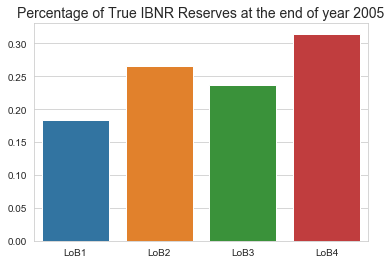

In [17]:
plt.title('Percentage of True IBNR Reserves at the end of year 2005',size=14)
sns.barplot(x=['LoB1','LoB2','LoB3','LoB4'],y=IBNR_True_Reserves.sum()/IBNR_True_Reserves.sum().sum())
plt.show()

### Estimated IBNR - Traditional Technique (Chain Ladder)

The Chain Ladder method consists of estimating development factors based on the average historical development :

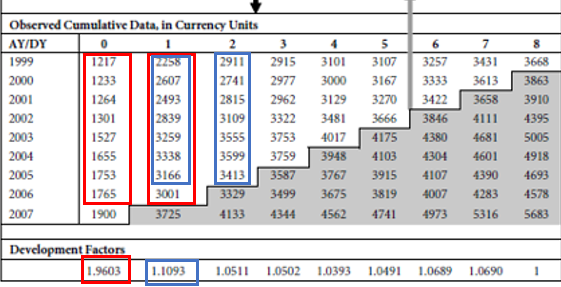

In [18]:
from IPython.display import Image

Image('CL_Estimation_v1.png')

Computation of development factors by LoB : 

In [181]:
dev_factor = np.zeros((11,4))
#For each Line of Business :
for j in range (0,4):
    #For each development period
    for i in range(11):
        dev_factor[i,j] = upper_paid_cum(lob=j+1).iloc[:11-i,1+i].sum() / upper_paid_cum(lob=j+1).iloc[:11-i,i].sum()

In [182]:
dev_factor = np.vstack((dev_factor, [1,1,1,1]))

print ("Development factor by LoB and development year :")
dev_factor_df = pd.DataFrame(dev_factor,columns=['LoB1','LoB2','LoB3','LoB4'], index=np.arange(0,12,1))
dev_factor_df.style.format("{:,.3f}")

Development factor by LoB and development year :


,LoB1,LoB2,LoB3,LoB4
0,1.553,1.525,1.615,1.681
1,1.130,1.130,1.130,1.165
2,1.066,1.048,1.051,1.082
3,1.041,1.020,1.027,1.051
4,1.028,1.012,1.017,1.035
5,1.020,1.011,1.013,1.027
6,1.015,1.005,1.011,1.021
7,1.012,1.008,1.006,1.016
8,1.011,1.004,1.007,1.011
9,1.009,1.002,1.004,1.009


We see that claims from LoB 3 and 4 have on average a larger increase in payment at the end of the first development year. The last development factor for LoB 2 is negative due to payment retrocession.
<br> Line of Business 4 is the most **heavy tailed** as we see that the increase in claims payment is the largest over all development period.

Prediction of Ultimate Cost by AY and LoB : (Last observation of Paid Claims by AY and LoB multiplied by the respective cumulative development factors : 

In [21]:
dev_cum = np.cumprod(np.flip(dev_factor,axis=0),axis=0)

In [22]:
Ultimate = dev_cum * Paid_obs_2005 

# Assuming that dataframes df1 and df2 are already defined:
print ("Ultimates by LoB and AY :")
Ultimates = pd.DataFrame(Ultimate,columns=['LoB1','LoB2','LoB3','LoB4'], index=np.unique(data['AY']))
Ultimates.style.format("{:,.0f}")

Ultimates by LoB and AY :


,LoB1,LoB2,LoB3,LoB4
1994,"9,765,715","24,893,064","23,249,543","14,415,216"
1995,"9,780,992","24,619,997","21,451,306","15,274,891"
1996,"11,284,450","29,145,431","21,118,840","15,832,871"
1997,"10,008,132","28,705,836","20,248,103","18,164,342"
1998,"10,151,980","22,971,566","23,360,280","17,395,408"
1999,"12,144,771","27,689,928","19,773,980","17,892,158"
2000,"11,267,885","24,027,178","23,600,112","16,375,679"
2001,"12,292,953","26,108,580","25,641,290","18,354,246"
2002,"12,325,519","32,188,729","24,493,673","20,055,044"
2003,"14,089,796","31,609,406","27,119,986","22,547,562"


In [23]:
IBNR_CL_Reserves = Ultimates - Paid_obs_2005_df

print ("Predicted IBNR Reserve by LoB and AY :")
IBNR_CL_Reserves = pd.DataFrame(IBNR_CL_Reserves,columns=['LoB1','LoB2','LoB3','LoB4'], index=np.unique(data['AY']))
IBNR_CL_Reserves.loc['Total']= IBNR_CL_Reserves.sum()

#IBNR_CL_Reserves.style.applymap('font-weight: bold',
#        subset=pd.IndexSlice[IBNR_CL_Reserves.index[IBNR_CL_Reserves.index=='Total'], :])
IBNR_CL_Reserves.style.format("{:,.0f}")

Predicted IBNR Reserve by LoB and AY :


,LoB1,LoB2,LoB3,LoB4
1994,0,0,0,0
1995,"76,230","-23,465","65,955","92,835"
1996,"184,717","43,426","155,741","238,818"
1997,"275,654","170,235","287,202","471,444"
1998,"400,188","306,693","469,629","720,672"
1999,"655,741","510,829","602,942","1,099,258"
2000,"817,491","701,922","1,016,670","1,413,067"
2001,"1,202,481","1,074,543","1,510,271","2,154,593"
2002,"1,643,736","1,915,142","2,041,561","3,213,996"
2003,"2,634,313","3,230,807","3,474,846","5,043,935"


We see that a large part of the estimated total Reserve to be put aside by the insurer comes from LoB3 and LoB4 with 31Mio and 34Mio. The more developped the accident year is , the less the amount of IBNR Reserves for that year.

Plot estimated percentage of IBNR by LoB :

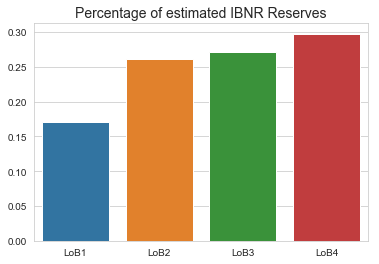

In [24]:
plt.title('Percentage of estimated IBNR Reserves',size=14)
sns.barplot(x=['LoB1','LoB2','LoB3','LoB4'],y=IBNR_CL_Reserves.sum()/IBNR_CL_Reserves.sum().sum())
plt.show()

We can see from the two plots of the true and the predicted IBNR, that IBNR of LoB 3 is overestimated.

Plot Errors between True versus Predicted IBNR by LoB :

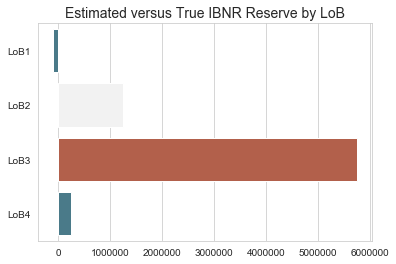

In [25]:
plt.title('Estimated versus True IBNR Reserve by LoB',size=14)
sns.barplot(y=['LoB1','LoB2','LoB3','LoB4'],x=np.sum(IBNR_CL_Reserves[0:12],axis=0) - np.sum(IBNR_True_Reserves[0:12],axis=0),orient='h',palette=sns.diverging_palette(220, 20, n=3))
plt.show()

We observe that our simple prediction of Claims amounts overestimates the true values, particularly for LoB3 which had a very large first amount of Cumulative payment for AY 2005. The prediction for LoB 1 underestimates the true value.

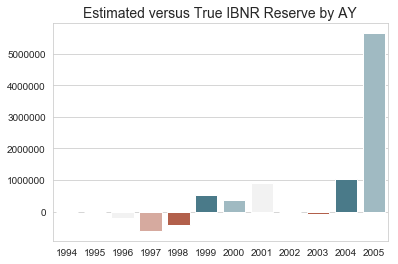

In [26]:
plt.title('Estimated versus True IBNR Reserve by AY',size=14)
sns.barplot(x=np.unique(data['AY']),y=np.sum(IBNR_CL_Reserves[0:12],axis=1) - np.sum(IBNR_True_Reserves[0:12],axis=1),orient='v',palette=sns.diverging_palette(220, 20, n=5))
plt.show()

This plot confirms that the Chain Ladder predictions is very sensitive to the claims amounts of the first developed year. For LoB3, we paid a lot in the first year for AY 2005 and thus the estimation largely overestimates the true value. It would have been the contrary for example if we had a small paid amounts in the first year due to delay of claims handling.

The results found here will be a good benchmark to evaluate the performance of claims predictions with Machine Learning.

## EDA - Explanatory Data Analysis

In [27]:
data.describe().iloc[:,8:20]

,Pay00,Pay01,Pay02,Pay03,Pay04,Pay05,Pay06,Pay07,Pay08,Pay09,Pay10,Pay11
count,500926.000000,5.009260e+05,500926.000000,500926.000000,500926.000000,500926.000000,500926.000000,500926.000000,500926.000000,500926.000000,500926.000000,500926.000000
mean,928.156772,5.403882e+02,199.919437,97.434182,54.781343,36.463288,27.620509,20.148501,15.714896,13.049888,10.908464,6.771587
std,5231.774941,6.564895e+03,3636.274494,1969.848693,1313.802038,989.299700,857.940803,696.793403,683.689016,528.353183,451.231531,487.885726
min,0.000000,-3.664100e+04,-59517.000000,-71016.000000,-81510.000000,-71553.000000,-62280.000000,-86736.000000,-134091.000000,-76529.000000,-61965.000000,-94610.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,145.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,629.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,670281.000000,1.860207e+06,845717.000000,451290.000000,313066.000000,240469.000000,219461.000000,173143.000000,136301.000000,138616.000000,120080.000000,104940.000000


In [28]:
print('Number of Null Value to remplace : ',data.isnull().sum().sum())

Number of Null Value to remplace :  0


This synthetic dataset doest not require any data cleaning

Compute the number of claims by LoB with a distinction on claims which resulted in a payment for the insurer or not :

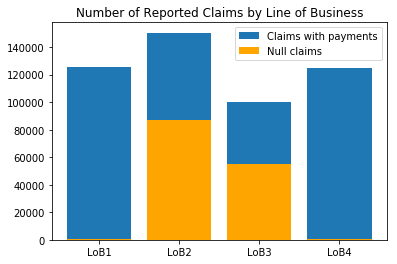

In [18]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
LoB = []
for i in range(0,4) :
    LoB.append('LoB'+str(i+1))


plt.bar(LoB, data.groupby('LoB')['ClNr'].count(),label='Claims with payments')
plt.bar(LoB,data[np.sum(data[Paid],axis=1)==0].groupby('LoB')['ClNr'].count(),color='orange',label='Null claims')
plt.legend(loc='best')
plt.title('Number of Reported Claims by Line of Business')
plt.show()

Lob 3 is the line of Business with the most reported claims eventhough a large part of its claims does not end up in a cash-out for the insurance. Line 1 and 4 have around 800 claims without payments which represents a very small proportion of the total number of reported claims. 

In [30]:
print('Proportion of claims witout payments ', data[np.sum(data[Paid],axis=1)==0]['ClNr'].count() / data['ClNr'].count())

Proportion of claims witout payments  0.28700247142292473


In [31]:
from ipywidgets import interact, interactive, interact_manual, fixed
import ipywidgets as widgets
import seaborn as sns

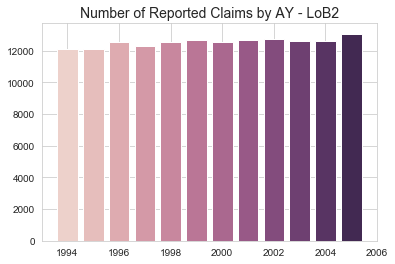

In [32]:
def f(LoB):
   
    plt.bar(data[data['LoB']==LoB]['AY'].unique(), data[data['LoB']==LoB].groupby('AY')['ClNr'].count(),
            color=sns.cubehelix_palette(13))
    plt.title('Number of Reported Claims by AY - LoB'+str(LoB),size=14)
    plt.show()
interact(f,LoB=(1,4,1))
plt.show()

We can see that the number of claims is increasing with the accident year for most of LoB.

Plot a Treemap of the activity sector of the insured :

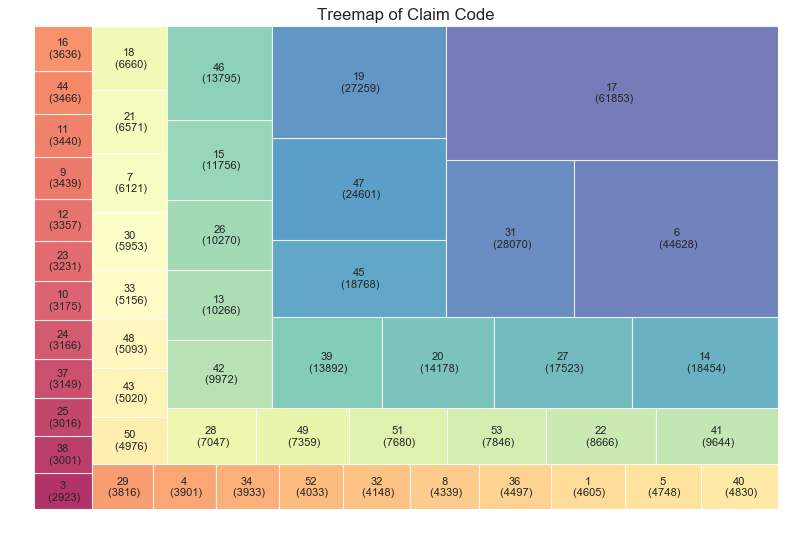

In [33]:
import squarify 


# Prepare Data
df = data.groupby(['cc'])['ClNr'].count().reset_index(name='counts').sort_values(by=['counts'])
labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Treemap of Claim Code',size=15)
plt.axis('off')
plt.show()

We see that the distribution of the number of claims by claim code (represents the activity sector of the claimants) is quite "disparate". We have 15 claims code which have less than 4000 observations. Eventhough 2800 observations is still a good amount of data for our ML algorithm to learn from data, we will investigate the grouping of claims code later dependending on the average cost of those less represented groups. 2 claims code are very well represented with more than 40K observations.

Plot a Treemap of the the part of the body which is insured :

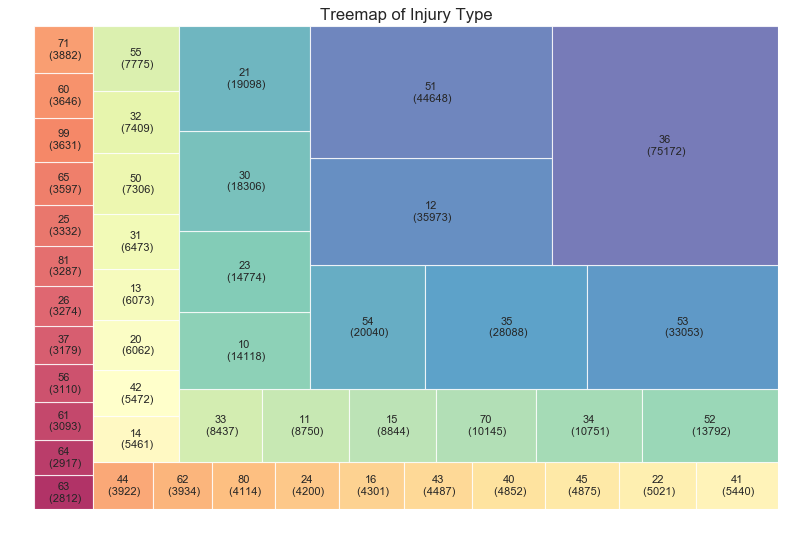

In [34]:
# Prepare Data
df = data.groupby(['inj_part'])['ClNr'].count().reset_index(name='counts').sort_values(by=['counts'])
labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Treemap of Injury Type',size=15)
plt.axis('off')
plt.show()

We see that we also have at least 3000 observations by Injury Type. The distribution of the number of claims by injury type looks alike with the one by claim code. 
We will also investigate later the possibility of claims injury grouping eventhough it might be the case that **rare injury** have a **atypical claims development** which should be kept like it is in our ML algorithms. 

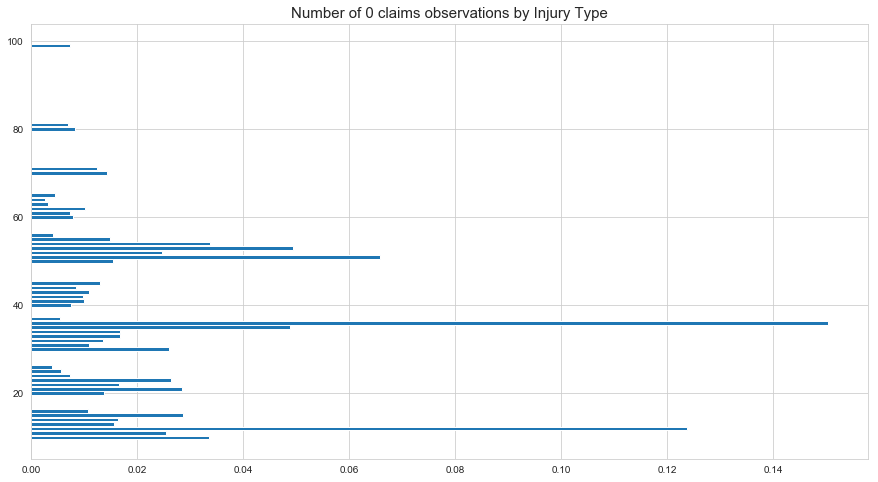

In [35]:
plt.figure(figsize=(15,8))
plt.title('Number of 0 claims observations by Injury Type',size=15)
data_0 = data[np.sum(data[Paid],axis=1)==0]
Paid_0_inj = pd.DataFrame(data_0.groupby(['inj_part'])['ClNr'].count()/data_0['ClNr'].count()).sort_values(by='ClNr',ascending=False)
plt.barh(Paid_0_inj.index,Paid_0_inj['ClNr'])
plt.show()

We observe that 25% of claims with no payments comes from injury label 36 and 12 which is a good thing as our ML algorithm should identify them.

In [36]:
from matplotlib import cm
#from colorspacious import cspace_converter
from collections import OrderedDict

cmaps = OrderedDict()

Plot the number of claims by reporting year per LoB as well as the cumulative total payment by Reporting Delay :

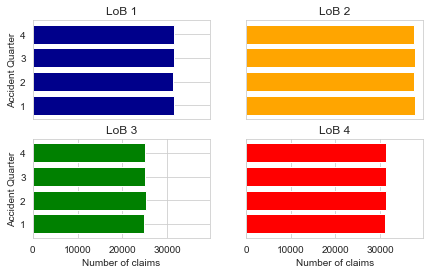

In [37]:
fig, axes = plt.subplots(2, 2,figsize=(7,4),sharex=True)


axes[0,0].barh(np.unique(data[data['LoB']==1]['AQ']),data[data['LoB']==1].groupby('AQ')['ClNr'].count(),color='darkblue')
axes[0,1].barh(np.unique(data[data['LoB']==2]['AQ']),data[data['LoB']==2].groupby('AQ')['ClNr'].count(),color='orange')
axes[1,0].barh(np.unique(data[data['LoB']==3]['AQ']),data[data['LoB']==3].groupby('AQ')['ClNr'].count(),color='green')
axes[1,1].barh(np.unique(data[data['LoB']==4]['AQ']),data[data['LoB']==4].groupby('AQ')['ClNr'].count(),color='red')

for i,ax in enumerate(axes.flat,0):
    ax.set(xlabel='Number of claims', ylabel='Accident Quarter')
    ax.set(title='LoB '+str(i+1))
    ax.set(yticks=(1,2,3,4))
    
axes[0,0].get_xaxis().set_visible(False)
axes[0,1].get_xaxis().set_visible(False)
axes[0,1].get_yaxis().set_visible(False)
axes[1,1].get_yaxis().set_visible(False)

plt.show()

The number of claims reported per quarter is uniformly distritued accross all lines so we do not have any seasonality effect on the number of claims.

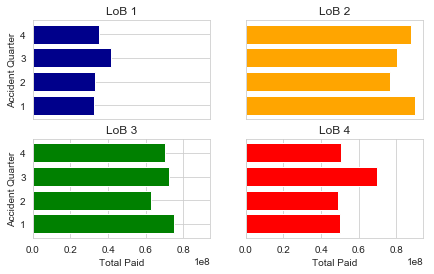

In [38]:
fig, axes = plt.subplots(2, 2,figsize=(7,4),sharex=True)


axes[0,0].barh(np.unique(data[data['LoB']==1]['AQ']),np.sum(data[data['LoB']==1].groupby('AQ')[Paid].sum(axis=1),axis=1),color='darkblue')
axes[0,1].barh(np.unique(data[data['LoB']==2]['AQ']),np.sum(data[data['LoB']==2].groupby('AQ')[Paid].sum(axis=1),axis=1),color='orange')
axes[1,0].barh(np.unique(data[data['LoB']==3]['AQ']),np.sum(data[data['LoB']==3].groupby('AQ')[Paid].sum(axis=1),axis=1),color='green')
axes[1,1].barh(np.unique(data[data['LoB']==4]['AQ']),np.sum(data[data['LoB']==4].groupby('AQ')[Paid].sum(axis=1),axis=1),color='red')

for i, ax in enumerate(axes.flat,0):
    ax.set(xlabel='Total Paid', ylabel='Accident Quarter')
    ax.set(title='LoB '+str(i+1))
    ax.set(yticks=(1,2,3,4))
    
axes[0,0].get_xaxis().set_visible(False)
axes[0,1].get_xaxis().set_visible(False)
axes[0,1].get_yaxis().set_visible(False)
axes[1,1].get_yaxis().set_visible(False)

plt.show()

On the conterpart, the total amount paid varies depending on the quarter the claim as occured. Claims occured in the third quarter seem to cost a bit more than others (except for LoB2 where the most expensive claims are in AQ 1 and 4). Claims occuring in the second quarter of the year cost less than others accross all lines.

Plot the mean average total payment with its deviation by activity sector

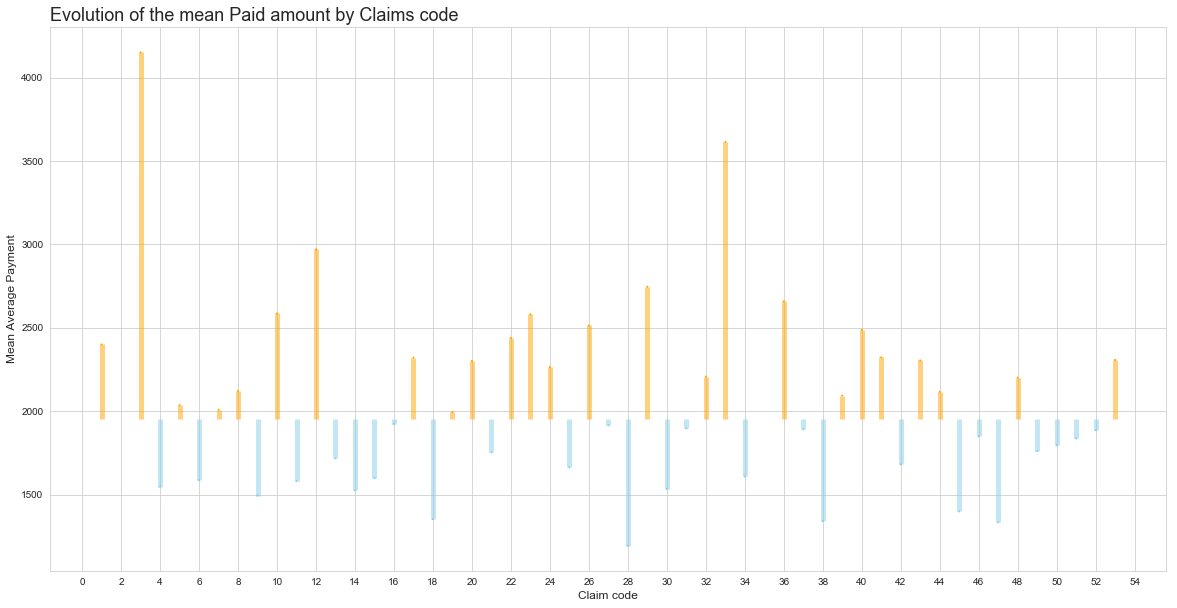

In [39]:
# Data
meanPaid_cc = np.sum(np.sum(data.groupby(['cc'])[Paid],axis=1),1) / data.groupby(['cc'])['ClNr'].count()
x = meanPaid_cc.index
y = meanPaid_cc
plt.figure(figsize=(20,10))

# Create a color if the group is "B"
my_color=np.where(y>=np.mean(np.sum(data[Paid],axis=1)), 'orange', 'skyblue')
 
# The vertival plot is made using the hline function

plt.vlines(x=x, ymin=np.mean(np.sum(data[Paid],axis=1)), ymax=y, color=my_color, alpha=0.5, linewidth=5)
plt.scatter(x, y, color=my_color, s=1, alpha=1)
plt.xticks((np.arange(0,56,2))) 

# Add title and axis names
plt.title("Evolution of the mean Paid amount by Claims code ", loc='left',size=18)
plt.xlabel('Claim code',size=12)
plt.ylabel('Mean Average Payment',size=12)
plt.show()

The average claim size accross all insured is in the region of 2k CHF. However, the average claim size varies significantly accross the activity sector of the insured. The cc in (3,33) have a claim severity which almost doubles compared to the average accross all sectors. 

Plot the mean average total payment with its deviation by injury part :

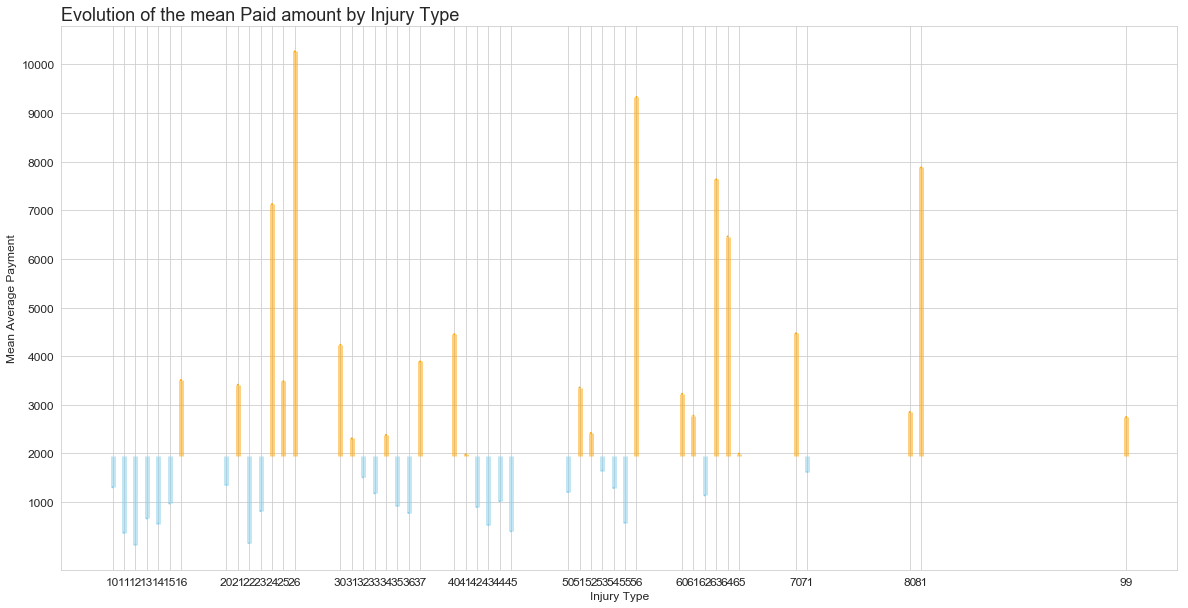

In [40]:
# Data
meanPaid_inj = np.sum(np.sum(data.groupby(['inj_part'])[Paid],axis=1),1) / data.groupby(['inj_part'])['ClNr'].count()
x = meanPaid_inj.index
y = meanPaid_inj
 
plt.figure(figsize=(20,10))
# Create a color if the group is "B"
my_color=np.where(y>=np.mean(np.sum(data[Paid],axis=1)), 'orange', 'skyblue')
 
# The vertival plot is made using the hline function
plt.vlines(x=x, ymin=np.mean(np.sum(data[Paid],axis=1)), ymax=y, color=my_color, alpha=0.5, linewidth=5)
plt.scatter(x, y, color=my_color, s=1, alpha=0.9)
plt.xticks((data['inj_part'].unique()),size=12)
plt.yticks(np.linspace(1000,10000,10),size=12)

# Add title and axis names
plt.title("Evolution of the mean Paid amount by Injury Type", loc='left',size=18)
plt.xlabel('Injury Type',size=12)
plt.ylabel('Mean Average Payment',size=12)
plt.show()

Here the mean claim size by type of injury is even more volatile. We can distinguish 4 type of injury which have cost on average more than 3 times the standard deviation of the average payment. <br> Those injury type are :

In [41]:
meanPaid_inj[meanPaid_inj > 3 * meanPaid_inj.std()]

inj_part
26    10264.420586
56     9328.122830
63     7633.130156
81     7879.069060
dtype: float64

Those injury type have a scare number of observations (around 3000 each). We can see that the injury part is grouped by number of 10. From my experience, we cannot say that insurers group injury part code by severity so I cannot group the inj_part based on the injury code.

Boxplot of Injury type in order to see if certain body part injury are more volatile than others :

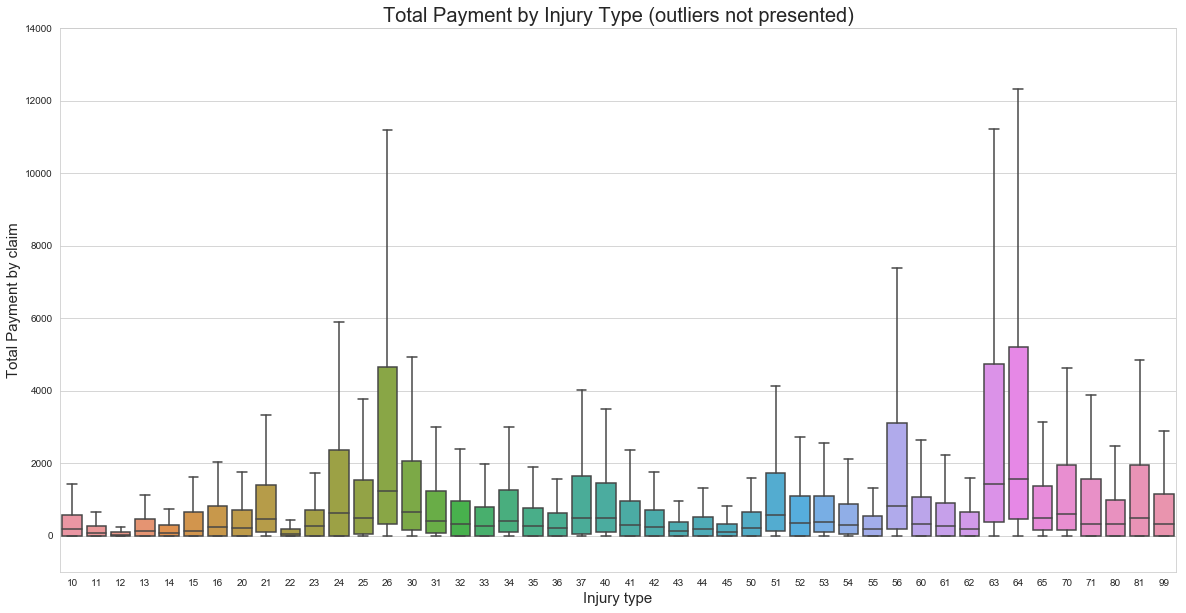

In [42]:
df2 = data
df2['PayCum01'] = data['Pay00']+data['Pay01']

var = 'inj_part'

df = pd.concat([df2[Paid].sum(axis=1), df2[var]], axis=1)

plt.figure(figsize=(20,10))

fig = sns.boxplot(x=var, y=0, data=df, showfliers=False)
plt.title('Total Payment by Injury Type (outliers not presented)',size=20)
axes = plt.gca()
plt.ylabel('Total Payment by claim',size=15)
plt.xlabel('Injury type',size=15)
#axes.set_xlim([-1,12])
fig.axis(ymin=-1e3, ymax=14e3)

plt.show()

In fact injury type 26, 63 and 64 seems to be highly volatile.The volatility of payment seems not to be constant by group of 10 injury part

Boxplot of Activity sector in order to see if certain activity sectors are more volatile than others in terms of payment :

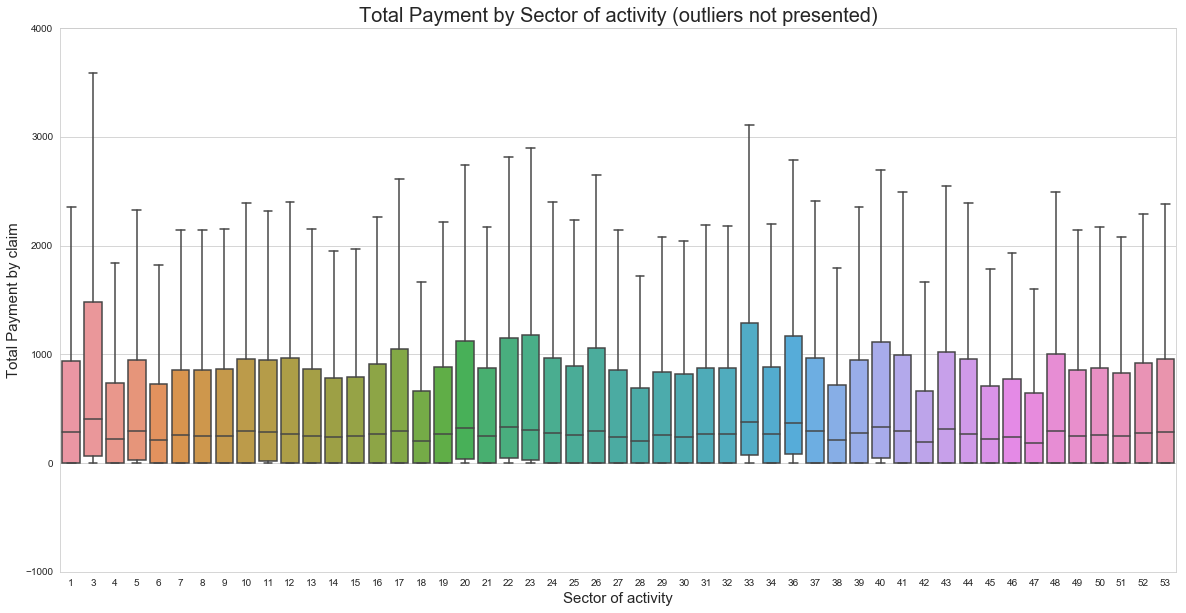

In [43]:
var = 'cc'

df = pd.concat([df2[Paid].sum(axis=1), df2[var]], axis=1)

plt.figure(figsize=(20,10))

fig = sns.boxplot(x=var, y=0, data=df, showfliers=False)
plt.title('Total Payment by Sector of activity (outliers not presented)',size=20)
axes = plt.gca()
plt.ylabel('Total Payment by claim',size=15)
plt.xlabel('Sector of activity',size=15)
#axes.set_xlim([-1,12])
fig.axis(ymin=-1e3, ymax=4e3)

plt.show()

From the two boxplot above, we see that the injury type is much more volatile in the individual claim amount (varying median and interquantile in inj_part feature). The activity sector is more homogeneous is the claims amount.

Let's interest ourself extreme value datapoints (outliers). Are they distributed evenly accross sector of activity or injury type ? <br>
To determine the threshold from which I will consider my total payment as an outlier, I will have a look at the mean excess plot for a certain Line of Business :

In [44]:
def mean_excess_function (LoB,d):
    df3 = df2[df2['LoB']==LoB][Paid].sum(axis=1)
    count = df3[df3 >= d].count()
    excess = df3[df3 >= d].mean() - d
    return count, excess

In [45]:
print('LoB 2 - Given than claims are already higher than 100k CHF : ')
print('The number of claims exceeding the threshold  : ' ,mean_excess_function(2,100e3)[0])
print('The mean amount in excess of threshold : ' ,mean_excess_function(2,100e3)[1])

LoB 2 - Given than claims are already higher than 100k CHF : 
The number of claims exceeding the threshold  :  473
The mean amount in excess of threshold :  183082.96617336152


In [46]:
x = np.linspace(0, 0.8e6, 100)
LoB = [1,2,3,4]
count=np.zeros((len(x),4))
excess=np.zeros((len(x),4))

for lob in LoB :
    for i in range(0,len(x)): 
        count[i,lob-1] = mean_excess_function(lob,x[i])[0]
        excess[i,lob-1]= mean_excess_function(lob,x[i])[1]

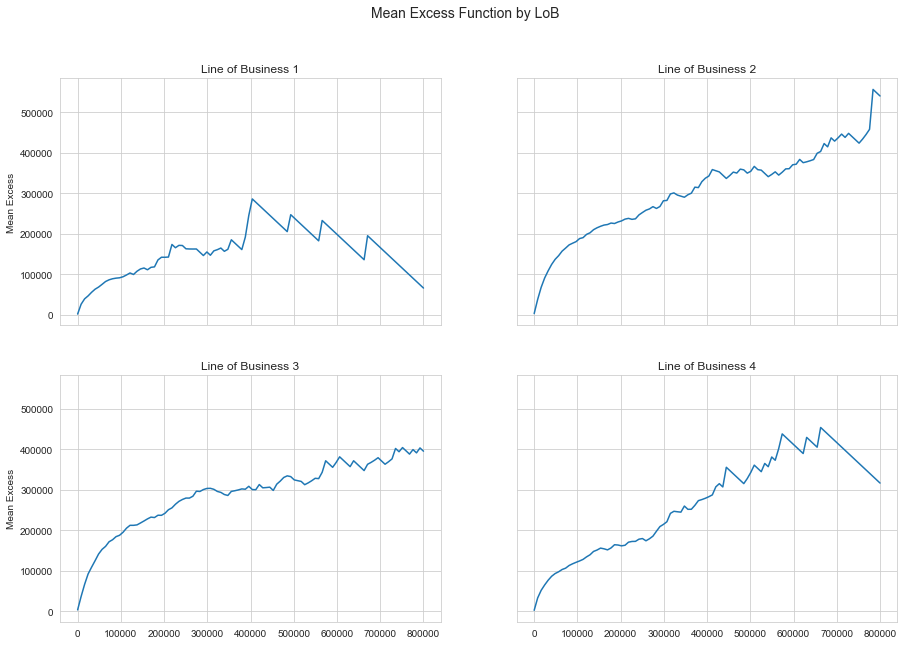

In [47]:
fig,ax = plt.subplots(2,2,figsize=(15, 10),sharex=True,sharey=True)

plt.suptitle('Mean Excess Function by LoB',size=14)
ax[0,0].plot(x,excess[:,0])
ax[0,0].set(title='Line of Business 1')
ax[0,0].set(ylabel='Mean Excess')



ax[0,1].set(title='Line of Business 2')
ax[0,1].plot(x,excess[:,1])

ax[1,0].set(title='Line of Business 3')
ax[1,0].plot(x,excess[:,2])
ax[1,0].set(ylabel='Mean Excess')

ax[1,1].set(title='Line of Business 4')
ax[1,1].plot(x,excess[:,3])


plt.show()

The mean excess plot is used in extreme value theory in order to identify the threshold from which the underlined data is considered to follow a large tail distribution. The change of slope identifies this threshold. We can see from the plot that this value is changing by LoB (LoB1 : 400k CHF, LoB2 : 800k CHF) but we will keep 500k CHF accross all LoB in order to identity outliers.

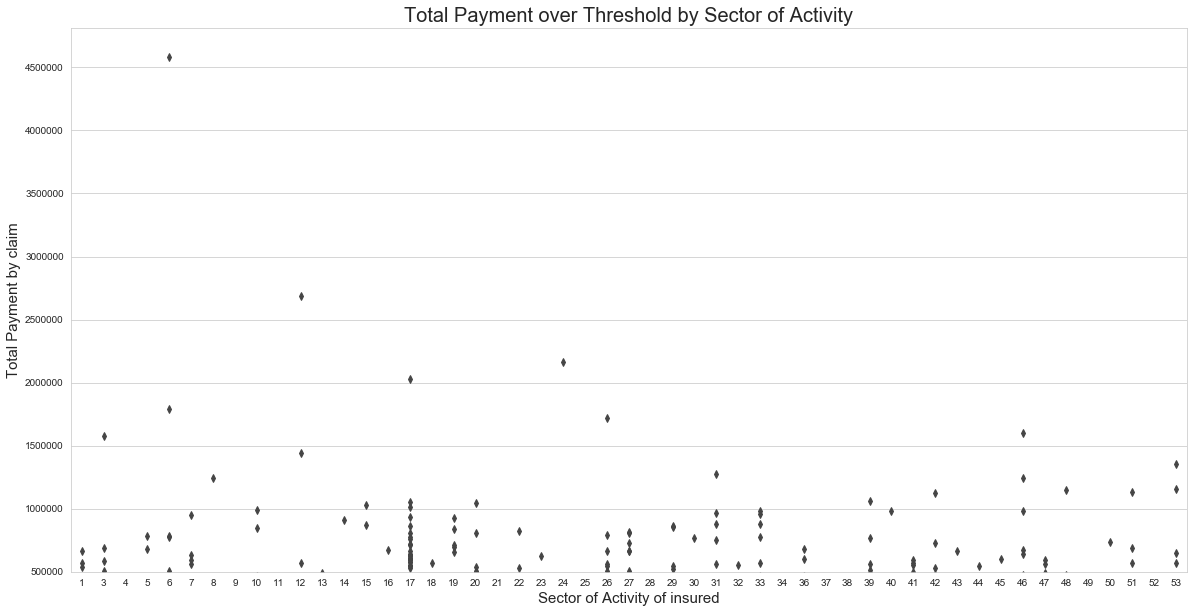

In [48]:
var = 'cc'

df = pd.concat([df2[Paid].sum(axis=1), df2[var]], axis=1)

plt.figure(figsize=(20,10))

fig = sns.boxplot(x=var, y=0, data=df, showfliers=True)
plt.title('Total Payment over Threshold by Sector of Activity',size=20)
axes = plt.gca()
plt.ylabel('Total Payment by claim',size=15)
plt.xlabel('Sector of Activity of insured',size=15)
#axes.set_xlim([-1,12])
fig.axis(ymin=5e5)

plt.show()

The extreme values in terms of payment are well distributed accross the activity sector I would say even if activity sector 17 seems to concentrate more outliers.

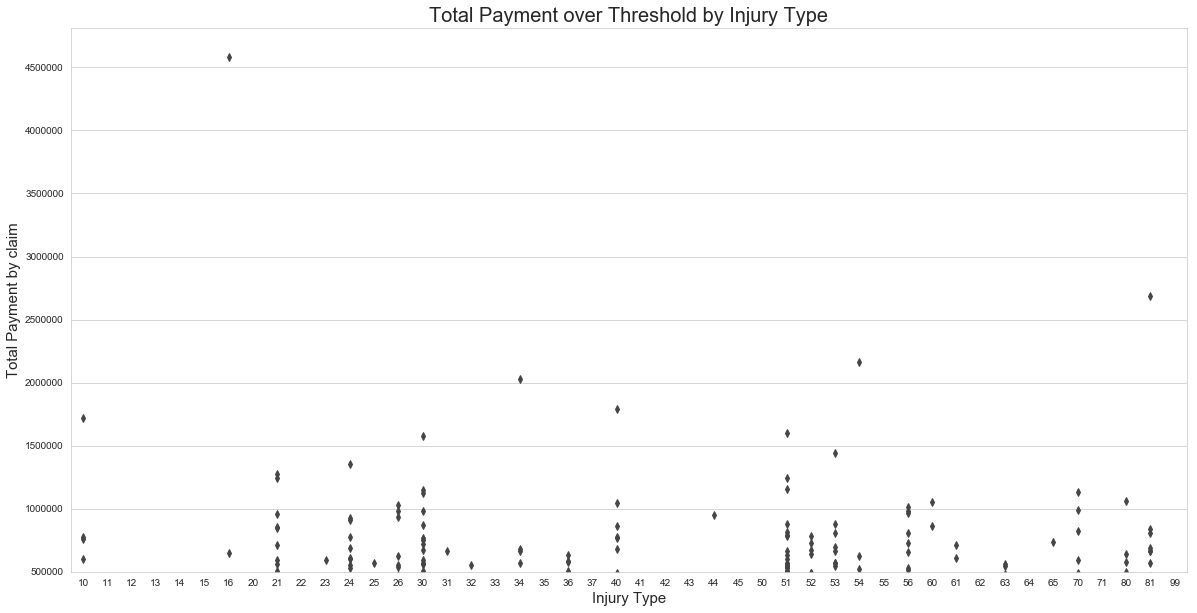

In [49]:
var = 'inj_part'

df = pd.concat([df2[Paid].sum(axis=1), df2[var]], axis=1)

plt.figure(figsize=(20,10))

fig = sns.boxplot(x=var, y=0, data=df, showfliers=True)
plt.title('Total Payment over Threshold by Injury Type',size=20)
axes = plt.gca()
plt.ylabel('Total Payment by claim',size=15)
plt.xlabel('Injury Type',size=15)
#axes.set_xlim([-1,12])
fig.axis(ymin=5e5)

plt.show()

The extreme values in terms of total payment are more frequent in injury group 20-30 and 50

Considering what we have seen from now that is that the mean payment is far more volatile than the median due to a large number of outliers, **the performance metric than I will use in order to assess the accuracy of my ML models  will be the Mean Absolute Error (MAE) which is less biased towards outliers**.

Boxplot of total payment by reporting delay. Claims which are reported a few years after the occurence of the injury could be more severe and cost more.

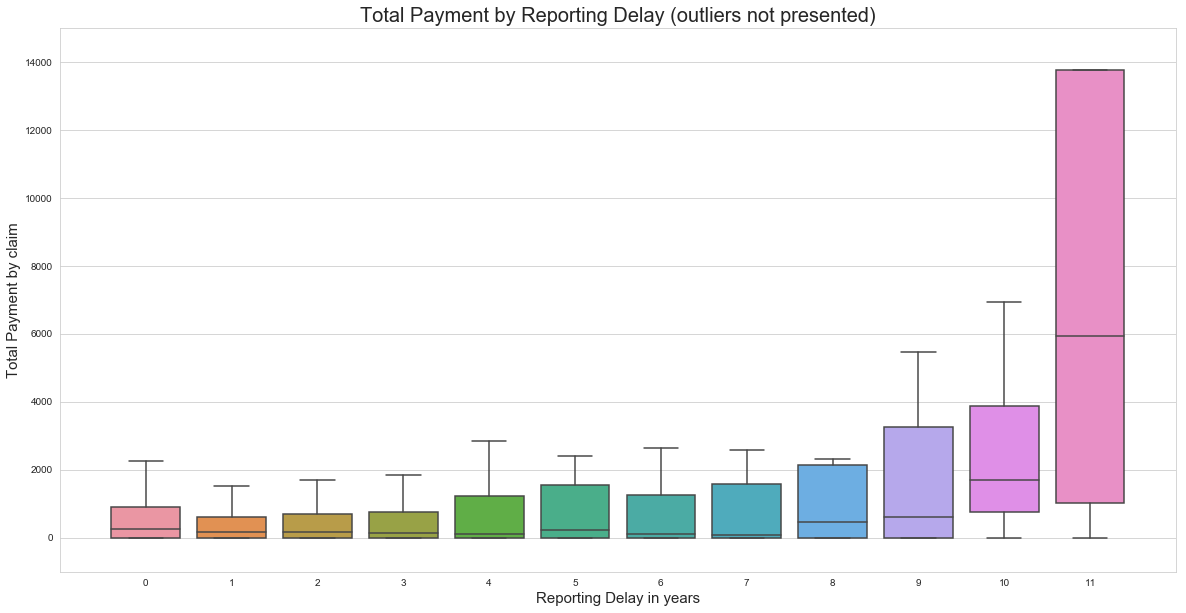

In [50]:
var = 'RepDel'

df = pd.concat([df2[Paid].sum(axis=1), df2[var]], axis=1)

plt.figure(figsize=(20,10))

fig = sns.boxplot(x=var, y=0, data=df, showfliers=False)
plt.title('Total Payment by Reporting Delay (outliers not presented)',size=20)
axes = plt.gca()
plt.ylabel('Total Payment by claim',size=15)
plt.xlabel('Reporting Delay in years',size=15)
axes.set_xlim([-1,12])
fig.axis(ymin=-1e3, ymax=15e3)

plt.show()

Intuition confirmed from the plot as the volatility and median total payment increases with the reporting delay

It seems that the later the claim is reported, the more the claim amount to be paid. It seems legit that the later a injury is healed, the more treatment you get in order to heal it! 

Boxplot of total payment by age in order to see if the age as a predictive power on the total payment. Variabily of claim size also checked with the boxplot.
<br> In my view you can argue in both sense on this one. The older you get, the more severe an accident can get. On the otherhand, you are more prone to do dangerous activities when you are young.
The probability of having an accident can also vary depending on the age I would say.

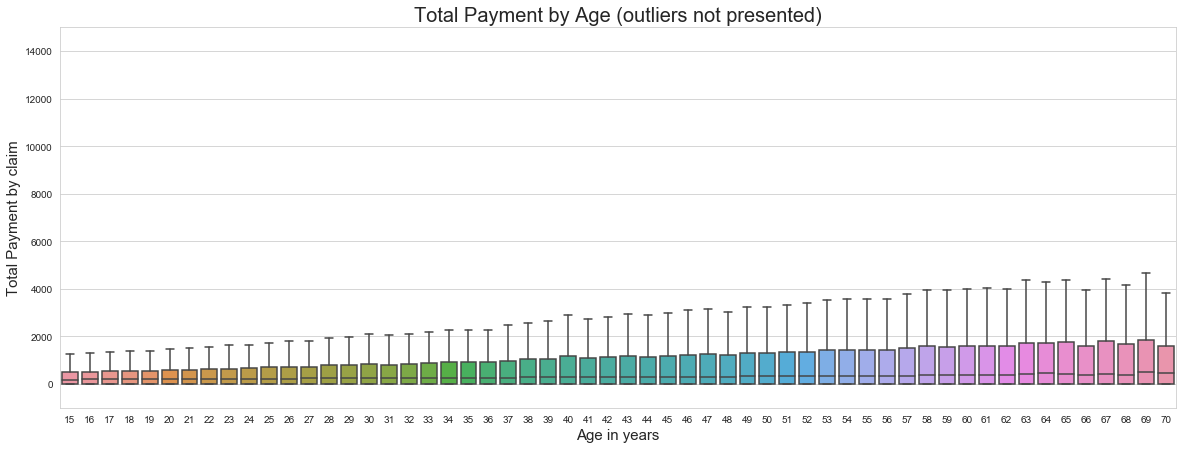

In [51]:
var = 'age'

df = pd.concat([df2[Paid].sum(axis=1), df2[var]], axis=1)

plt.figure(figsize=(20,7))

fig = sns.boxplot(x=var, y=0, data=df, showfliers=False)
plt.title('Total Payment by Age (outliers not presented)',size=20)
axes = plt.gca()
plt.ylabel('Total Payment by claim',size=15)
plt.xlabel('Age in years',size=15)
#axes.set_xlim([-1,12])
fig.axis(ymin=-1e3, ymax=15e3)

plt.show()

The variability of claim size increases with the age.

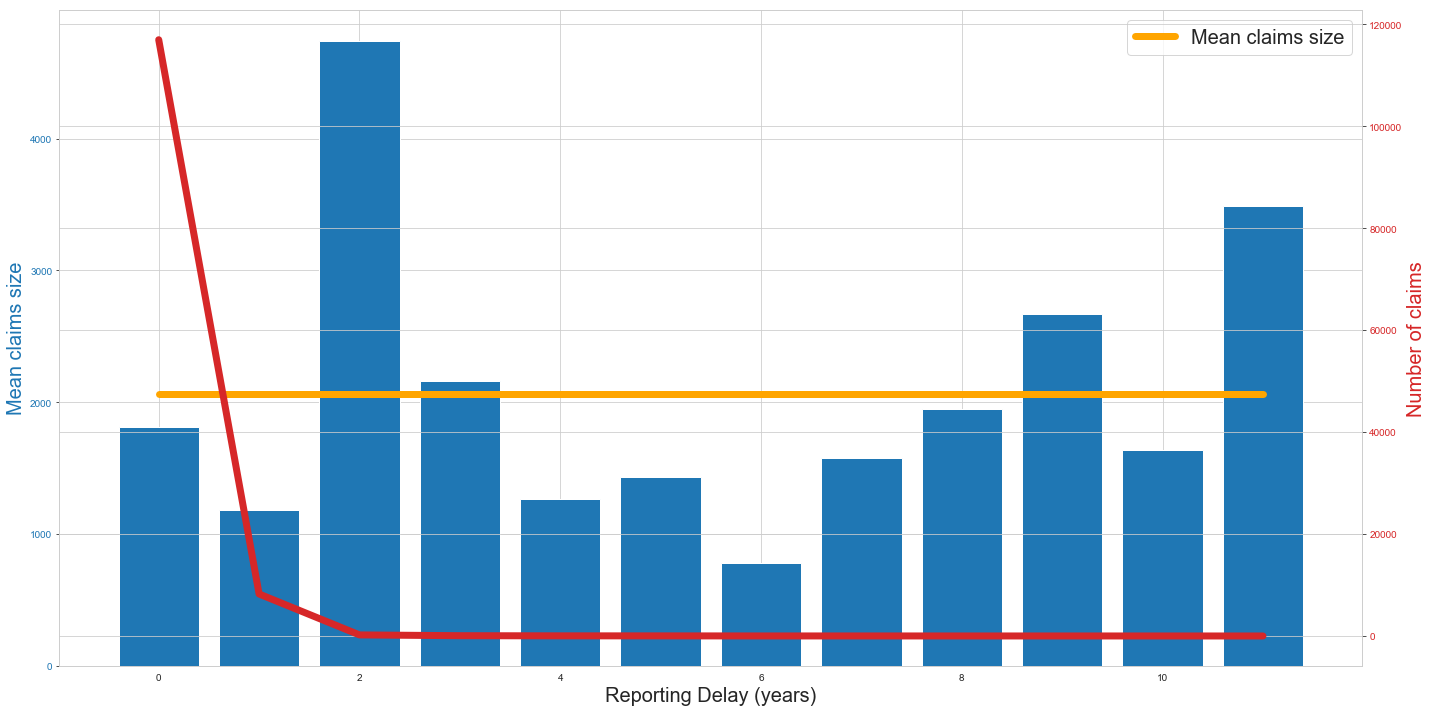

In [52]:
fig, ax1 = plt.subplots(figsize=(20,10))

#Another plot which shows for LoB 4 the relatively low positive correlation between Reporting Delay and Total claim size
df2['Total_Paid'] = data[Paid].sum(axis=1)

color = 'tab:blue'
ax1.set_xlabel('Reporting Delay (years)',size=20)
ax1.set_ylabel('Mean claims size', color=color,size=20)
ax1.bar(data[data['LoB']==1]['RepDel'].unique(), df2[df2['LoB']==4].groupby(['RepDel'])['Total_Paid'].mean(),color=color)
ax1.plot(data[data['LoB']==1]['RepDel'].unique(),[df2[df2['LoB']==4].groupby(['RepDel'])['Total_Paid'].mean().mean()]*12,color='orange',label='Mean claims size',linewidth=7)
plt.legend(loc='best',fontsize=20)
#ax1.plot(t, data1, color=color)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Number of claims', color=color,size=20)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.plot(data[data['LoB']==1].groupby(['RepDel'])['ClNr'].count(),color=color,linewidth=7)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Another plot which shows the low but positive correlation between the reporting delay and the average claim severity. This plot also shows that the vast majority of claims are reported during the same year as the accident year.

Have a look at the 10 most severe claims in my dataset :

In [53]:
df2.sort_values(by='Total_Paid',ascending=False).head(10).iloc[:,1:25]

,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,Pay02,...,Pay07,Pay08,Pay09,Pay10,Pay11,Open00,Open01,Open02,Open03,Open04
339177,2,6,2002,4,53,16,0,0,1860207,845717,...,173143,136301,138616,120080,104940,1,1,1,1,1
322034,3,12,2001,3,68,81,0,670281,1112917,404708,...,0,0,0,0,0,1,1,1,1,1
113221,2,24,1996,3,53,54,0,631171,1002093,381300,...,0,-35480,0,0,0,1,1,1,1,1
215440,2,17,1999,1,37,34,0,470874,575304,301290,...,84519,44762,0,0,0,1,1,1,1,1
153387,4,6,1997,3,18,40,0,195002,499218,237812,...,84939,77154,77748,70888,68311,1,1,1,1,1
384407,3,26,2003,2,56,10,0,252154,653038,258173,...,61489,47234,44404,38697,-6512,1,1,1,1,1
198291,3,46,1998,1,53,51,0,521955,268913,161324,...,64900,64075,58405,55762,47748,1,1,1,1,1
191298,3,3,1998,3,51,30,0,0,473724,407954,...,58700,50346,45809,40739,35644,1,1,1,1,1
424954,2,12,2004,3,63,53,0,296774,586309,292572,...,0,0,0,0,0,1,1,1,1,1
183833,4,53,1998,3,25,24,0,159491,378235,181604,...,62447,56775,56818,51805,49733,1,1,1,1,1


The 10 most severe claims does not come from LoB 1. Claims coming from injury part 50-59 seems to be more frequent for highly severe claims. We can see that those claims lasted in time at the Open indicators are set to 1 for a long period. The majority of the payment is done at development year 0. Some claims seems to have a constant payout throught development years such as the 1st,5th,7th and 10th. It could be annuities which are paid in case of invalidity (paid until retirement for example). Typically from what I know about invalidity annuities is that the first few years, medical costs and salary loss are paid and after 4-6 years, an annuity is settled in case it is proven that you cannot work again in your field.

In [54]:
np.quantile(df2['Total_Paid'],0.99)

23844.75

Let's compute the mean claim size of Open Claims by development year being : <br>
- Total Sum of Incremental Paid Amounts time t= N / Number of Open at time t=N-1 

In [55]:
AveragePaid_OnOpen = []
for x,y in zip(np.sum(data[Paid],axis=0)[1:12],np.sum(data[Open],axis=0)[0:11]):
    AveragePaid_OnOpen.append(x/y)

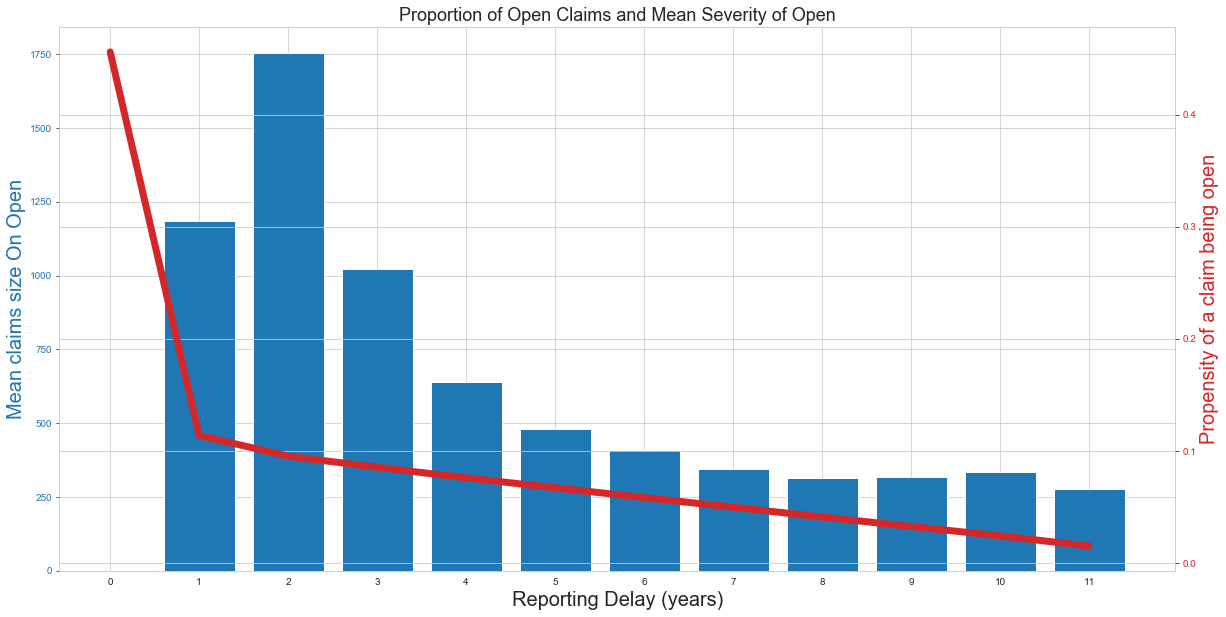

In [56]:
fig, ax1 = plt.subplots(figsize=(20,10))



color = 'tab:blue'
ax1.set_xlabel('Reporting Delay (years)',size=20)
ax1.set_ylabel('Mean claims size On Open', color=color,size=20)
ax1.bar(np.arange(1,12,1),AveragePaid_OnOpen,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()


color = 'tab:red'
ax2.plot(np.arange(0,12,1), data[data[Open]==1][Open].count() / data['Open00'].count(),linewidth=7,color=color)
ax2.set_ylabel('Propensity of a claim being open', color=color,size=20)
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks(np.arange(0,12,1))
plt.title('Proportion of Open Claims and Mean Severity of Open',size=18)
plt.show()

After two years of development, only just more than 10% of claims are still open and thus subject to payments cash flows (does not take into account the probability of re-opening of claims). This percentage of still open claims decrease at a slow rate afterwards. We also see that the mean claim severity of the resulting open claims of the previous year is maximum at development year 2 and is decreasing afterwards.

In [57]:
print('Number of still open claims at the end of the last development year :')
data[data['Open11']==1].groupby('LoB')['LoB'].count()

Number of still open claims at the end of the last development year :


LoB
1    2846
2     738
3     621
4    3423
Name: LoB, dtype: int64

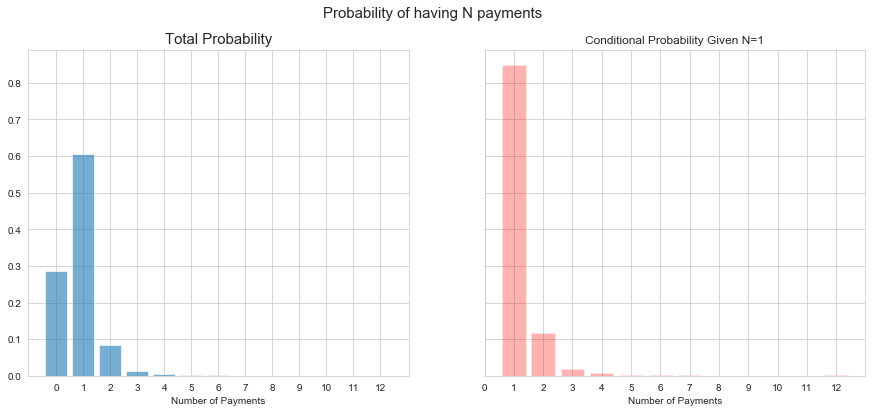

In [58]:
#Probability of x payments 
df_numPayments = data[Paid]>0
df_numPayments = pd.DataFrame(np.sum(df_numPayments,axis=1),columns=['Number'])
df_numPayments['LoB'] = data['LoB']

prob = []
for i in range (0, np.max(df_numPayments['Number'])+1):
    prob.append(df_numPayments[(df_numPayments['Number']==i)]['Number'].count() / df_numPayments['Number'].count())
    
#Conditional probability of x additionnal payments given already one is done     
df_numPayments_1 = df_numPayments[df_numPayments['Number']>=1]

prob_1 = []
for i in range (1, np.max(df_numPayments['Number'])+1):
    prob_1.append(df_numPayments_1[(df_numPayments_1['Number']==i)]['Number'].count() / df_numPayments_1['Number'].count())


fig, axes = plt.subplots(1, 2, figsize=(15,6),sharey=True)
fig.suptitle('Probability of having N payments',size=15)

axes[0].set_title('Total Probability',size=15)
axes[1].set_title('Conditional Probability Given N=1')


axes[0].bar(np.arange(0,13,1),prob,alpha=0.6,label='Probability of having x Payments')
axes[1].bar(np.arange(1,13,1),prob_1,color='r',alpha=0.3,label='Conditiional Probability of having x Payments given 1') 

for ax in axes:
    ax.set_xticks(np.arange(0,13,1))
    ax.set_xlabel('Number of Payments')
    

plt.show()

We can observe that the probability of having no payment is on average near 30% and varying accross lines. More than 50% for Line 2 and 3 and almost 0 for line 1 and 4. We can also see that only a very small amounts of claims have more than 2 payments. In my ML model, I would like to have as many predicting algorithms as the number of development years. If I do this, my first 2 models are crucial for the predictions of total cost of claims (after 11 development years). I can also see that the conditional probability of having more than 2 payments given that I have already one is increasing compared to the total probability of having x payments.

I have looked at the average incremental payment on still open claims by number of payments made. I have seen that the average payment done on open claims is decreasing with the number of payments. Now I will look at the distribution of the cumulative average payment per number of payments to be made :

In [59]:
Av_ClaimSize = []
for i in range(len(np.unique(df_numPayments['Number']))-2):
    Av_ClaimSize.append(np.cumsum(np.sum(data[Paid],axis=0)[1:12])[i] / df_numPayments[(df_numPayments['Number']==i+1)]['Number'].count())

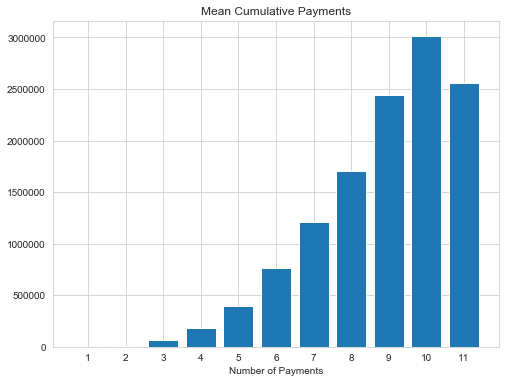

In [60]:
plt.figure(figsize=(8,6))
plt.title('Mean Cumulative Payments')
plt.bar(np.arange(1,12,1),Av_ClaimSize)
plt.xticks(np.arange(1,12,1))
plt.xlabel('Number of Payments')
plt.show()

I see a largely positive correlation between the number of payments and the total amount to be paid. Claims that receive 10 payments cost on average 3 Millions.

##### Claims with recoveries (negative payment) : 

In [61]:
print('Number of claims with at least one recovery :', data[np.sum(data[Paid]<0,axis=1)>0]['ClNr'].count())

Number of claims with at least one recovery : 1431


Add column : Number of Payments

In [62]:
data['Numb_Payments'] = np.sum(data[Paid]>0,axis=1)

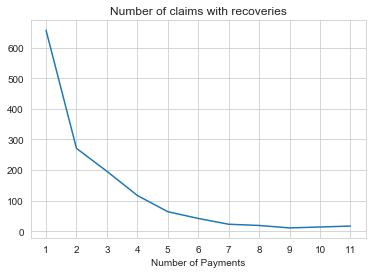

In [63]:
plt.title('Number of claims with recoveries')
plt.plot(data[np.sum(data[Paid]<0,axis=1)>0].groupby(['Numb_Payments'])['ClNr'].count())
plt.xticks(np.arange(1,12,1))
plt.xlabel('Number of Payments')
plt.show()

The vast majority of claims with recoveries have a low number of payments. Recoveries can happen when an insurer pays a certain amount and then the next year ask for a reimbursment because the relation of effect and cause between the injury and the accident has not be proven for example.

##### Reflections relating to the ML models : 

In insurance companies, we compute the aggregate reserves (amounts we still have to pay) by LoB. I would like first maybe my models to learn on the 4 business lines at the time (in order to have one more feature). If the results is not convincing, I will choose one Lob (or two much similar ones) and increase the number of simulations to get more data points.

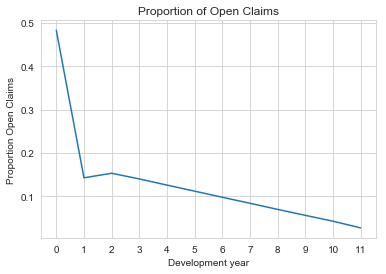

In [64]:
plt.title('Proportion of Open Claims')

df1 =  data[data['LoB']==4]
plt.plot(np.arange(0,12,1), df1[df1[Open]==1 ][Open].count() / data[data['LoB']==4]['Open00'].count())

plt.xlabel('Development year')
plt.ylabel('Proportion Open Claims')
plt.xticks(np.arange(0,12,1))
#plt.legend(loc='best')

plt.show()

50% of the claims are still open after the first year, during the third year, more claims are open than at the end of the second year.

## Feature Enginnering

Add Cumulative Payment at each development year :

In [22]:
data['PayCum00'] = data['Pay00']
data['PayCum01'] = data['Pay00']+data['Pay01']
data['PayCum02'] = data['PayCum01']+data['Pay02']
data['PayCum03'] = data['PayCum02']+data['Pay03']
data['PayCum04'] = data['PayCum03']+data['Pay04']
data['PayCum05'] = data['PayCum04']+data['Pay05']
data['PayCum06'] = data['PayCum05']+data['Pay06']
data['PayCum07'] = data['PayCum06']+data['Pay07']
data['PayCum08'] = data['PayCum07']+data['Pay08']
data['PayCum09'] = data['PayCum08']+data['Pay09']
data['PayCum10'] = data['PayCum09']+data['Pay10']
data['PayCum11'] = data['PayCum10']+data['Pay11']

I also add a boolean variable at each development year which keeps track if there was a payment in the history of the claim and when has it come. The reason why adding this is that a claim which had a payment at each of its historical development has a higher likelihood to continue to receive payment in the future.

In [11]:
#Create 11 Payment Indicator variable 
model=['00','01','02','03','04','05','06','07','08','09','10','11']

for i,j in enumerate(model):

    data.loc[data[str(Paid[i])] != 0, 'Paid_Ind'+str(j)] = 1 
    data.loc[data[str(Paid[i])] == 0, 'Paid_Ind'+str(j)] = 0

In [67]:
data.columns

Index(['ClNr', 'LoB', 'cc', 'AY', 'AQ', 'age', 'inj_part', 'RepDel', 'Pay00',
       'Pay01', 'Pay02', 'Pay03', 'Pay04', 'Pay05', 'Pay06', 'Pay07', 'Pay08',
       'Pay09', 'Pay10', 'Pay11', 'Open00', 'Open01', 'Open02', 'Open03',
       'Open04', 'Open05', 'Open06', 'Open07', 'Open08', 'Open09', 'Open10',
       'Open11', 'PayCum01', 'Total_Paid', 'Numb_Payments', 'PayCum00',
       'PayCum02', 'PayCum03', 'PayCum04', 'PayCum05', 'PayCum06', 'PayCum07',
       'PayCum08', 'PayCum09', 'PayCum10', 'PayCum11', 'Paid_Ind00',
       'Paid_Ind01', 'Paid_Ind02', 'Paid_Ind03', 'Paid_Ind04', 'Paid_Ind05',
       'Paid_Ind06', 'Paid_Ind07', 'Paid_Ind08', 'Paid_Ind09', 'Paid_Ind10',
       'Paid_Ind11'],
      dtype='object')

### Preprocessing Steps

Looking at the distribution of the Age feature : 

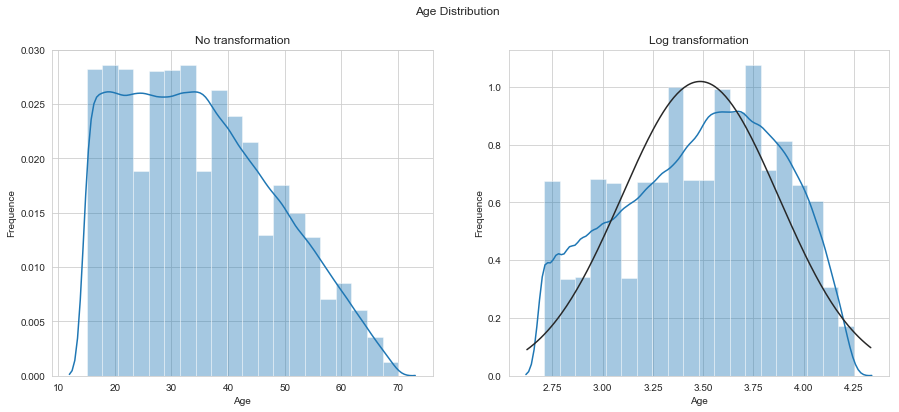

In [68]:
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import norm
fig = plt.figure(figsize=(15,6))
    
#Without transformation
ax2=fig.add_subplot(121)
    
plt.suptitle('Age Distribution')
    
sns.distplot(data['age'], bins=20)
ax2.set_title('No transformation')
ax2.set_xlabel('Age')
ax2.set_ylabel('Frequence')
    
#With transformation
ax1=fig.add_subplot(122)
        

sns.distplot(np.log(data['age']), bins=20, fit=norm)

#plt.legend()
ax1.set_title('Log transformation')
    
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequence')
plt.show()

Log transformation of the Age variable in order to reduce skewness of the original distribution : 

In [23]:
data['age'] = np.log(data['age'])

Plot the Cumulative Payment distribution without transformation and with Log1p transformation :

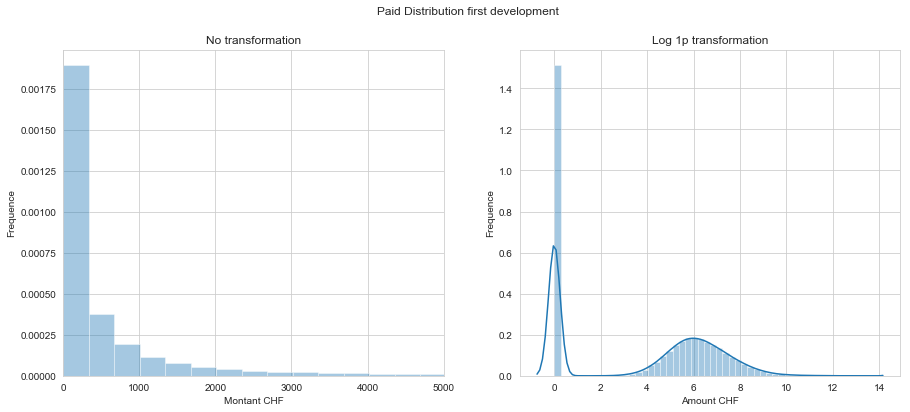

In [70]:
fig = plt.figure(figsize=(15,6))
    
#Without transformation
ax2=fig.add_subplot(121)
    
plt.suptitle('Paid Distribution first development')
    
sns.distplot(data['Pay00'],bins=2000,kde=False,norm_hist=True)
plt.xlim((0,5e3))
ax2.set_title('No transformation')
ax2.set_xlabel('Montant CHF')
ax2.set_ylabel('Frequence')
    
#With transformation
ax1=fig.add_subplot(122)
        

sns.distplot(np.log1p(data['Pay00']),kde=True,norm_hist=True)

#plt.legend()
ax1.set_title('Log 1p transformation')
    
ax1.set_xlabel('Amount CHF')
ax1.set_ylabel('Frequence')
plt.show()

With the log 1p transformation, I have a bimodal distribution. Given that there is a payment at time 0, my distribution is almost normally distributed with no skew so I will use this transformation for my ML models

I will therefore use log1p transformation of cumulative payment in each of my models. I will create those in the feature_creation function a few lines below.

I will also add a feature which is for each claim the proportion of already paid amount on expected payment by Line of Business. 
This variable can help me to know if a future payment is still likely (if the proportion is less than 1). It can also identity Large claims when the proportion is more than one.

In [25]:
data_temp = data[data['AY']!=2005].groupby(['LoB'])['PayCum11'].mean()
data_temp

LoB
1    1109.259293
2    2198.430324
3    2785.154119
4    1749.333862
Name: PayCum11, dtype: float64

In [26]:
def h(arg):
    return data_temp[arg]

In [27]:
vec = []
for i in data['LoB']:
    vec.append(h(i))

In [28]:
data['Paid_Prop00'] = data['PayCum00']/vec
data['Paid_Prop01'] = data['PayCum01']/vec
data['Paid_Prop02'] = data['PayCum02']/vec
data['Paid_Prop03'] = data['PayCum03']/vec
data['Paid_Prop04'] = data['PayCum04']/vec
data['Paid_Prop05'] = data['PayCum05']/vec
data['Paid_Prop06'] = data['PayCum06']/vec
data['Paid_Prop07'] = data['PayCum07']/vec
data['Paid_Prop08'] = data['PayCum08']/vec
data['Paid_Prop09'] = data['PayCum09']/vec
data['Paid_Prop10'] = data['PayCum10']/vec

## Features and Sample selection 

I fill create a framework to select automatically the feature space and the train/valid/test sample according to the model I would like to work on.
As hashing encoding is very slow, I will avoid computing it each time I select a model so I do it one time here :

#### Encoding of Categorical Features

One hot encoding is the more used approach to encode categorical variables. However, as I have many possible values for the injury part and activity sector, and that I want to use KNN and Decisions Trees which are computationaly expensive with the number of features, I will use another approach :

-  **KNN** : Use Target Encoding which is the less computationally expensive as it keeps the number of features constant
- **Decisions Trees** : Use Hashing Encoding (inj_part, cc) which reduce the number of features compared to one hot encoding and also keeps more information from the data and use one hot encoding (LoB) in order to keep all informaation on Lines of Business.

 ####  Hashing Encoding

The new version of Hashing Encoding as a experimental support for parallesim. The new version had an issue for now and does not return the transformed columns if we do not put max_process = 1. The other option is to downgrade the version.
<br>
Link : https://github.com/scikit-learn-contrib/categorical-encoding/issues/215

The default transformed number of columns is 8. Hence, I will loose information compared to my 51 feature value for the inj_part and cc but I will try with the default parameter in order to gain training time 

In [85]:
import category_encoders as ce

data_encode = data.copy()

print('data shape : ', data_encode.shape)
#   *****HASHING ENCODER FOR INJ_TYPE AND CC FEATURES :  ********

ce_hash = ce.HashingEncoder(cols = ['inj_part'],max_process=1)

# fit and transform the train/valid set
data_encode = ce_hash.fit_transform(data_encode)
data_encode.rename(columns={"col_0": "inj_0", "col_1": "inj_1","col_2": "inj_2","col_3": "inj_3",
              "col_4": "inj_4","col_5": "inj_5","col_6": "inj_6","col_7": "inj_7"},inplace=True)
    
print('data shape after hashing encoding on inj_part feature : ', data_encode.shape)

ce_hash = ce.HashingEncoder(cols = ['cc'],max_process=1)

#fit and transform the train/valid set
data_encode = ce_hash.fit_transform(data_encode)
data_encode.rename(columns={"col_0": "cc_0", "col_1": "cc_1","col_2": "cc_2","col_3": "cc_3",
              "col_4": "cc_4","col_5": "cc_5","col_6": "cc_6","col_7": "cc_7"},inplace=True)
print('data shape after hashing encoding on cc feature : ', data_encode.shape)


#   *****ONE HOT ENCODING FOR LOB feature : ********

#One hot encoding LoB feature :
data_encode = pd.get_dummies(data_encode, columns=['LoB'])

print('data shape after hashing encoding on LoB feature : ', data_encode.shape)

data shape :  (500926, 69)
data shape after hashing encoding on inj_part feature :  (500926, 76)
data shape after hashing encoding on cc feature :  (500926, 83)
data shape after hashing encoding on LoB feature :  (500926, 86)


In [86]:
data.columns

Index(['ClNr', 'LoB', 'cc', 'AY', 'AQ', 'age', 'inj_part', 'RepDel', 'Pay00',
       'Pay01', 'Pay02', 'Pay03', 'Pay04', 'Pay05', 'Pay06', 'Pay07', 'Pay08',
       'Pay09', 'Pay10', 'Pay11', 'Open00', 'Open01', 'Open02', 'Open03',
       'Open04', 'Open05', 'Open06', 'Open07', 'Open08', 'Open09', 'Open10',
       'Open11', 'PayCum01', 'Total_Paid', 'Numb_Payments', 'PayCum00',
       'PayCum02', 'PayCum03', 'PayCum04', 'PayCum05', 'PayCum06', 'PayCum07',
       'PayCum08', 'PayCum09', 'PayCum10', 'PayCum11', 'Paid_Ind00',
       'Paid_Ind01', 'Paid_Ind02', 'Paid_Ind03', 'Paid_Ind04', 'Paid_Ind05',
       'Paid_Ind06', 'Paid_Ind07', 'Paid_Ind08', 'Paid_Ind09', 'Paid_Ind10',
       'Paid_Ind11', 'Paid_Prop00', 'Paid_Prop01', 'Paid_Prop02',
       'Paid_Prop03', 'Paid_Prop04', 'Paid_Prop05', 'Paid_Prop06',
       'Paid_Prop07', 'Paid_Prop08', 'Paid_Prop09', 'Paid_Prop10'],
      dtype='object')

As the Hashing encoding is slow, I will save the data_encode variable for later use.

In [89]:
data_encode.to_csv('data_encode.csv')

In [4]:
data_encode = pd.read_csv('data_encode.csv')

#### Features selection  : 

In [9]:
def Features (model_number):
    features = ['AY','AQ','age','RepDel']
    features.append(str(PaidCum[model_number]))
    features.append(str(Open[model_number]))
    for i in range(0,model_number+1) :
        features.append('Paid_Ind'+str(model[i]))
        features.append('Paid_Prop'+str(model[i]))
    return (features + 
        [col for col in data_encode.columns if 'inj' in col]+
        [col for col in data_encode.columns if 'cc' in col]+
        [col for col in data_encode.columns if 'LoB' in col])

In [12]:
Features(model_number = 0)

['AY',
 'AQ',
 'age',
 'RepDel',
 'PayCum00',
 'Open00',
 'Paid_Ind00',
 'Paid_Prop00',
 'inj_0',
 'inj_1',
 'inj_2',
 'inj_3',
 'inj_4',
 'inj_5',
 'inj_6',
 'inj_7',
 'cc_0',
 'cc_1',
 'cc_2',
 'cc_3',
 'cc_4',
 'cc_5',
 'cc_6',
 'cc_7',
 'LoB_1',
 'LoB_2',
 'LoB_3',
 'LoB_4']

I now have features which will be used in each model. The 4 features depending on the model are the "PayCum", the "Open" indicator,the Indicator telling me if there was a payment in the year and the proportion of Paid amount based on average mean total payment by LoB.

The function below takes the corresponding features for each model, does a log transformation of the target feature and select training and test set for each model.

In [6]:
def Create_FeatureSpace(model_number=0):
    
    x = data_encode[Features(model_number)]

    x[PaidCum[model_number]] = np.log1p(x[PaidCum[model_number]])
    
    print('X feature shape after hashing encoding on inj_part feature : ', x.shape)
    
    
    AY = data_encode['AY'].unique()
    
    
    x_te = x.loc[x['AY'].isin(AY[11-model_number:])]
    x = x.loc[~x['AY'].isin(AY[11-model_number:])]
    
    print('X feature shape after encoding and model selection : ', x.shape)
    print('X_te feature shape after encoding and model selection : ', x_te.shape)
    
    return x, x_te

### Machine Learning Guidelines

My goal will be to implement as many machine learning algorithms as the number of development year in order to backtest the True and the Estimated Reserve. I will therefore have an individual claim development pattern for each claim

For the training of my first model (the one predicting the development pattern from the first year), I will put myself in a "real-life situation" by pretending I do not know the development pattern from the most recent accident year(2005). I will therefore use the 2005 sample as the ultimate test set and use previous accident year (1994 to 2004) in the validation and training set. For the second model : I will use the sample of N-1 accident year by pretending I do not know the 2nd development of the claims of 2004 and so on .... <br>

#### Machine Learning Models

- **Baseline Models** : 
        Huber Loss in order to minimise the MAE objective function as mentioned earlier, with and without regularisation
        K Nearest Neighbors using Target Encoding and maybe a sample of the training set
        
- **Must** :
            Random Forests using the MSE objective function as the MAE is not computationally efficiently implemented
            AdaBoost implementation from Scikit Learn
            Random Forest using quantiles of decision trees predictions
            Neural Networks
            
- **Nice to have** : 
            SVM Regressor
            Other boosting methods available in skikit learn library (XG Boost and Gradient Boosting with quantile loss function as well in order to have a prediction range for each claim)
            SGD Lasso using MAE loss function in order to compare with the feature importance attribute from tree methods
            Implement a variant of KNN which computes a certain quantile of the target variable of the k nearest neighbors in order to reduce the underestimation of the target variable as seen below ?  
            
** The most promising models (RF, Boosting, KNN?) will be tuned using cross validation **
            
                

The machine learning algorithm that I will use are regressions algorithms such as Ridge Linear Regression in order to prevent overfitting, method based on trees like random forest and boosting methods. I will also try KNN as a baseline model. Neural Networks will also by part of that study if enough time. 

Problem I do not have answer to for now : 

- A good accuracy of the global reserves of a line of business is important and is revised each three months but I would say that they are set quite conservatively. Is there any measure of performance which penalises under-estimation more than over-estimation ?


## Model 1 - Development Year 1

Two models to predict the Cumulative Payment at time 1.
- A classifier to predict if a claim will receive a payment in the next year
- A regression model to predict the value of the future payment to be made given that there is one  

In [14]:
X,X_te = Create_FeatureSpace(model_number=0)

X feature shape after hashing encoding on inj_part feature :  (500926, 28)
X feature shape after encoding and model selection :  (457099, 28)
X_te feature shape after encoding and model selection :  (43827, 28)


C:\Users\d-dga\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
X.columns

Index(['AY', 'AQ', 'age', 'RepDel', 'PayCum00', 'Open00', 'Paid_Ind00',
       'Paid_Prop00', 'inj_0', 'inj_1', 'inj_2', 'inj_3', 'inj_4', 'inj_5',
       'inj_6', 'inj_7', 'cc_0', 'cc_1', 'cc_2', 'cc_3', 'cc_4', 'cc_5',
       'cc_6', 'cc_7', 'LoB_1', 'LoB_2', 'LoB_3', 'LoB_4'],
      dtype='object')

### Classification Model

Define Target Variable as an indicator variable depending on payment at time = 1 : 

In [16]:
AY = data_encode['AY'].unique()
model_number=0
    
y_te = data.loc[data['AY'].isin(AY[11-model_number:])]['Pay01'].map(lambda x: 0 if x==0 else 1)
y = data.loc[~data['AY'].isin(AY[11-model_number:])]['Pay01'].map(lambda x: 0 if x==0 else 1)

print('y shape : ',y.shape)
print('y_te shape : ',y_te.shape)

y shape :  (457099,)
y_te shape :  (43827,)


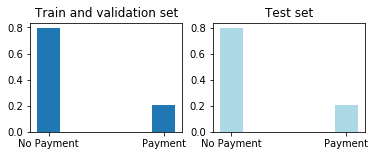

In [19]:
fig = plt.figure(figsize=(6,2))
    
#Train and valid set
ax1=fig.add_subplot(121)
ax1.set_title('Train and validation set')
ax1.bar(['No Payment','Payment',],pd.value_counts(y,normalize=True),width=0.2)

#Test set
ax2=fig.add_subplot(122)
ax2.set_title('Test set')
ax2.bar(['No Payment','Payment'],pd.value_counts(y_te,normalize=True),color='lightblue',width=0.2)
plt.show()

Almost 80% of claims do not have a payment at development year 1. Train and test set similar in terms of probability of payment at development year 1.

#### Split valid and train set 

I would like my models to be trained and tested using claims from all accident year, so I will pass it in the stratify argument. 30% of my data are set for hyperparameter tuning. Cross validated sets are also going to be used in the following.

In [29]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_valid, y_tr, y_valid, PayCum00_tr,PayCum00_valid = train_test_split(
    X, y, data[data['AY']!=2005]['PayCum00'], train_size=0.7, test_size=0.3, random_state=0,stratify=X['AY'])

Importing Evaluation Metrics Library : 

In [30]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

In reserving, Actuaries are conservative while computing reserves for a Line of Business. I will adopt the same strategy here in my classification problem by monitoring the proportion of claims which have a payment but are predicted as not having one (False negative). As there is a tradeoff between false negative and false positive (and hence on precision and recall metrics), I will also have a look at the F1 score which is a combinaison of those two last evaluation metrics (here simple average between the two).

In [31]:
#AdaBoost was justed used for a first look at my evaluation metrics. Will not retain this one in the further analysis.

from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
model_ad = AdaBoostClassifier()
model_ad.fit(X_tr , y_tr)
y_pred = model_ad.predict(X_valid)
target_names = ['NoPayment', 'Payment']
print(classification_report(y_valid, y_pred,target_names=target_names))

              precision    recall  f1-score   support

   NoPayment       0.91      0.97      0.94    108987
     Payment       0.85      0.61      0.71     28143

   micro avg       0.90      0.90      0.90    137130
   macro avg       0.88      0.79      0.82    137130
weighted avg       0.89      0.90      0.89    137130



## <font color='MediumSeaRed'>Random Forest Classifier</font> 

In [32]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=500,class_weight='balanced')
model_RF.fit(X_tr , y_tr)
y_pred_RF = model_RF.predict(X_valid)

#Compute Evaluation Metrics :
acc_RF = accuracy_score(y_valid,y_pred_RF)
prec_RF = precision_score(y_valid,y_pred_RF)
recall_RF = recall_score(y_valid,y_pred_RF)
F1_RF = f1_score(y_valid,y_pred_RF)
print('Evaluation Metrics of RF Classifier :')
print('accuracy: ',acc_RF)
print('Precision:',prec_RF)
print('Recall: ',recall_RF)
print('F1 Score: ',F1_RF)

target_names = ['NoPayment', 'Payment']
print(classification_report(y_valid, y_pred_RF,target_names=target_names))

Evaluation Metrics of RF Classifier :
accuracy:  0.8914971195216218
Precision: 0.7801148842709917
Recall:  0.6562910848168283
F1 Score:  0.7128659372045003
              precision    recall  f1-score   support

   NoPayment       0.91      0.95      0.93    108987
     Payment       0.78      0.66      0.71     28143

   micro avg       0.89      0.89      0.89    137130
   macro avg       0.85      0.80      0.82    137130
weighted avg       0.89      0.89      0.89    137130



As my two classes are not uniformly distributed, I have a class imbalance problem. I will try to fix it by giving more weights to samples with a payment. The class_weight is implemented in the random forest classifier so I will use it :

From the results, I see here that I do not improve any of the evaluation metrics showed above with the rebalancing of sample weights (tried both). I still have a predictive power in my features as the accuracy is well above a "naive" classifier which would always results in a non payment classification (around 80%).

Plot the feature Importance (frequency of splits on each feature) of the RF Classfier

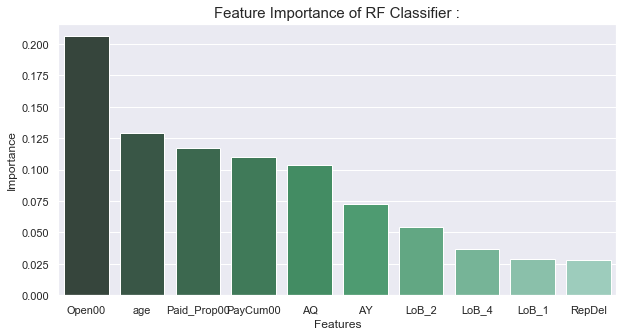

In [34]:
import seaborn as sns
rf_imp_class = pd.DataFrame(X_tr.columns, columns=['Features'])
rf_imp_class['Importance']=np.round(model_RF.feature_importances_,3)
rf_imp_class_top10 = rf_imp_class.sort_values(by='Importance',ascending=False).head(10)

sns.set()
plt.figure(figsize=(10,5))
plt.title('Feature Importance of RF Classifier :',size=15)
sns.barplot(x='Features',y='Importance', palette="BuGn_d",data=rf_imp_class_top10 )
plt.show()

I see here that the feature engeering part was helpful if the sense that the proportion of Paid on expected Payment by LoB was used many times in order to split the data in my RF classifier.
The open feature which is the most used feature is highly logical in the sense that once a claim is closed, it has a very high probability not to be reopen and to get a payment in the next year

I will also try gradient boosting which builds a strong learner by giving more weights to previously miss-classified errors in each weak learner. I will also tune the depth of the weak learners. As the construction of the strong learner is an iterative process where parallelisation cannot be applied (contrary to RF), I will train the model using a sample of the data (10k datapoints).

## <font color='MediumSeaRed'>Gradient Boosting Classifier</font> 

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

# Pruning an individual tree :
depth_values = np.arange(2, 13, 2) 

# Accuracy on the train/test sets
train_acc = []
valid_acc = []
train_recall=[]
valid_recall=[]
train_f1=[]
valid_f1=[]
train_prec=[]
valid_prec=[]

for depth in depth_values:
    # Create a pipeline
    pipe = Pipeline([
        
        # Create GB estimator and set its max_value parameter :
        ('GB',GradientBoostingClassifier(n_estimators=100,max_depth=depth))
    ])

    # Fit Gradient Boosting
    pipe.fit(X_tr[0:10000], y_tr[0:10000])

    
    y_pred_valid = pipe.predict(X_valid)
    y_pred_tr = pipe.predict(X_tr)
    
    # Accuracy on the validation set
    train_acc.append(accuracy_score(y_tr,y_pred_tr))
    valid_acc.append(accuracy_score(y_valid,y_pred_valid))
    
    train_prec.append(precision_score(y_tr,y_pred_tr))
    valid_prec.append(precision_score(y_valid,y_pred_valid))
    
    train_recall.append(recall_score(y_tr,y_pred_tr))
    valid_recall.append(recall_score(y_valid,y_pred_valid))
    
    train_f1.append(f1_score(y_tr,y_pred_tr))
    valid_f1.append(f1_score(y_valid,y_pred_valid))    

Plot the different evaluation metrics depending on the number of splits in the weak learners (train and validation) :

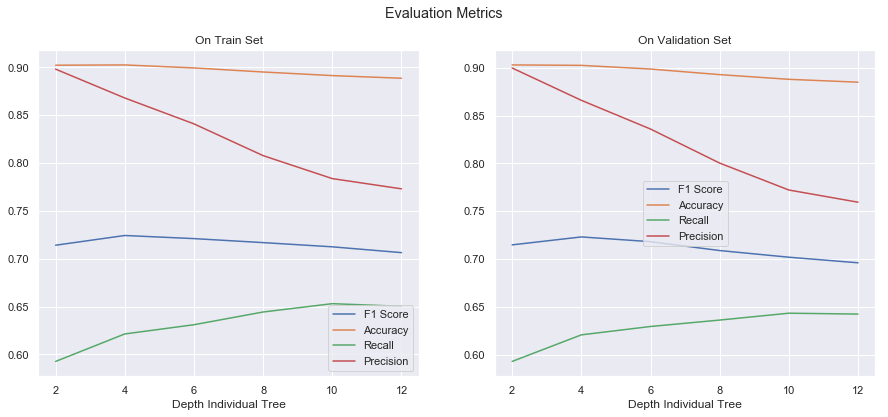

In [37]:
fig = plt.figure(figsize=(15,6))
    
#Without transformation
ax2=fig.add_subplot(121)
    
plt.suptitle('Evaluation Metrics')
    
plt.plot(depth_values, train_f1, label='F1 Score')
plt.plot(depth_values, train_acc, label='Accuracy')
plt.plot(depth_values, train_recall, label='Recall')
plt.plot(depth_values, train_prec, label='Precision')
ax2.set_title('On Train Set')
ax2.set_xlabel('Depth Individual Tree')
plt.legend(loc='best')
    
#With transformation
ax1=fig.add_subplot(122)
        
plt.plot(depth_values, valid_f1, label='F1 Score')
plt.plot(depth_values, valid_acc, label='Accuracy')
plt.plot(depth_values, valid_recall, label='Recall')
plt.plot(depth_values, valid_prec, label='Precision')
plt.legend(loc='best')

#plt.legend()
ax1.set_title('On Validation Set')
    
ax1.set_xlabel('Depth Individual Tree')

plt.show()

Here the best value of the F1 Score on the validation set is which a depth of 4. We can also see the tradeoff between recall and precision.

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
model_GB = GradientBoostingClassifier(max_depth=4,n_estimators=300,learning_rate=0.05)
model_GB.fit(X_tr , y_tr)
y_pred_GB = model_GB.predict(X_valid)

#Compute Evaluation Metrics :
acc_GB = accuracy_score(y_valid,y_pred_GB)
prec_GB = precision_score(y_valid,y_pred_GB)
recall_GB = recall_score(y_valid,y_pred_GB)
F1_GB = f1_score(y_valid,y_pred_GB)
print('Evaluation Metrics of GB Classifier :')
print('accuracy: ',acc_GB)
print('Precision:',prec_GB)
print('Recall: ',recall_GB)
print('F1 Score: ',F1_GB)

Evaluation Metrics of GB Classifier :
accuracy:  0.9058995114125282
Precision: 0.869609507640068
Recall:  0.6369967665138756
F1 Score:  0.735345994503466


I have not done parameter tuning on this Classifier apart from the depth of the weak learners. I could tune the learning rate and the number of estimators in order to see if I get better results. As the algorithm is quite slow and given the fact that the recall and F1 score is already quite high, I will go with this.

Plot the feature Importance (frequency of splits on each feature) of the GB Classfier

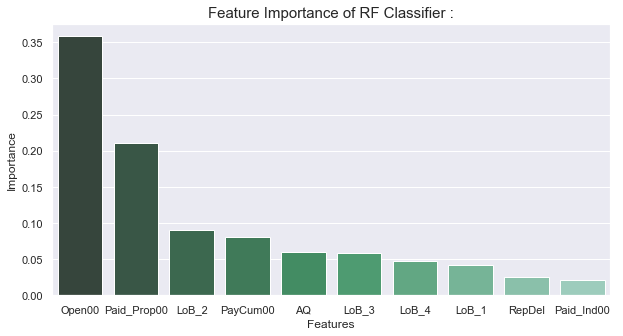

In [39]:
gb_imp_class = pd.DataFrame(X_tr.columns, columns=['Features'])
gb_imp_class['Importance']=np.round(model_GB.feature_importances_,3)
gb_imp_class_top10 = gb_imp_class.sort_values(by='Importance',ascending=False).head(10)

sns.set()
plt.figure(figsize=(10,5))
plt.title('Feature Importance of RF Classifier :',size=15)
sns.barplot(x='Features',y='Importance', palette="BuGn_d",data=gb_imp_class_top10 )
plt.show()

The age feature is not part of the 10 most used features used by the GB Classifier to split the data.

**Open Question** : <br> I notice that the Gradient Boosting classifier and regressor (see later) accentuates the frequency of the most used feature to split the data. Here the dummy variable "Open" is used 35% of the time compared to only 20% for the RF Classifier. Is it inherent to this algorithm which gives more weight to samples which cannot be identified correctly by the weak learners ? 

**Note** : Quite surprised that the inj_part and activity sector do not come up as important features used in those bagging and boosting algorithms.

**Was the hashing encoding a good idea on those features ?**

## <font color='MediumSeaRed'>SVM Classifier</font> 

The scaling of features is important for SVM Classifier. I will use standardScaler as we have seen in the course. I will only try a non linear kernel which is much more time expensive because of the LibLinear library but could result in better accuracy.

I will tune the gamma parameter which controls for the smothness (the higher the gamma the less smooth the decision border) of the decision boundary and the C parameter which accounts for regularisation (the higher the C, the more regularisation )using a stratified 10 fold cross validation sets. C and gamma parameter both controls for the complexity of the model.The evaluation metric of the GridSearchCV object is the F1 score as I do not want to loose to much precision by increasing only the recall. 

The parameter "probability" is set to True in the SVC object as I would like to have a look at the probability predictions of my classifiers later on.

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Create pipeline
pipe = Pipeline([
    ('Scaler', StandardScaler()), # Optional step
    ('SVM', SVC(kernel='rbf',probability=True))
])

# Create cross-validation object
grid_cv_rbf = GridSearchCV(pipe, [{
    'SVM__C': np.linspace(0.01,1,5),
    'SVM__gamma': [0.001,0.01,0.1, 1, 10],

}], cv=10, scoring='f1',
  n_jobs=-1)

# Fit estimator
grid_cv_rbf.fit(X[0:7000].values, y[0:7000])

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'SVM__C': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]), 'SVM__gamma': [0.001, 0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

Looking at the five best cross validated F1 score :

In [41]:
import pandas as pd

# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('C', grid_cv_rbf.cv_results_['param_SVM__C']),
    ('Gamma', grid_cv_rbf.cv_results_['param_SVM__gamma']),
    ('mean_te', grid_cv_rbf.cv_results_['mean_test_score']),
    ('std_te', grid_cv_rbf.cv_results_['std_test_score'])
])
df.sort_values(by='mean_te', ascending=False).head(5)

C:\Users\d-dga\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


,C,Gamma,mean_te,std_te
22,1,0.1,0.648556,0.031509
21,1,0.01,0.638783,0.031942
17,0.7525,0.1,0.638434,0.026619
16,0.7525,0.01,0.634066,0.032335
11,0.505,0.01,0.620298,0.029705


In [42]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

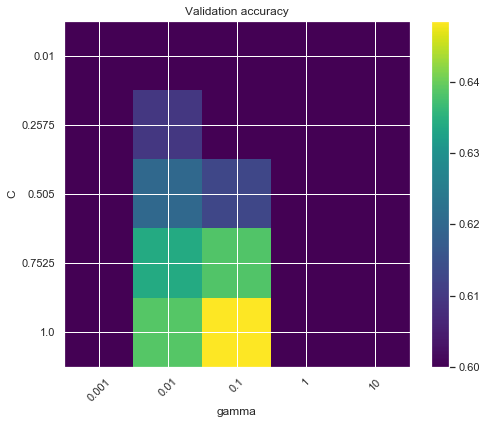

In [45]:
C_range = np.linspace(0.01,1,5)
gamma_range = [0.001,0.01,0.1, 1, 10]

scores = grid_cv_rbf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.viridis,
           norm=MidpointNormalize(vmin=0.6, midpoint=0.63))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [44]:
print('RBF SVM - top accuracy across folds:', grid_cv_rbf.best_score_,'(std : ','{:.6f}'.format(df.sort_values(by='mean_te', ascending=True)['std_te'][0]),') with C value : ', grid_cv_rbf.best_params_.get('SVM__C'),' and gamma value :',grid_cv_rbf.best_params_.get('SVM__gamma'))

RBF SVM - top accuracy across folds: 0.6485561168667786 (std :  0.000000 ) with C value :  1.0  and gamma value : 0.1


In [161]:
#The complexity of the SVM classifier is really too high. Will use 30k datapoint to fit my best tuned parameter. 

best_pipe = grid_cv_rbf.best_estimator_
best_pipe.fit(X_tr[0:30000].values,y_tr[0:30000])
y_pred_SVM = best_pipe.predict(X_valid.values)
f1_score(y_pred_SVM,y_valid)

#Compute Evaluation Metrics :
acc_SVM = accuracy_score(y_valid,y_pred_SVM)
prec_SVM = precision_score(y_valid,y_pred_SVM)
recall_SVM = recall_score(y_valid,y_pred_SVM)
F1_SVM = f1_score(y_valid,y_pred_SVM)
print('Evaluation Metrics of GB Classifier :')
print('accuracy: ',acc_SVM)
print('Precision:',prec_SVM)
print('Recall: ',recall_SVM)
print('F1 Score: ',F1_SVM)

Evaluation Metrics of GB Classifier :
accuracy:  0.8930066360387953
Precision: 0.8695747599451303
Recall:  0.5631240450556089
F1 Score:  0.6835748792270532


In [162]:
best_pipe.predict_proba(X_valid.values)

array([[0.91293552, 0.08706448],
       [0.93174894, 0.06825106],
       [0.93334813, 0.06665187],
       ...,
       [0.89258785, 0.10741215],
       [0.88035046, 0.11964954],
       [0.9025523 , 0.0974477 ]])

## <font color='MediumSeaRed'>Logistic Regression</font> 

In [163]:
from sklearn.linear_model import SGDClassifier



#The logloss here is used with the L2 regularisation regularisation strengh

logistic = SGDClassifier(loss='log', penalty='l2',
                         max_iter=10000, tol=1e-5, random_state=0)

# Create pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', logistic)
])

# Create cross-validation object
grid_cv_LR = GridSearchCV(pipe, [
    {
    'logreg__alpha': np.logspace(-5, 2, 8) ##Tuning of the alpha parameter of the L2 penalty.
} 

],cv=10,scoring='f1') #Evaluation metric : F1 score, 10 cross validated sets

# Fit estimator
grid_cv_LR.fit(X, y)

print("Best parameter (CV score=%0.3f):" % grid_cv_LR.best_score_)
print(grid_cv_LR.best_params_)

Best parameter (CV score=0.717):
{'logreg__alpha': 0.0001}


In [165]:
import pandas as pd

# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('alpha', grid_cv_LR.cv_results_['param_logreg__alpha']),
    ('mean_te', grid_cv_LR.cv_results_['mean_test_score']),
    #('mean_tr',grid_cv_LR.cv_results_['mean_train_score']),
    ('std_te', grid_cv_LR.cv_results_['std_test_score'])
])
df.sort_values(by='mean_te', ascending=False).head(5)

,alpha,mean_te,std_te
1,0.0001,0.717455,0.003596
0,1e-05,0.716961,0.003847
2,0.001,0.708345,0.003455
3,0.01,0.665297,0.002500
4,0.1,0.506938,0.004662


In [166]:
best_pipe_LR = grid_cv_LR.best_estimator_
best_pipe_LR.fit(X_tr.values,y_tr)
y_pred_LR = best_pipe_LR.predict(X_valid.values)
f1_score(y_pred_LR,y_valid)

#Compute Evaluation Metrics :
acc_LR = accuracy_score(y_valid,y_pred_LR)
prec_LR = precision_score(y_valid,y_pred_LR)
recall_LR = recall_score(y_valid,y_pred_LR)
F1_LR = f1_score(y_valid,y_pred_LR)
print('Evaluation Metrics of Logistic Regression Classifier :')
print('accuracy: ',acc_LR)
print('Precision:',prec_LR)
print('Recall: ',recall_LR)
print('F1 Score: ',F1_LR)

Evaluation Metrics of Logistic Regression Classifier :
accuracy:  0.898840516298403
Precision: 0.8395755008804073
Recall:  0.6268699143659169
F1 Score:  0.7177964032874928


Plot different Evaluation Metrics of three Classifiers :

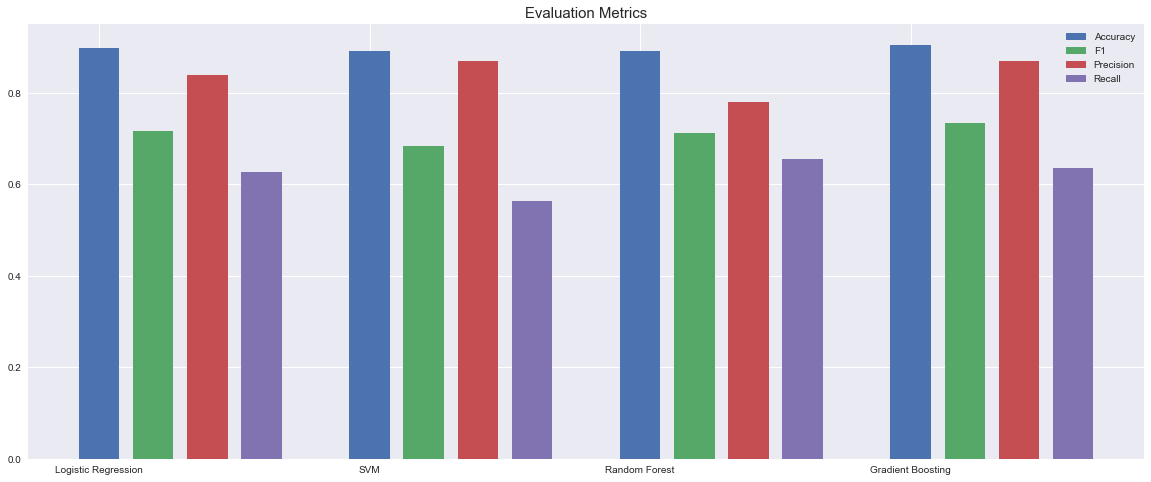

In [167]:
classifiers = ['Logistic Regression','SVM','Random Forest','Gradient Boosting']
accuracy = [acc_LR,acc_SVM,acc_RF,acc_GB]
f1 = [F1_LR,F1_SVM,F1_RF,F1_GB]
prec = [prec_LR,prec_SVM,prec_RF,prec_GB]
recall = [recall_LR,recall_SVM,recall_RF, recall_GB]

width = 0.15
ind=np.arange(0,len(classifiers),1)
fig, ax = plt.subplots(figsize=(20,8))

rects1 = ax.bar(ind,accuracy,width,label='Accuracy')
rects2 = ax.bar(ind+0.2,f1,width,label='F1')
rects3 = ax.bar(ind+0.4,prec,width,label='Precision')
rects4 = ax.bar(ind+0.6,recall,width,label='Recall')
ax.set_xticks(ind)
ax.set_xticklabels(('Logistic Regression','SVM','Random Forest','Gradient Boosting'))
ax.legend(loc='best')
ax.set_title('Evaluation Metrics',size=15)
plt.show()

The RF Classifier has the highest Recall which is appeling as my goal is to avoid False Negative. It therefore loose a bit of precision as its precision of claims payments are not always correct (False positives increases). The classifier which maximises the F1 score which is a combinaison of recall and precision is the Gradient Boosting.

I will plot the Confusion Matrix of my 4 classifiers in order to get a sense of how many false negative I have :

In [225]:
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_confusion_matrix(y_true, y_pred, classes,
                          ax=None,normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    ax = ax 
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    #fig = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    ax.figure.colorbar(im, cax=cax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

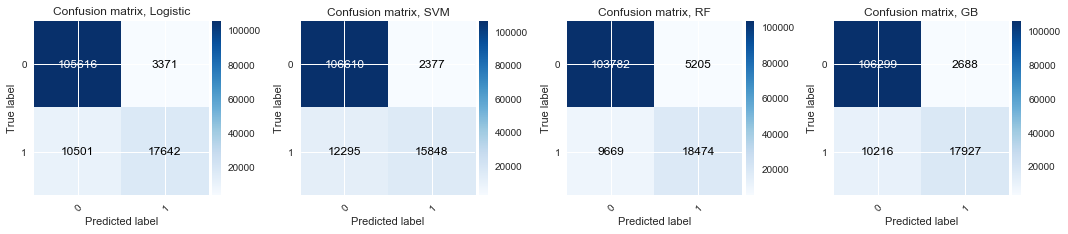

In [181]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,10))

class_names=['No Payment','with Payment']

plot_confusion_matrix(y_valid, y_pred_LR, classes=class_names,
                      ax=ax1,title='Confusion matrix, Logistic')
plot_confusion_matrix(y_valid, y_pred_RF, classes=class_names,
                      ax=ax3,title='Confusion matrix, RF')
plot_confusion_matrix(y_valid, y_pred_SVM, classes=class_names,
                      ax=ax2,title='Confusion matrix, SVM')
plot_confusion_matrix(y_valid, y_pred_GB, classes=class_names,
                      ax=ax4,title='Confusion matrix, GB')

plt.show()

The number of False Negative is lower with the Random Forest Classifier. On the counterpart, precision is lost compared to other classifiers with a higher number of False Positive.

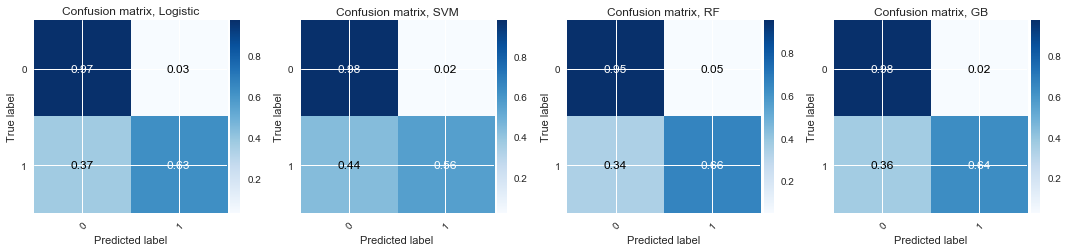

In [182]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,10))

plot_confusion_matrix(y_valid, y_pred_LR, classes=class_names,normalize=True,
                      ax=ax1,title='Confusion matrix, Logistic')
plot_confusion_matrix(y_valid, y_pred_GB, classes=class_names,normalize=True,
                      ax=ax4,title='Confusion matrix, GB')
plot_confusion_matrix(y_valid, y_pred_RF, classes=class_names,normalize=True,
                      ax=ax3,title='Confusion matrix, RF')
plot_confusion_matrix(y_valid, y_pred_SVM, classes=class_names,normalize=True,
                      ax=ax2,title='Confusion matrix, SVM')
plt.show()

At best, 34% of True claims with payment which are not recognised by the model seems to me to be quite high. I will have a look at the probabilities of each individual claims to go deeper.

In [175]:
y_scores_GB = model_GB.predict_proba(X_valid)[:, 1]
y_scores_RF = model_RF.predict_proba(X_valid)[:, 1]
y_scores_SVM = best_pipe.predict_proba(X_valid.values)[:, 1]
y_scores_LR = best_pipe_LR.predict_proba(X_valid.values)[:, 1]

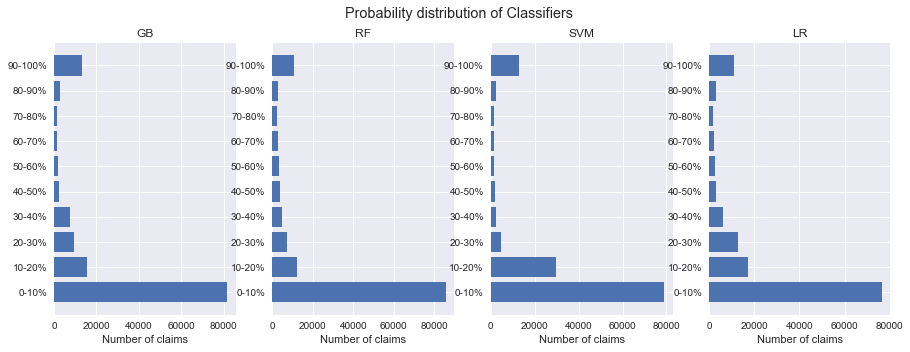

In [177]:
count_GB=[]
count_RF=[]
count_SVM=[]
count_LR=[]
for t in np.linspace(0,1,11):
    count_GB.append(len(y_scores_GB[y_scores_GB<t]))
    count_RF.append(len(y_scores_RF[y_scores_RF<t]))
    count_SVM.append(len(y_scores_SVM[y_scores_SVM<t]))
    count_LR.append(len(y_scores_LR[y_scores_LR<t]))

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5))
    

plt.suptitle('Probability distribution of Classifiers')
group = ['0-10%','10-20%','20-30%','30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','90-100%']
ax1.barh(group,np.diff(count_GB))
ax2.barh(group,np.diff(count_RF))
ax3.barh(group,np.diff(count_SVM))
ax4.barh(group,np.diff(count_LR))
ax1.set_xlabel('Number of claims')
ax2.set_xlabel('Number of claims')
ax3.set_xlabel('Number of claims')
ax4.set_xlabel('Number of claims')
ax1.set_title('GB')
ax2.set_title('RF')
ax3.set_title('SVM')
ax4.set_title('LR')
plt.show()

From the plot here, I see that my classifiers are quite confident about its predictions. It is particularly the case of SVM. Gradient Boosting seems to be very confident as well in the case it predicts a payment (almost nothing in proba 60-90%). GB and RF have quite a lot of claims which are between 30% to 50% and are thus predicted as having no payment. 

I will now have a look for the GB and RF, if the claims with a predicted probability just below 50% are claims which indeed have a payment. If it is the case, I would correct the threshold in order to increase the recall.

In [178]:
df_class = pd.DataFrame(y_valid)
df_class['y_pred_GB'] = y_scores_GB
df_class['y_pred_RF'] = y_scores_RF

df_class[df_class['Pay01']==1].shape

(28143, 3)

In [179]:
df_class.shape

(137130, 3)

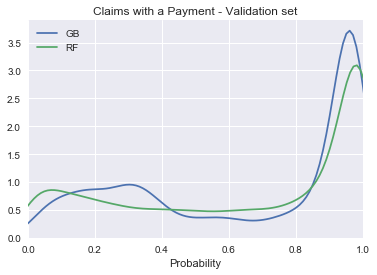

In [183]:
plt.title('Claims with a Payment - Validation set')
sns.distplot(df_class[df_class['Pay01']==1]['y_pred_GB'],label='GB',hist=False)
sns.distplot(df_class[df_class['Pay01']==1]['y_pred_RF'],label='RF',hist=False)
plt.xlim(0,1)
#sns.distplot(df_class[df_class['Pay01']==0]['y_pred'],label='No Payment')
plt.legend(loc='best')
plt.xlabel('Probability')
plt.show()

Quite a high density of true claims with a payment which have a probability of 0.4 or a bit lower for the GB Classifier.

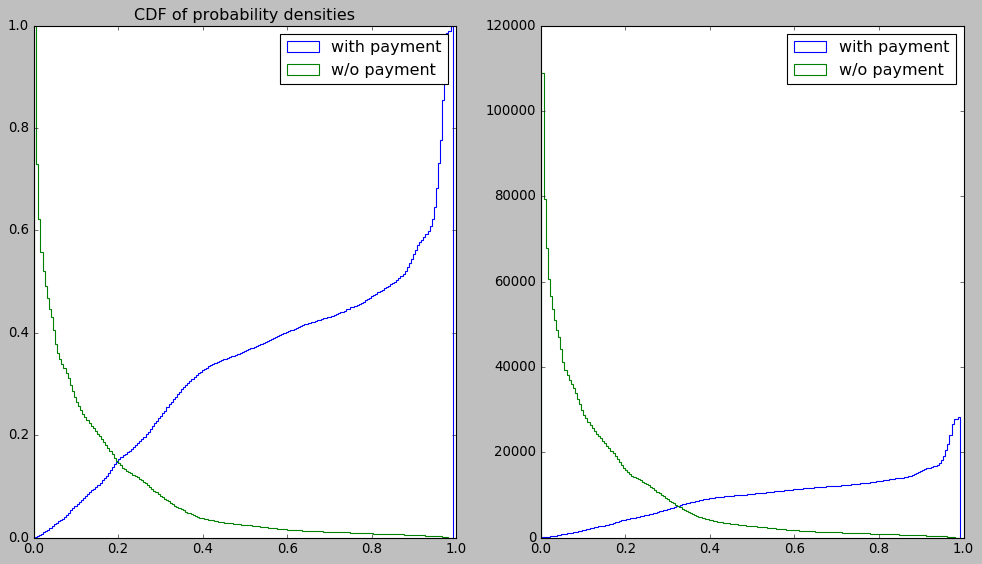

In [206]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

fig, ax = plt.subplots(1,2,figsize=(15, 8))

ax[1].hist(df_class[df_class['Pay01']==1]['y_pred_GB'], bins=200, density=False, histtype='step', cumulative=1,
        label='with payment')
                    

ax[1].hist(df_class[df_class['Pay01']==0]['y_pred_GB'], bins=200, density=False, histtype='step', cumulative=-1,#        label='w/o payment')
            label='w/o payment')

ax[1].legend()

ax[0].hist(df_class[df_class['Pay01']==1]['y_pred_GB'], bins=200, density=True, histtype='step', cumulative=1,
        label='with payment')
                       


ax[0].hist(df_class[df_class['Pay01']==0]['y_pred_GB'], bins=200, density=True, histtype='step', cumulative=-1,#        label='w/o payment')
            label='w/o payment')

ax[0].legend()


ax[0].set_title('CDF of probability densities')

plt.show()

From this plot we see my strategy : I tried to maximise the F1 score as much as I could by tuning the classifiers. Now, I want to find the threshold probability which would give me as many false negative as the number of false positive. As I do not know which claim I cannot identity which my classifiers (potentially large claims?), I will add a safety margin.

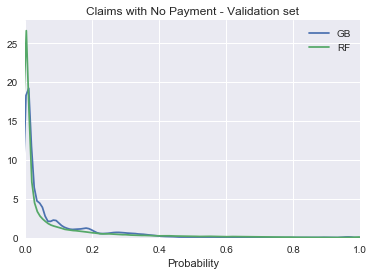

In [185]:
plt.title('Claims with No Payment - Validation set')
sns.distplot(df_class[df_class['Pay01']==0]['y_pred_GB'],label='GB',hist=False)
sns.distplot(df_class[df_class['Pay01']==0]['y_pred_RF'],label='RF',hist=False)
plt.xlim(0,1)
plt.xlabel('Probability')
plt.legend(loc='best')
plt.show()

Classifiers normally signal when the probability is higher than 50%. I will now plot the precision and recall function of one particular classifier,GB (best F1 score), depending on the probability at which the classifier predict a payment :

In [220]:
from sklearn.preprocessing import LabelBinarizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [187]:
p, r, thresholds = precision_recall_curve(y_valid, y_scores_GB)

In [217]:
def adjusted_classes(y_scores_GB, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores_GB]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores_GB, t)
    print(pd.DataFrame(confusion_matrix(y_valid, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)


     pred_neg  pred_pos
neg    100171      8816
pos      6588     21555


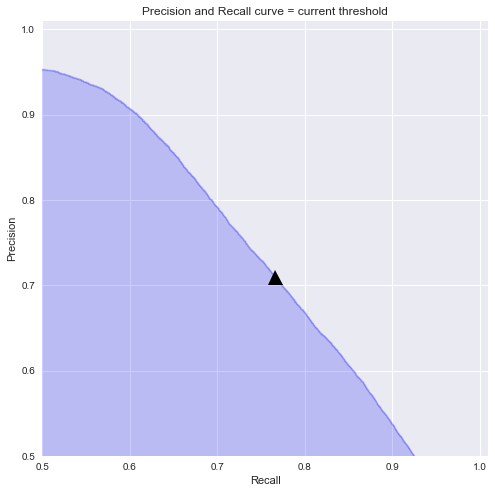

In [193]:
precision_recall_threshold(p, r, thresholds, 0.30)

We see here the tradeoff between precision and recall. By decreasing the threshold of the precision_recall_threshold function, we can see where we would positon on this plot and also the resulting confusion matrix. Decreasing the threshold, decrese the number of false positives. <br>
I note here that neither a precision not a recall of 100% would be achievable with my chosen classifier.

**I will use a threshold probability of 30% on my GB Classifier to take some margin.**

In [216]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

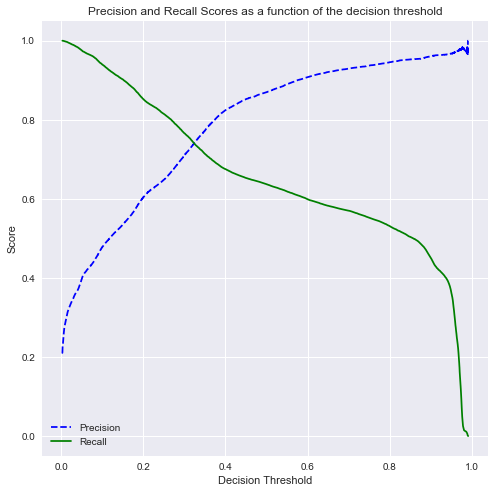

In [195]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [196]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')


AUC of the model :  0.8061666372688842


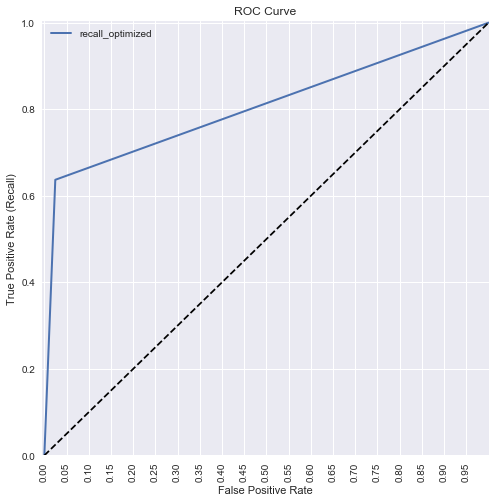

In [198]:
fpr, tpr, auc_thresholds = roc_curve(y_valid, y_pred_GB)
print('AUC of the model : ', auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [46]:
y_pred_01 = (model_GB.predict_proba(X_te)[:,1] >= 0.3).astype(bool)

In [47]:
pd.value_counts(y_pred_01,normalize=True)

False    0.781801
True     0.218199
dtype: float64

In [48]:
pd.value_counts(y_te,normalize=True)

0    0.795058
1    0.204942
Name: Pay01, dtype: float64

Safety margin also on the test set !

In [49]:
print('Accuracy of best classfier on test set : ')
pd.value_counts(y_te == y_pred_01,normalize=True)

Accuracy of best classfier on test set : 


True     0.88717
False    0.11283
Name: Pay01, dtype: float64

In [203]:
confusion_matrix(y_pred_01,y_te)

array([[32082,  2182],
       [ 2763,  6800]], dtype=int64)

2182 claims that I do not recognise as having a payment .. Have a bit of safety on the false positives.

In [50]:
y_pred_01.sum()

9563

In [205]:
y_te.sum()

8982

### Regression Model

**Train the model only on claims with a payment at time = 1** 

In [51]:
index = data[data['Pay01']!=0].index
print('Number of datapoints with non zero payment at time 1 :', index.shape[0])

Number of datapoints with non zero payment at time 1 : 103120


Resize the Train and Validation set only with non zero values :

- **Recall :** The train and validation set does not contain any claims of AY 2005.

In [52]:
import warnings
warnings.filterwarnings("ignore")

X = X.loc[index,:].dropna()
#X.drop(columns='Unnamed: 0',inplace=True)
print('X shape :',X.shape)

X shape : (94138, 28)


In addition to keep predicted payment values in my test set, I will keep a trace of True Claims with a Payment at time 1 in order to evaluate the performance of the regression model **alone**. I do it with my validation set already by passing only true payment values but I am interested at predicting what is in my test set.
<br> If I had a Classifier which would have an accuracy of 100% on unseen values (test set), how accurate would my regression model be ?

In [53]:
model_number = 0

index_Paid01 = data.loc[index,:]['AY'].isin(AY[11-model_number:]).dropna()
index_Paid01_te = index_Paid01[index_Paid01].index
X_Paid01_te = X_te.loc[index_Paid01_te,:]
#Contains features from claims with AY in (2005) which had a payment in development year 1
print('X features of true payment in test set : ',X_Paid01_te.shape)

y_Paid01_te = np.log1p(data.loc[index_Paid01_te,:]['PayCum01'])

print('y shape of true payment in test set : ',y_Paid01_te.shape)

X features of true payment in test set :  (8982, 28)
y shape of true payment in test set :  (8982,)


In [210]:
np.sum(data[data['Pay01']!=0]['AY']==2005)

8982

Define target value as the log1p Cumulative Payment at time = 1. 
<br>
- Recall : The validation and train values are only claims not in AY=2005 

In [54]:
model_number=0

# First Model do not take Accident Year 2005
y = np.log1p(data.loc[~data['AY'].isin(AY[11-model_number:])].loc[index,:].dropna()['PayCum01'])
print('Target (valid+train set) shape : ', y.shape)

Target (valid+train set) shape :  (94138,)


Redefine the size of test sample based on the first model classification predictions :

In [55]:
#Test Features sample :
#X_te.drop(columns='Unnamed: 0',inplace=True)
X_te['Class_Pred'] = y_pred_01
X_te = X_te[X_te['Class_Pred']==True]
X_te.drop(columns='Class_Pred',inplace=True)
print('Test features shape : ', X_te.shape)

#Test target sample :
y_te = np.log1p(data.loc[data['AY'].isin(AY[11-model_number:])].loc[X_te.index,:].dropna()['PayCum01'])

print('Test target shape : ',y_te.shape)

Test features shape :  (9563, 28)
Test target shape :  (9563,)


In [56]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_valid, y_tr, y_valid = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=0,stratify=X['AY'])

#### Baseline Model

In [57]:
from sklearn.metrics import mean_absolute_error as mae

y_med = [np.expm1(np.median(y_valid))] * len(y_valid)

MAE_Bas = mae(np.expm1(y_valid),y_med)

print ("MAE of Baseline Model : {0:.0f} ".format(MAE_Bas))

MAE of Baseline Model : 4265 


## <font color='MediumSeaGreen'>Huber Regressor</font> 

In [111]:
# %%time

from sklearn.linear_model import HuberRegressor
# Create the estimator
huber = HuberRegressor(epsilon=1.35,max_iter=1e3)

# Fit it to X,y
huber.fit(X_tr, y_tr)


y_valid_pred = np.expm1(huber.predict(X_valid))
MAE_Huber = mae(np.expm1(y_valid),y_valid_pred)

print('R^2 coefficient:', huber.score(X_valid, y_valid))
print ("MAE of Huber Model : {0:.1f} ".format(MAE_Huber))

R^2 coefficient: 0.6892838950925838
MAE of Huber Model : 2662.1 


In [112]:
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(np.expm1(huber.predict(X_valid)).sum()))
print('Sum of true Cumulative Payment at time 1 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 1 on validation set : 138299452.0
Sum of true Cumulative Payment at time 1 on validation set :  130251025.0


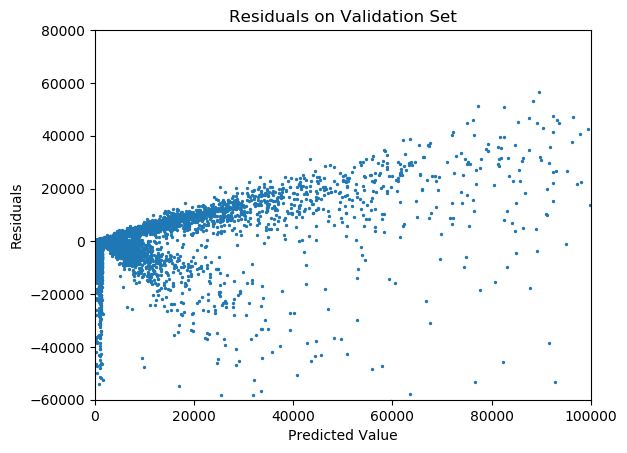

In [113]:
sns.set_style("whitegrid")
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.title('Residuals on Validation Set')
plt.scatter(y_valid_pred, y_valid_pred - np.expm1(y_valid),s=2)
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.xlim(0,100e3)
plt.ylim(-60e3,80e3)
plt.show()

Seems to have a few claims with small predicted payment which are clearly underestimated.

Plot the True vs Predicted Payment for Claims under 100k CHF :

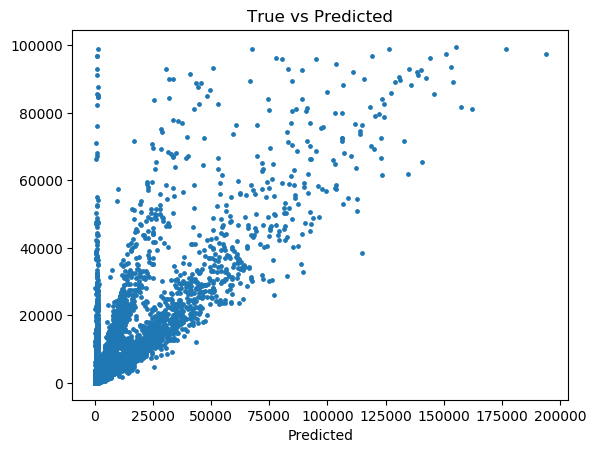

In [123]:
df1 = pd.DataFrame(y_valid_pred,columns=['Pred'])
df1['True'] = np.expm1(y_valid.values)
df1['LoB'] = data.loc[X_valid.index,:]['LoB']
plt.title('True vs Predicted')
plt.scatter(df1[df1['True']<1e5]['Pred'],df1[df1['True']<1e5]['True'],s=6)
plt.xlabel('Predicted')
plt.show()

**Hyperparameter tuning of Huber Regressor :** <br>

I will use a relatively small range for the epsilon and regularisation strengh parameter.<br> The reason for this is that the regressor does not seem to be stable for some other value of those hyperparameters.  


In [229]:
epsilons = np.linspace(1.2,1.4,5)
alphas = np.logspace(-7,1,9)
test_scores = np.zeros((len(epsilons),len(alphas)))
sum_pred = np.zeros((len(epsilons),len(alphas)))


for j in range(len(epsilons)):
    for i in range(len(alphas)):
        
        # Create and fit Huber regression
        huber = HuberRegressor(epsilon=epsilons[j],alpha=alphas[i],max_iter=1e3) #putting max_iter = 1e3 improves my test error
        huber.fit(X_tr, y_tr)
        
        # Performance on test set
        y_valid_pred = np.expm1(huber.predict(X_valid))
        valid_mae = mae(np.expm1(y_valid),y_valid_pred)
        test_scores[j,i] = valid_mae
        sum_pred[j,i] = np.expm1(y_valid).sum()-y_valid_pred.sum()      

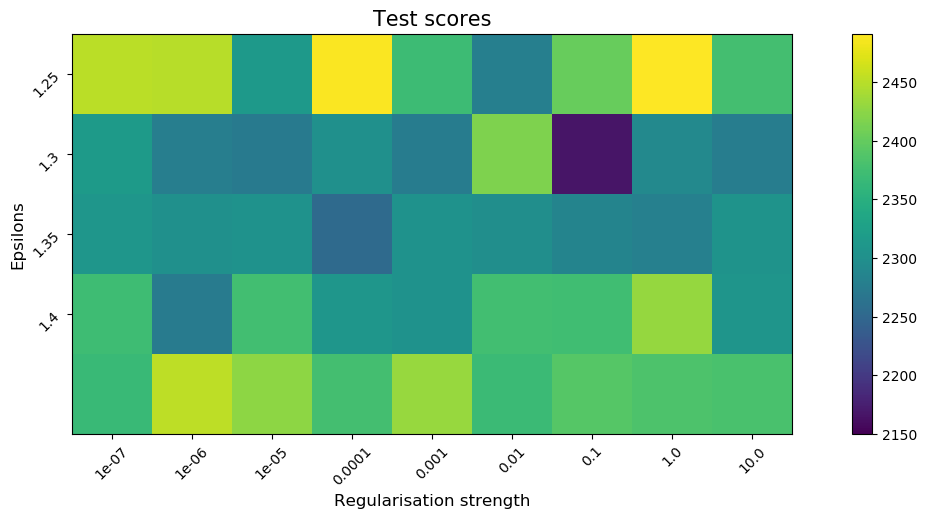

In [230]:
import matplotlib.pyplot as plt
scores = test_scores

# Draw heatmap of the validation accuracy as a function of regu strength and epsilon

#plt.figure(figsize=(16, 5))
fig, ax = plt.subplots(1,1,figsize=(16, 5))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.viridis,
           norm=MidpointNormalize(vmin=2150, midpoint=2300))
plt.ylabel('Epsilons',size=12)
plt.xlabel('Regularisation strength',size=12)
plt.colorbar()
plt.xticks(np.arange(len(alphas)), np.round(alphas,8), rotation=45)
plt.yticks(np.arange(len(epsilons)-1), np.round(epsilons[1:],2),rotation=45)

#plt.ticklabel_format(axis='x', style='sci') 
plt.title('Test scores',size=15)
plt.show()

**Observations :**
- The lower the epsilon, the less it is influenced by outliers. 
<br> The fact that the MAE of validation set is lower for low values of epsilon tells me that using the huber loss instead of a simple linear regressor is useful.<br>
<br>
- The higher the value alpha, the less regularisation is needed. The value of alpha which minimise my validation MAE is 0.1


We do not have a decreasing/increasing MAE score around the regularisation strengh. The function seems to bit in both directions.

I will now use the HuberRegressor with hyperparameters which minimises my validation MAE : 
- The value of 1.35 is advised for the epsilon in the sci-kit learn library but it will use 1.3 because I have a better MAE score.

In [117]:
huber = HuberRegressor(epsilon=1.3,alpha=0.1,max_iter=1e3) #putting max_iter = 1e3 improves my test error
huber.fit(X_tr, y_tr)
y_valid_huber = np.expm1(huber.predict(X_valid))
mae_valid_huber = mae(np.expm1(y_valid),y_valid_huber)
print('MAE of tuned HuberRegressor - validation set : ', mae_valid_huber)

MAE of tuned HuberRegressor - validation set :  2241.7812684563414


In [120]:
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_valid_huber.sum()))
print('Sum of true Cumulative Payment at time 1 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 1 on validation set : 127028986.0
Sum of true Cumulative Payment at time 1 on validation set :  130251025.0


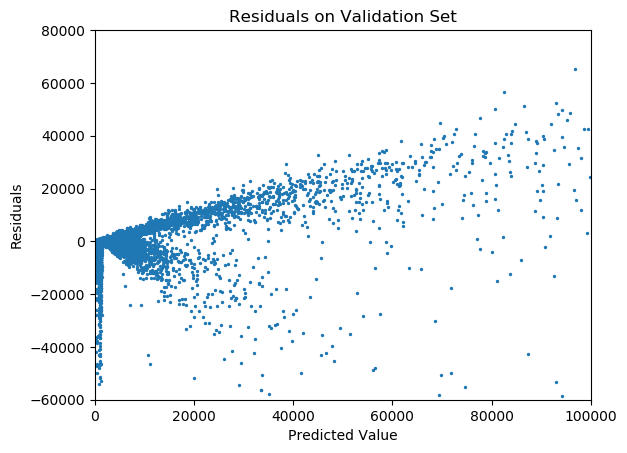

In [121]:
plt.title('Residuals on Validation Set')
plt.scatter(y_valid_huber, y_valid_huber - np.expm1(y_valid),s=2)
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.xlim(0,100e3)
plt.ylim(-60e3,80e3)
plt.show()

The model now still has heteroscedasticity (non constant variance of residuals) but seems to be more calibrated for larger value of predictions.

## <font color='MediumSeaGreen'>K Nearest Neighbors</font>

For KNN I will try target encoding for the "cc" and "inj_part" feature as the encoded features contains too many sparse data and the computations are really long. Reducing the train and test set was also tried but with unsatisfactory results on the objective function.

KNN algorithm requires the feature data to be scaled in order to homogenize the distance between the different features. If it is not done, the algorithm might favour reducing the distance of one particular feature. 
<br> I will therefore use the StandardScaler object of Sci-kit Learn.

In [58]:
from sklearn.neighbors import KNeighborsRegressor

In [59]:
index = data[data['Pay01']!=0].index
print('Number of datapoints with non zero payment at time 1 :', index.shape[0])

Number of datapoints with non zero payment at time 1 : 103120


#### Target Encoding 

Will only use it for KNN Regressor.

In [60]:
#First Model
#means_LOB = data[data['AY']!=2005].groupby('LoB')['PayCum01'].mean()
means_cc = data[data['AY']!=2005].groupby('cc')['PayCum01'].mean()
means_inj = data[data['AY']!=2005].groupby('inj_part')['PayCum01'].mean()

#Test_set 
#means_LOB_2005 = data[data['AY']==2005].groupby('LoB')['PayCum01'].mean()
means_cc_2005 = data[data['AY']==2005].groupby('cc')['PayCum01'].mean()
means_inj_2005 = data[data['AY']==2005].groupby('inj_part')['PayCum01'].mean()

In [61]:
#Drop the columns which contains the word "inj" to drop the 7 injury_part encoded columns
X_KNN = X[X.columns.drop(list(X.filter(regex='inj')))]
#Drop the columns which contains the word "cc" to drop the 7 "claims code" encoded columns
X_KNN = X_KNN[X_KNN.columns.drop(list(X_KNN.filter(regex='cc')))]

#Retrieve the claims code and inj_part values for the selected sample :
X_KNN['inj_part'] = data['inj_part'].loc[X_KNN.index]
X_KNN['cc'] = data['cc'].loc[X_KNN.index]
print('X_KNN columns :', X_KNN.columns)
print('X_KNN shape :', X_KNN.shape)

#Do the same for the test set (data AY=2005)
X_KNN_te = X_te[X_te.columns.drop(list(X_te.filter(regex='inj')))]
X_KNN_te = X_KNN_te[X_KNN_te.columns.drop(list(X_KNN_te.filter(regex='cc')))]
X_KNN_te['inj_part'] = data['inj_part'].loc[X_KNN_te.index]
X_KNN_te['cc'] = data['cc'].loc[X_KNN_te.index]
print('X_KNN_te columns :', X_KNN_te.columns)
print('X_KNN_te shape :', X_KNN_te.shape)

X_KNN columns : Index(['AY', 'AQ', 'age', 'RepDel', 'PayCum00', 'Open00', 'Paid_Ind00',
       'Paid_Prop00', 'LoB_1', 'LoB_2', 'LoB_3', 'LoB_4', 'inj_part', 'cc'],
      dtype='object')
X_KNN shape : (94138, 14)
X_KNN_te columns : Index(['AY', 'AQ', 'age', 'RepDel', 'PayCum00', 'Open00', 'Paid_Ind00',
       'Paid_Prop00', 'LoB_1', 'LoB_2', 'LoB_3', 'LoB_4', 'inj_part', 'cc'],
      dtype='object')
X_KNN_te shape : (9563, 14)


In [62]:
#Replace the categorical values by the mean of the target for the different claims code and injury type :

#First Model
X_KNN['cc'] =  X_KNN.loc[:,'cc'].map(means_cc)
X_KNN['inj_part'] =  X_KNN.loc[:,'inj_part'].map(means_inj)

#Test set
X_KNN_te['cc'] =  X_KNN_te.loc[:,'cc'].map(means_cc_2005)
X_KNN_te['inj_part'] =  X_KNN_te.loc[:,'inj_part'].map(means_inj_2005)

Define train and validation set for KNN with target encoded features :

In [63]:
# Split data for KNN specially with target encoding
X_tr_KNN, X_valid_KNN, y_tr, y_valid = train_test_split(
    X_KNN, y, train_size=0.7, test_size=0.3, random_state=0,stratify=X_KNN['AY'])

Define a set of possible values to tune the KNN algorithm :

In [64]:
# Define a set of reasonable values
k_values = np.arange(5, 15, 2) # 5, 7, 9, .., 15
weights_functions = ['uniform', 'distance']
distance_types = [1, 2] # L1, L2 distances

In [65]:
from sklearn.model_selection import ParameterGrid

# Define a grid of values
grid = ParameterGrid({
    'knn__n_neighbors': k_values,
    'knn__weights': weights_functions,
    'knn__p': distance_types
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 20


Train the model for those 20 combinaisons of hyperparameters. <br> Since my train set is restained to the claims with a payment at development year 1, I can test those parameters on the whole train set (100k datapoints).

In [66]:
#%%time
import time
start_time = time.time()

# Accuracy on the train/test sets
train_scores = []
test_scores = []

# Create a pipeline
pipe_knn = Pipeline([
        ('scaler', StandardScaler()),
        # Create k-NN estimator and set its k value
        ('knn',KNeighborsRegressor(n_jobs=-1)) # As many parallel jobs as possible : divide the time by 3 in this case!
    ])

for params_dict in grid:
    # Set parameters
    pipe_knn.set_params(**params_dict)

    
    # Fit k-NN regressor
    pipe_knn.fit(X_tr_KNN, y_tr)

    # Accuracy on the test set
    y_pred_knn_te = np.expm1(pipe_knn.predict(X_valid_KNN))
    params_dict['accuracy_test'] = mae(np.expm1(y_valid),y_pred_knn_te)
    
    # Accuracy on the train set
    y_pred_knn_tr = np.expm1(pipe_knn.predict(X_tr_KNN))
    params_dict['accuracy_train'] = mae(np.expm1(y_tr),y_pred_knn_tr)

    # Save accuracy values
    train_scores.append(params_dict)
    test_scores.append(params_dict)
    
elapsed_time = time.time() - start_time
print('KNN Model trained and evaluated for 20 combinaisons of hyperparameters in :',np.round(elapsed_time),'seconds')

KNN Model trained and evaluated for 20 combinaisons of hyperparameters in : 152.0 seconds


In [185]:
# Create DataFrame with valid scores
scores_df = pd.DataFrame(test_scores)

# Top ten scores
scores_df_top10 = scores_df.sort_values(by='accuracy_test', ascending=True).head(10)
scores_df_top10

,accuracy_test,accuracy_train,knn__n_neighbors,knn__p,knn__weights
5,1655.703404,3.375156,7,1,distance
9,1656.947136,3.375156,9,1,distance
1,1657.889243,3.375156,5,1,distance
0,1666.166277,1387.283028,5,1,uniform
4,1669.349714,1461.955459,7,1,uniform
13,1669.764728,3.375156,11,1,distance
8,1672.189757,1506.270525,9,1,uniform
17,1686.689863,3.375156,13,1,distance
12,1690.467310,1534.887396,11,1,uniform
16,1711.180243,1566.106394,13,1,uniform


**Observations :**

- The train accuracy is minimal when the weights are inversely proportional to the distance, independently if the distance is computed as the taxilab distance or the eucledian distance.
- The top 10 results on validation set are with L1 distance.


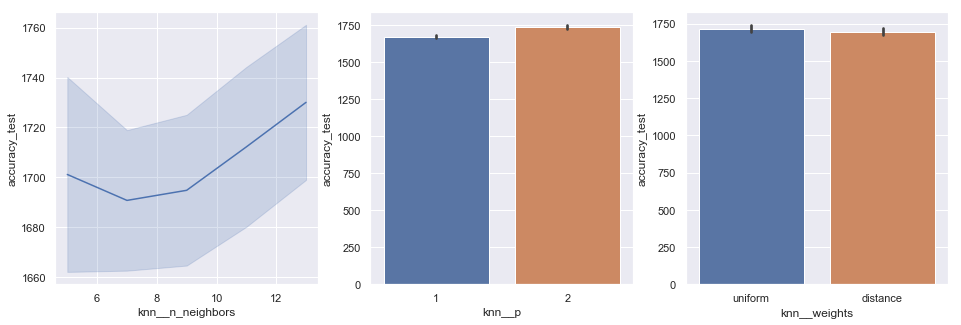

In [68]:
f, (ax1, ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(16,5))

plt.subplot(1, 3, 1)
sns.lineplot(x='knn__n_neighbors',y='accuracy_test',data=scores_df)

plt.subplot(1, 3, 2)
sns.barplot(x='knn__p',y='accuracy_test',data=scores_df)

plt.subplot(1, 3, 3)
sns.barplot(x='knn__weights',y='accuracy_test',data=scores_df)
plt.show()

In [247]:
idx = scores_df_top10['accuracy_test'].idxmin()

print("Total accuracy on validation set : %(n)s with k value %(s)s, distance metric L%(d)s and weights: %(w)s" % {'n': scores_df_top10['accuracy_test'][idx], 's': scores_df_top10['knn__n_neighbors'][idx], 'd': scores_df_top10['knn__p'][idx], 'w': scores_df_top10['knn__weights'][idx]})

Total accuracy on validation set : 1655.703404203305 with k value 7, distance metric L1 and weights: distance


In [186]:
pipe_knn.set_params(knn__n_neighbors = 7, knn__p=1, knn__weights='distance' )
pipe_knn.fit(X_tr_KNN,y_tr)

# Accuracy on the validation set
y_pred_knn = np.expm1(pipe_knn.predict(X_valid_KNN))
mae_knn_valid = mae(np.expm1(y_valid),y_pred_knn)

print('Mean Absolute Error : {:.3f}'.format(mae_knn_valid))

Mean Absolute Error : 1666.166


In [187]:
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_pred_knn.sum()))
print('Sum of true Cumulative Payment at time 1 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 1 on validation set : 103773417.0
Sum of true Cumulative Payment at time 1 on validation set :  130251025.0


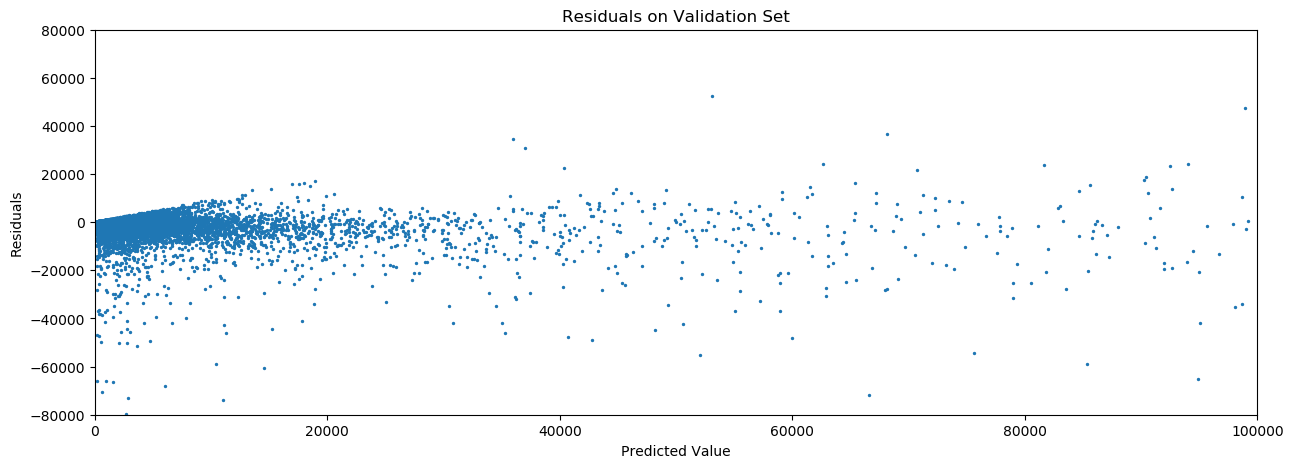

In [128]:
plt.figure(figsize=(15,5))
plt.title('Residuals on Validation Set')
plt.scatter(y_pred_knn, y_pred_knn - np.expm1(y_valid),s=2)
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.xlim(0,100e3)
plt.ylim(-80e3,80e3)
plt.show()

The predictions erros from the tuned KNN regressor seems to be more homoscedastic (constant variance over predicted values). Nevertheless, they appear to be constantly negative.

I will plot the distributions of predicted and true values in order to get more insight about the errors :

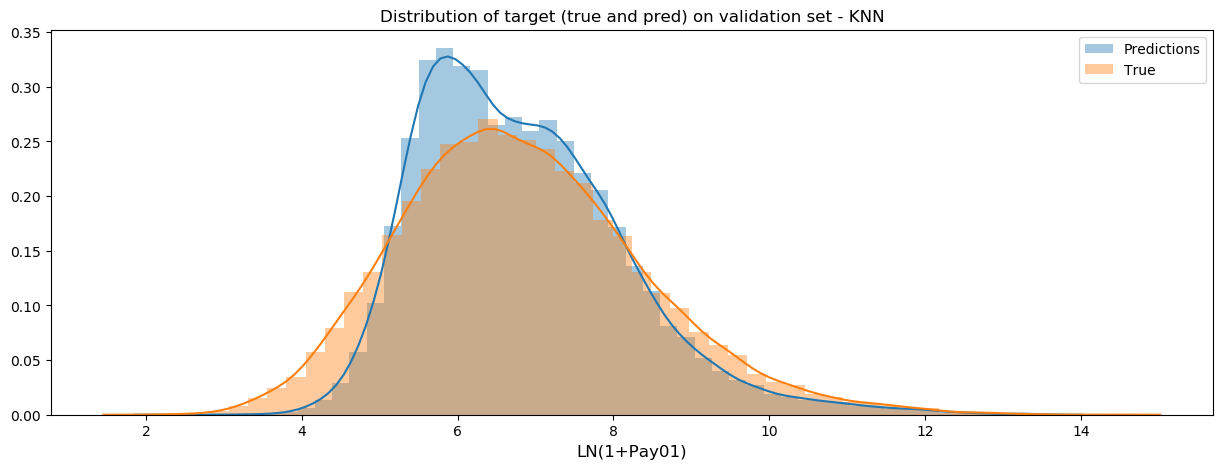

In [251]:
plt.figure(figsize=(15,5))
plt.title('Distribution of target (true and pred) on validation set - KNN',size=12)
sns.distplot(np.log1p(y_pred_knn),label='Predictions')
sns.distplot(y_valid,label='True')
plt.legend(loc='best')
plt.xlabel('LN(1+Pay01)',size=12)
plt.show()

The distribution of predictions is less volatile than the true distribution. It also has a lot of points predicted in the region of 5 to 6 which skews the distribution a bit to the left.

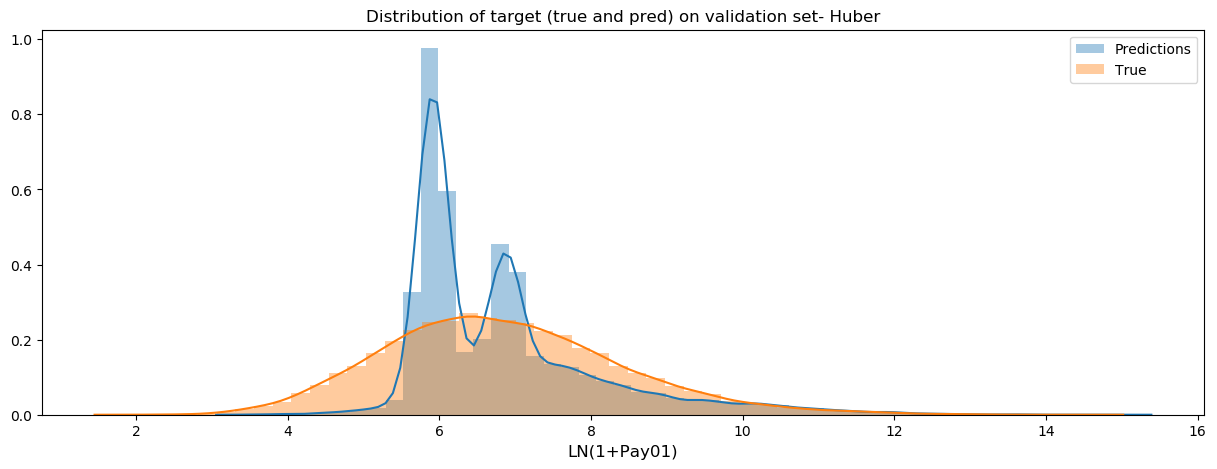

In [252]:
plt.figure(figsize=(15,5))
plt.title('Distribution of target (true and pred) on validation set- Huber',size=12)
sns.distplot(np.log1p(y_valid_huber),label='Predictions')
sns.distplot(y_valid,label='True')
plt.legend(loc='best')
plt.xlabel('LN(1+Pay01)',size=12)
plt.show()

The huber regressors highly evaluates PayCum01 around 2 values. Is also overestimates low payment values and underestimate high payment values

## <font color='MediumSeaGreen'>Decision Trees</font>

Ideally in order to avoid to be biased towards outliers, I would have liked to evaluate the quality of a split by using the mean absolute error which minimizes the L1 loss using the median of each terminal node of the decision tree (and random forest) of sci-kit learn. This corresponds to the training loss and not the evaluation metric. <br>
However, I will show that the complexity of the algo is far from optimal for now O(N) and that reducing the MSE is less computationaly expensive.

In [256]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae

# Create decision tree
dt = DecisionTreeRegressor(
    criterion='mae', max_depth=None, random_state=0)

In [257]:
import timeit

sample_sizes=[5000,10000,20000,40000]
time = []
accuracy=[]

for sample_size in sample_sizes:

    start_time = timeit.default_timer()
    # Fit decision tree
    dt.fit(X_tr[0:sample_size], y_tr[0:sample_size])
    elapsed = timeit.default_timer() - start_time
    
    time.append(elapsed)
    # Accuracy on the valid set
    y_pred_dt = np.expm1(dt.predict(X_valid))
    valid_acc = mae(np.expm1(y_valid),y_pred_dt)
    accuracy.append(valid_acc)

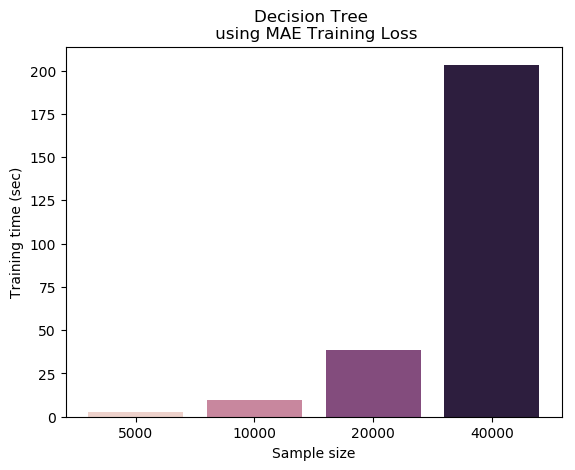

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title('Decision Tree \n using MAE Training Loss')
plt.bar(np.arange(0,4,1), time,color=sns.cubehelix_palette(4))
plt.xticks(np.arange(len(time)),sample_sizes)
plt.xlabel('Sample size')
plt.ylabel('Training time (sec)')
plt.show()

I will therefore minimise the MSE training loss.

Define the Loss Evaluation Metric as the MAE in monetary units for the GridSearchCV object :

In [71]:
def MAE(y_true,y_pred):
    Mae = mae(np.expm1(y_true), np.expm1(y_pred))
    print ('MAE: ' , mae)
    return Mae

I will use GridSeachCV in order to test my loss function for different depth of the tree using a stratified 10 fold validation set. <br>The goal of using GridSearch is to avoid overfitting.

In [260]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

estimator = DecisionTreeRegressor(criterion='mse', random_state=0)

#Test 1 to 30 splits of the Decision Tree : 
para_grids = {
            "max_depth" : np.arange(1,31,1),
        }

grid_cv = GridSearchCV(estimator, para_grids, scoring=make_scorer(MAE, greater_is_better=False),cv=10,n_jobs=-1)
grid_cv.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=0,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
             pre_dispatch='2*n_jobs', ref

In [261]:
print('Cross validation best parameter :', grid_cv.best_params_)
print('Cross validation best MAE score :', np.abs(np.round(grid_cv.best_score_,0)))

Cross validation best parameter : {'max_depth': 8}
Cross validation best MAE score : 1293.0


See the 5 best results in a DataFrame : 

In [262]:
import pandas as pd

# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('max_depth', grid_cv.cv_results_['param_max_depth']),
    ('mean_te', np.abs(grid_cv.cv_results_['mean_test_score'])),
    ('std_te', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean_te', ascending=True).head()

,max_depth,mean_te,std_te
7,8,1292.874894,148.958609
8,9,1311.622785,151.412291
6,7,1318.333782,159.873320
9,10,1348.412400,182.652052
10,11,1365.573413,164.723046


See the MAE scores of the 10 cross validated set with max_depth = 8 : 

In [263]:
results = pd.DataFrame(grid_cv.cv_results_)
results[results['rank_test_score'] ==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
7,1.173267,0.109712,0.041351,0.028081,8,{'max_depth': 8},-1130.879063,-1129.063148,-1287.322383,-1226.210663,-1324.509604,-1179.050497,-1168.9543,-1457.833756,-1587.84814,-1437.124047,-1292.874894,148.958609,1


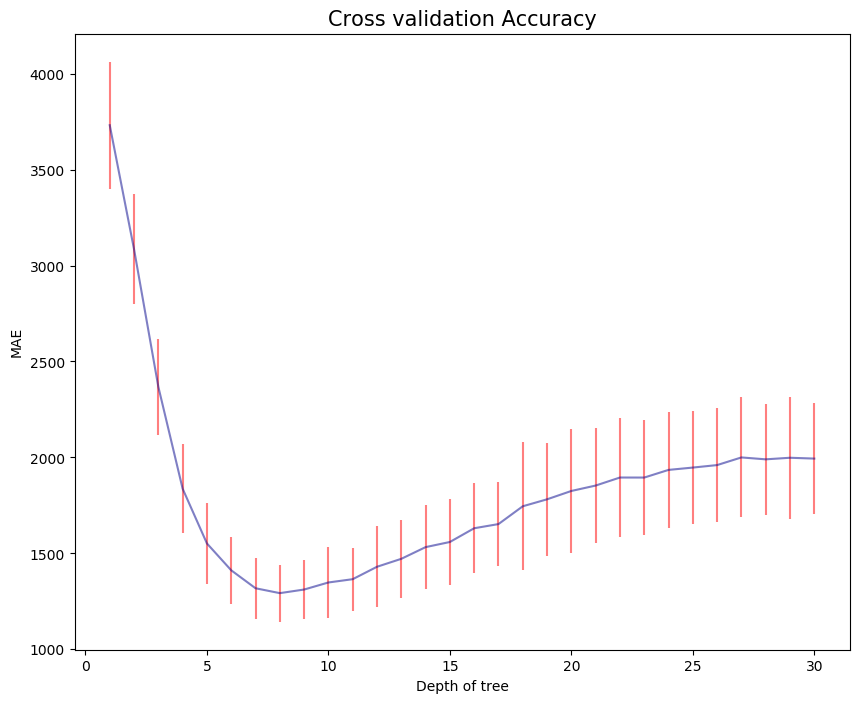

In [264]:
plt.figure(figsize=(10,8))

# Store results of object gridsearch_cv : 
results = pd.DataFrame(grid_cv.cv_results_)
results['mean_test_score'] = np.abs(results['mean_test_score'])
max_depth = results['param_max_depth']


plt.errorbar(x=max_depth, y=results['mean_test_score'], yerr=results['std_test_score'],color='darkblue',ecolor='red',alpha=0.5)

plt.title('Cross validation Accuracy',size=15)
plt.ylabel('MAE')
plt.xlabel('Depth of tree')

plt.show()

From the plot here, I see that a depth of the tree from 7 to 10 is optimal on my cross validated sets if we consider variability of validation score.

I do not have the train error the GridSearchCV object. As I want to see the overfitting issue of increasing the complexity of the tree, I will also train and evaluate the model on a fixed train/validation set :

In [265]:
# Define a set of max depth values
k_values = np.arange(1, 36, 1)


# Accuracy on the train/test sets
train_curve = []
valid_curve = []

for k in k_values:
    # Create a pipeline
    pipe = Pipeline([
        
        # Create k-NN estimator and set its k value
        ('dt', DecisionTreeRegressor(criterion='mse', max_depth=k, random_state=0))
    ])

    # Fit k-NN
    pipe.fit(X_tr, y_tr)

    # Compute train/test accuracy
    
    # Accuracy on the test set
    y_pred_dt = np.expm1(pipe.predict(X_valid))
    valid_acc = mae(np.expm1(y_valid),y_pred_dt)
    
    y_pred_dt = np.expm1(pipe.predict(X_tr))
    train_acc = mae(np.expm1(y_tr),y_pred_dt)
    
    # Save accuracy values
    train_curve.append(train_acc)
    valid_curve.append(valid_acc)

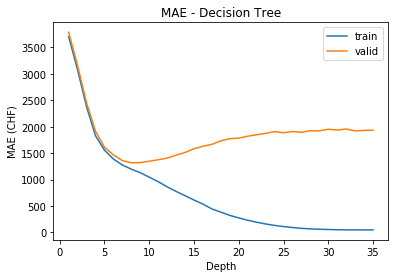

In [266]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot validation curves
plt.title('MAE - Decision Tree')
plt.plot(k_values, train_curve, label='train')
plt.plot(k_values, valid_curve, label='valid')
plt.xlabel('Depth')
plt.ylabel('MAE (CHF)')
plt.legend()
plt.show()

In [198]:
# Create decision tree
dt = DecisionTreeRegressor(
    criterion='mse', max_depth=8, random_state=0)
dt.fit(X_tr, y_tr)

# Accuracy on the validation set
y_pred_dt = np.expm1(dt.predict(X_valid))
valid_acc = mae(np.expm1(y_valid),y_pred_dt)

print('Accuracy on validation set : ',np.round(valid_acc,0))

Accuracy on validation set :  1318.0


In [199]:
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_pred_dt.sum()))
print('Sum of true Cumulative Payment at time 1 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 1 on validation set : 114356853.0
Sum of true Cumulative Payment at time 1 on validation set :  130251025.0


In [ ]:
from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    feature_names=X_tr.columns, 
    filled=True, rounded=True, proportion=True   
)

#fOR later, cannot make that work.

In [269]:
dt_imp = pd.DataFrame(X_tr.columns, columns=['Features'])
dt_imp['Importance']=np.round(dt.feature_importances_,3)
dt_imp.sort_values(by='Importance',ascending=False).head(10)

,Features,Importance
4,PayCum00,0.812
25,LoB_2,0.073
26,LoB_3,0.072
2,age,0.025
10,inj_2,0.005
7,Paid_Prop00,0.004
8,inj_0,0.003
15,inj_7,0.002
1,AQ,0.002
0,AY,0.001


### Random Forest 

I will use GridSeachCV in order to test my loss function for different parameters using a stratified 10 fold validation set.

<br> Unlike a single decision tree which uses the entire dataset to split the data, RF regressor offer the possibility to randomly partitions the original dataset and divides thoses partitions amoung several decisions trees. This is done which the **boostrap** parameter=True/False. If it is set to false, each tree in the RF will use the full dataset. I will test this parameter to see if random variation in each tree by only selecting a subset of the original dataset increases my evaluation score.<br>
<br> Another source of variation in each decision tree is the number of features used in each tree. The random forest randomly choose a subset of the features. I will test the **max_features parameter** which choose the number of features to be randomly allocated to each tree.

<br> As the grid is quite large, I will use only 10k datapoints here.

In [69]:
print('Number of features :  ',len(X.columns))
print('Floor of Square root nb of features : ',np.trunc(np.sqrt(len(X.columns))))
print('Floor of Log2 nb of features : ',np.trunc(np.log2(len(X.columns))))

Number of features :   28
Floor of Square root nb of features :  5.0
Floor of Log2 nb of features :  4.0


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

estimator = RandomForestRegressor()
para_grids = {
            "n_estimators" : [10,50,80,150,250],
            "max_features" : ["log2", "sqrt"],
            "bootstrap"    : [True, False]
        }

grid_cv = GridSearchCV(estimator, para_grids, scoring=make_scorer(MAE, greater_is_better=True),cv=10,n_jobs=-1)
grid_cv.fit(X[0:10000], y[0:10000])

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 80, 150, 250], 'max_features': ['log2', 'sqrt'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(MAE), verbose=0)

In [73]:
import pandas as pd

# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('N_estimators', grid_cv.cv_results_['param_n_estimators']),
    ('Max_features', grid_cv.cv_results_['param_max_features']),
    ('Bootstrap', grid_cv.cv_results_['param_bootstrap']),
    ('mean_te', grid_cv.cv_results_['mean_test_score']),
    ('std_te', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean_te', ascending=True).head(10)

,N_estimators,Max_features,Bootstrap,mean_te,std_te
9,250,sqrt,True,1508.013794,265.478558
8,150,sqrt,True,1510.397357,250.789115
7,80,sqrt,True,1511.004772,244.576939
18,150,sqrt,False,1518.819435,242.644911
6,50,sqrt,True,1523.506711,255.548703
19,250,sqrt,False,1524.508375,250.852381
17,80,sqrt,False,1535.395880,237.660865
16,50,sqrt,False,1559.756547,251.906841
5,10,sqrt,True,1618.984308,221.731508
4,250,log2,True,1652.908932,279.555079


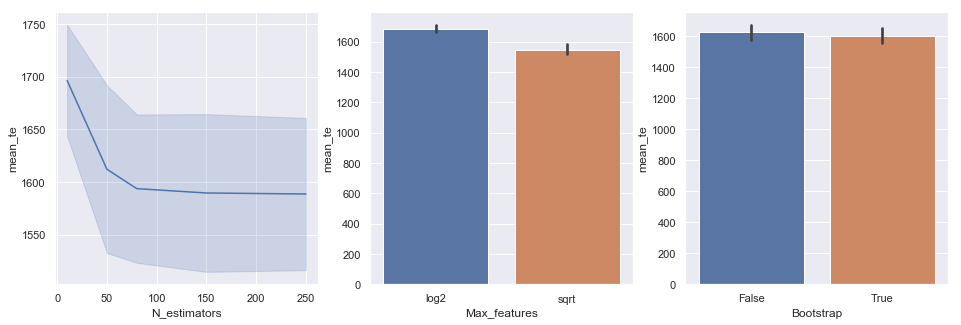

In [74]:
f, (ax1, ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(16,5))

plt.subplot(1, 3, 1)
sns.lineplot(x='N_estimators',y='mean_te',data=df)
#plt.plot(df['N_estimators'], df['mean_te'])
plt.subplot(1, 3, 2)
sns.barplot(x='Max_features',y='mean_te',data=df)

plt.subplot(1, 3, 3)
sns.barplot(x='Bootstrap',y='mean_te',data=df)
plt.show()

From the results obtained, we can observe that adding variation in the different trees by boostrapping the original dataset increases the performance on the cross validated sets. The default parameter of max_features which chooses srt(N) features at each tree, increases the performance as well. From those observations, I will just gridsearch the number of trees while keeping the other two parameters as default on the whole dataset.

In [75]:
estimator = RandomForestRegressor(max_depth=None)
para_grids = {
            "n_estimators" : [50,80,150,300,500]#,200,300,500,1000] 
        }


grid_cv = GridSearchCV(estimator, para_grids, scoring=make_scorer(MAE, greater_is_better=True),cv=10,n_jobs=-1)
grid_cv.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 80, 150, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(MAE), verbose=0)

In [76]:
# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('N_estimators', grid_cv.cv_results_['param_n_estimators']),
    ('fit_time', grid_cv.cv_results_['mean_fit_time']),
     ('score_time', grid_cv.cv_results_['mean_score_time']),
    ('mean_te', grid_cv.cv_results_['mean_test_score']),
    ('std_te', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean_te', ascending=True)

,N_estimators,fit_time,score_time,mean_te,std_te
4,500,245.776411,1.602512,1279.492865,148.716034
3,300,175.503001,1.495459,1280.516635,148.173246
2,150,87.932129,0.727376,1281.404009,146.830342
1,80,46.917915,0.388629,1285.287434,147.108139
0,50,30.007078,0.273274,1288.918862,152.234850


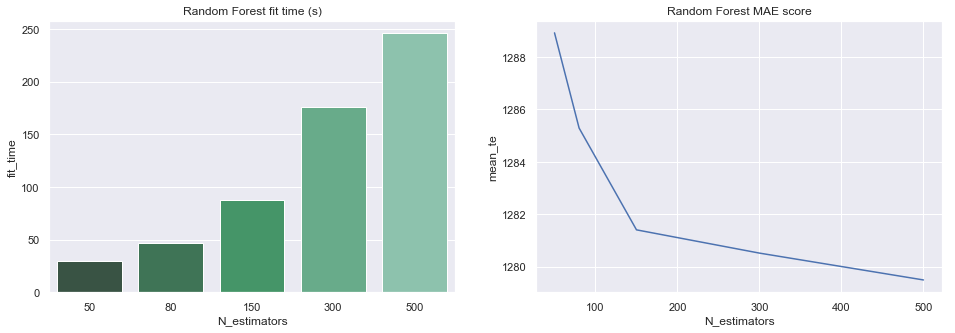

In [77]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))

plt.subplot(1, 2, 1)
plt.title('Random Forest fit time (s)')
sns.barplot(x='N_estimators',y='fit_time', palette="BuGn_d",data=df.sort_values(by='fit_time',ascending=False))

plt.subplot(1,2,2)
plt.title('Random Forest MAE score')
sns.lineplot(x='N_estimators',y='mean_te',data=df)
plt.show()

When consideration the training time, training a RF Regressor with 300 trees seems to be a good tradeoff.

In [78]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=300, max_depth=None, random_state=0,n_jobs=-1)
# Fit estimator
rf.fit(X_tr, y_tr)

# Accuracy on the test and validation set
y_te_rf_00 = np.expm1(rf.predict(X_te))
y_valid_rf = np.expm1(rf.predict(X_valid))

mae_rf_valid = mae(np.expm1(y_valid),y_valid_rf)
mae_rf_te = mae(np.expm1(y_te),y_te_rf_00)

print(mae_rf_valid)
print(mae_rf_te)

1314.3276535231612
1548.3641979978484


In [79]:
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_valid_rf.sum()))
print('Sum of true Cumulative Payment at time 1 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 1 on validation set : 116003521.0
Sum of true Cumulative Payment at time 1 on validation set :  130251025.0


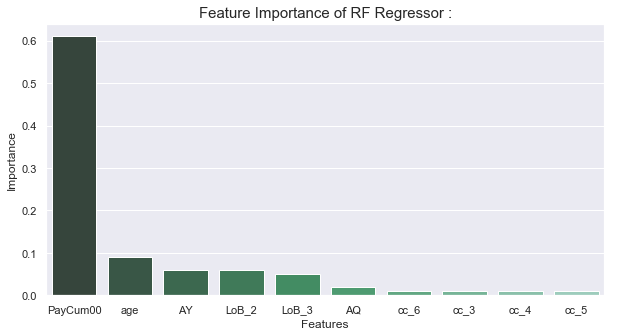

In [80]:
rf_imp = pd.DataFrame(X_tr.columns, columns=['Features'])
rf_imp['Importance']=np.round(rf.feature_importances_,2)
rf_imp_reg_top10 = rf_imp.sort_values(by='Importance',ascending=False).head(10)


plt.figure(figsize=(10,5))
plt.title('Feature Importance of RF Regressor :',size=15)
sns.barplot(x='Features',y='Importance', palette="BuGn_d",data=rf_imp_reg_top10 )
plt.show()

In [ ]:
sns.lmplot(x="PayCum00", y="PayCum01", hue="Open00", data=data[0:20000],size=6,scatter_kws={"s": 7})
plt.title('Relation between Payment at dev 0 & 1')
plt.show()

In [ ]:
sns.lmplot(x="PayCum00", y="PayCum01", hue="AQ", data=data[0:40000],size=6,scatter_kws={"s": 7})
plt.title('Relation between Payment at dev 0 & 1')
plt.show()

Let's define a function which computes a prediction interval depending on the quantile of the predictions found in the different decision trees : will do it for 50 trees only because of the computing time.

In [81]:
def pred_ints(model, X, percentile):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(np.expm1(pred.predict(X_te.iloc[x,:][:,np.newaxis].reshape(1,28))))
        #Define a 50% quantile as the lower limit
        err_down.append(np.quantile(preds, 1-percentile ))
        #Define a percentile > 0.5 to be the upper limit
        err_up.append(np.quantile(preds, percentile))
    return err_down, err_up

In [82]:
rf = RandomForestRegressor(
    n_estimators=50, max_depth=None, random_state=0,n_jobs=-1)

# Fit estimator
rf.fit(X_tr, y_tr)

#Computes the quantile 0.5 of the predictions as a lower interval and the 0.75 quantile as the upper limit :
err_down, err_up = pred_ints(rf, X_te, percentile=0.75) 

In [83]:
print('25 Quantile Predictions in decision trees :, ', np.sum(err_down))

25 Quantile Predictions in decision trees :,  41887989.90406664


In [84]:
print('75 Quantile Predictions in decision trees :, ', np.sum(err_up))

75 Quantile Predictions in decision trees :,  63106097.40123164


In [85]:
truth = np.expm1(y_te)
correct = 0.
for i, val in enumerate(truth):
    if err_down[i] <= val <= err_up[i]:
        correct += 1
print('Proportion of test set value in the interval of the predictions',correct/len(truth))

Proportion of test set value in the interval of the predictions 0.31067656593119314


This proportion seems to be very low. I suspect it is because I predict the cost of claims which do not have a payment in the next year.

In [90]:
df_pred = pd.DataFrame(np.stack([err_up,err_down,np.expm1(X_te['PayCum00']),np.expm1(y_te)]).T,columns=['Q75%','Q25%','Pay00','Pay01'])
df_pred.head(10)

,Q75%,Q25%,Pay00,Pay01
0,1018.00,468.50,0.0,0.0
1,3179.00,1393.00,0.0,0.0
2,15700.25,883.00,0.0,2443.0
3,2729.00,305.00,0.0,651.0
4,650.00,596.00,319.0,319.0
5,627.50,91.25,0.0,3018.0
6,3820.00,3273.25,1967.0,3516.0
7,663.00,628.00,343.0,716.0
8,334.25,187.50,0.0,556.0
9,6503.00,1161.00,0.0,0.0


Here I look at a subset of 50 claims which have a larger cumulative payment at time 1 than 100k CHF. <br> For some claims, I see that my true values falls in my interval predictions or are not too far. 
For some claims (e.g. first one on the left), my prediction interval is constrained to the payment at time 0 and hence underestimates in many cases.

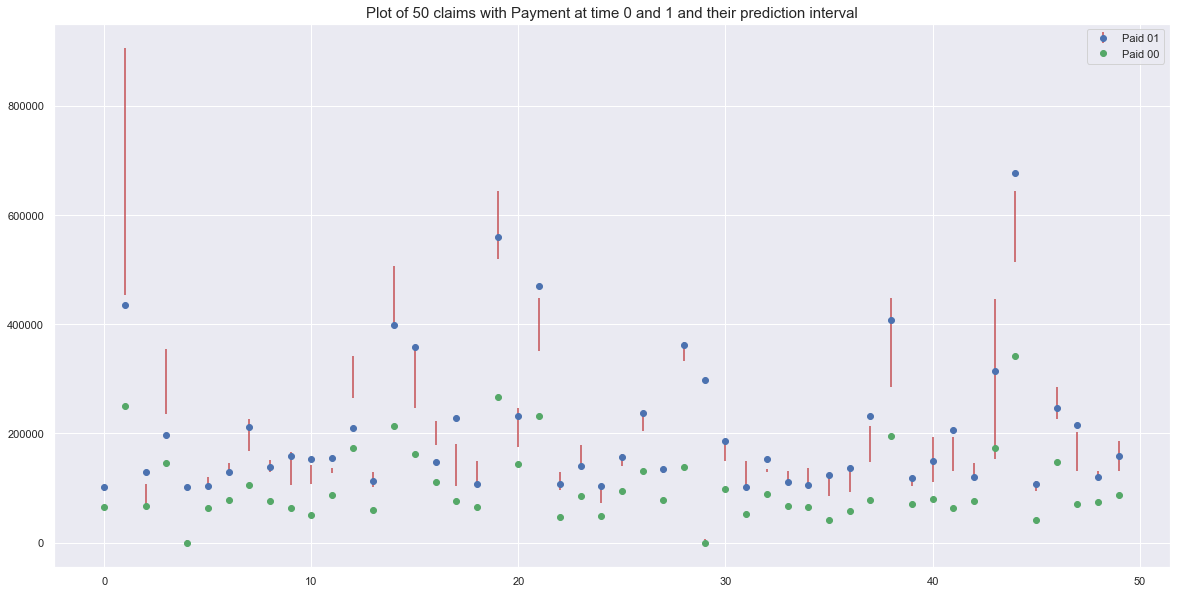

In [91]:
plt.figure(figsize=(20,10))
lim=100000
n=50
plt.title('Plot of 50 claims with Payment at time 0 and 1 and their prediction interval',size=15)
lower_error = df_pred[df_pred['Pay01']>lim]['Pay01'][0:n] - df_pred[df_pred['Pay01']>lim]['Q25%'][0:n]
upper_error = df_pred[df_pred['Pay01']>lim]['Q75%'][0:n] - df_pred[df_pred['Pay01']>lim]['Pay01'][0:n]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(np.arange(0,n,1),df_pred[df_pred['Pay01']>lim]['Pay01'][0:n],fmt='o',yerr=asymmetric_error,ecolor='r',label='Paid 01')
plt.errorbar(np.arange(0,n,1),df_pred[df_pred['Pay01']>lim]['Pay00'][0:n],fmt='o',c='g',label='Paid 00')
plt.legend(loc='best')
plt.show()

Visualise Decision Tree Predictions based on one feature

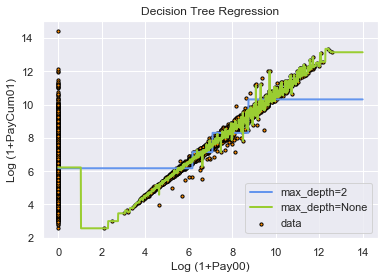

In [95]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=None)
regr_1.fit(X_tr['PayCum00'][:, np.newaxis][0:8000], y_tr[0:8000])
regr_2.fit(X_tr['PayCum00'][:, np.newaxis][0:8000], y_tr[0:8000])

# Predict
X_test = np.arange(0, 14, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X_tr['PayCum00'][0:8000], y_tr[0:8000], s=10, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=None", linewidth=2)
plt.xlabel("Log (1+Pay00)")
plt.ylabel("Log (1+PayCum01)")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Plotting a decision tree regression based on the predominant feature which reduces the variance of predictions, I can see that a max leaf tree overfits and also that the model fails to predict well 0 cashout claims at development year 0.

### AdaBoost Regressor

In [96]:
from sklearn.ensemble import AdaBoostRegressor

Ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),
    n_estimators=200, random_state=0,learning_rate=0.05)

# Fit estimator
Ada.fit(X_tr, y_tr)

# Accuracy on the validation set
y_valid_ada = np.expm1(Ada.predict(X_valid))
mae_ada_valid = mae(np.expm1(y_valid),y_valid_ada)

# Accuracy on the test set
y_te_ada = np.expm1(Ada.predict(X_te))
mae_ada_te = mae(np.expm1(y_te),y_te_ada)


print('Validation accuracy is : ', np.round(mae_ada_valid,0))

Validation accuracy is :  1293.0


In [97]:
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_valid_ada.sum()))
print('Sum of true Cumulative Payment at time 1 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 1 on validation set : 114159013.0
Sum of true Cumulative Payment at time 1 on validation set :  130251025.0


In [98]:
ada_imp = pd.DataFrame(X_tr.columns, columns=['Features'])
ada_imp['Importance']=np.round(Ada.feature_importances_,2)
ada_imp.sort_values(by='Importance',ascending=False).head(10)

,Features,Importance
4,PayCum00,0.42
2,age,0.13
25,LoB_2,0.07
26,LoB_3,0.06
27,LoB_4,0.05
24,LoB_1,0.05
0,AY,0.04
8,inj_0,0.02
3,RepDel,0.02
23,cc_7,0.02


The weak learners only focus on 4 features disregarding the injury type, the activity sector and other features.

### Gradient Boosting

**Difference between Adaptive boosting and gradient boosting :**
<br>


This part is taken from the internet 
*****

Both are boosting algorithms which means that they convert a set of weak learners into a single strong learner. They both initialize a strong learner (usually a decision tree) and iteratively create a weak learner that is added to the strong learner. They differ on how they create the weak learners during the iterative process.

At each iteration, adaptive boosting changes the sample distribution by modifying the weights attached to each of the instances. It increases the weights of the wrongly predicted instances and decreases the ones of the correctly predicted instances. The weak learner thus focuses more on the difficult instances. After being trained, the weak learner is added to the strong one according to his performance (so-called alpha weight). The higher it performs, the more it contributes to the strong learner.
On the other hand, gradient boosting doesn’t modify the sample distribution. Instead of training on a newly sample distribution, the weak learner trains on the remaining errors (so-called pseudo-residuals) of the strong learner. It is another way to give more importance to the difficult instances. At each iteration, the pseudo-residuals are computed and a weak learner is fitted to these pseudo-residuals. Then, the contribution of the weak learner (so-called multiplier) to the strong one isn’t computed according to his performance on the newly distribution sample but using a gradient descent optimization process. The computed contribution is the one minimizing the overall error of the strong learner.
******************************

Default of boosting : Cannot be parallelised because of sequential models.

I will use many versions of gradient boosting, testing the different parameters (learning_rate, max_depth, alpha which is the mix between MAE and MSE for the huber loss and which is a quantile for the quantile loss) with different loss functions (huber and quantile regression).

<BR> I use here quantile regression with alpha (0.6,0.75) as my predictions seems to consistently underestimate the true payment at time 1 and because it is common in our work to situate our reserves at a some quantile.

I will use the huber loss of the Gradient Boosting Regressor as I know that I do have outliers in my training set. 
As I have already optimised the depth of an individual tree, I will concentrate on the alphas parameter which controls for the importance of outliers in the model. I also know that a large number of estimators must have a low learning rate in order to avoid overfitting. I will therefore search for some low learning rates with 300 weak learners (same as the RF regressor).

In [99]:
from sklearn.model_selection import ParameterGrid

alphas = np.arange(0.1,1,0.2)
learning_rates = [0.15,0.1,0.05,0.01]

# Define a grid of values
grid = ParameterGrid({
    'alpha': alphas,
    'learning_rate': learning_rates,
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 20


In [100]:
from sklearn.ensemble import GradientBoostingRegressor

import time
start_time = time.time()
# Accuracy on the train/test sets
train_scores = []
valid_scores = []


gbr = GradientBoostingRegressor(loss='huber',
                                n_estimators=300, max_depth=8
                               )

for params_dict in grid:
    # Set parameters
    gbr.set_params(**params_dict)



    # Fit estimator
    gbr.fit(X_tr[0:10000], y_tr[0:10000])

    # Accuracy on train set
    y_train_gbr = np.expm1(gbr.predict(X_tr))
    params_dict['accuracy_train'] = mae(np.expm1(y_tr),y_train_gbr)

    # Accuracy on validation set
    y_valid_gbr = np.expm1(gbr.predict(X_valid))
    params_dict['accuracy_valid'] = mae(np.expm1(y_valid),y_valid_gbr)
    

    # Save accuracy values
    train_scores.append(params_dict)
    valid_scores.append(params_dict)
    
elapsed_time = time.time() - start_time
print('Gradient Boosting Model trained and evaluated for 20 combinaisons of hyperparameters in :',np.round(elapsed_time),'seconds')

Gradient Boosting Model trained and evaluated for 20 combinaisons of hyperparameters in : 274.0 seconds


In [101]:
# Create DataFrame with valid scores
scores_df = pd.DataFrame(valid_scores)
scores_df['alpha'] = np.round(scores_df['alpha'],2) 
# Top ten scores
scores_df_top10 = scores_df.sort_values(by='accuracy_valid', ascending=True).head()
scores_df_top10

,accuracy_train,accuracy_valid,alpha,learning_rate
2,1238.504842,1364.845032,0.1,0.05
6,1242.275603,1387.898680,0.3,0.05
10,1232.284107,1393.755846,0.5,0.05
5,1238.711883,1400.962794,0.3,0.10
1,1257.437775,1404.217128,0.1,0.10


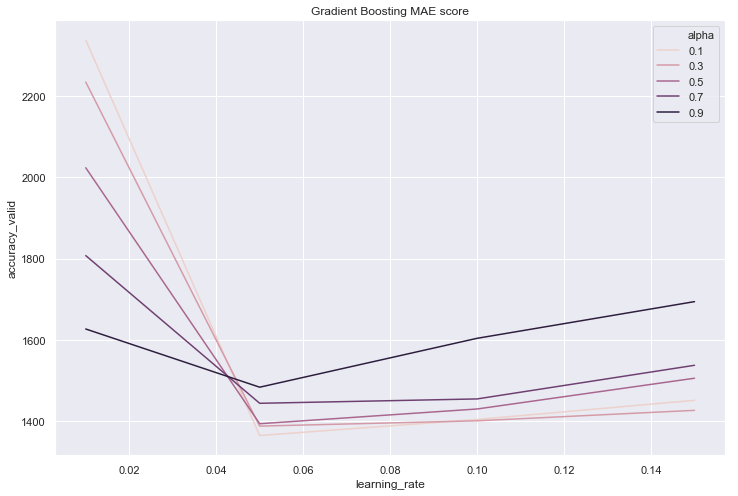

In [102]:
plt.figure(figsize=(12,8))

plt.title('Gradient Boosting MAE score')
sns.lineplot(x='learning_rate',y='accuracy_valid',data=scores_df,hue='alpha',legend="full")
plt.show()

From the plot we can see that the higher the alpha, the less sensitive is the MAE score to the learning rate. I do not have the explanation for now. We can also see that a learning rate of 0.05 minimises the MAE score, independently of the regularisation parameter. I will choose a learning rate of 0.05 and a regularisation strengh of 0.3 from this plot.

Fit the tuned Gradient Boosting Regressor on the whole training set and evaluate validation and test performance :

In [106]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(loss='huber',alpha=0.1,
                                n_estimators=300, max_depth=8,learning_rate=0.05
                               )

# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on validation set
y_valid_gbr = np.expm1(gbr.predict(X_valid))
mae_gbr_valid = mae(np.expm1(y_valid),y_valid_gbr)

# Accuracy on test set
y_te_gbr_01 = np.expm1(gbr.predict(X_te))
mae_gbr_te = mae(np.expm1(y_te),y_te_gbr_01)

In [107]:
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_valid_gbr.sum()))
print('Sum of true Cumulative Payment at time 1 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 1 on validation set : 111666599.0
Sum of true Cumulative Payment at time 1 on validation set :  130251025.0


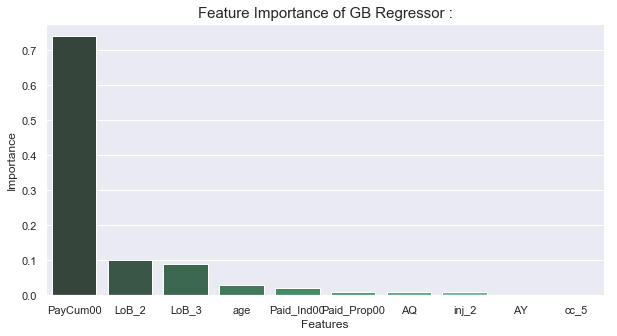

In [108]:
gbr_imp = pd.DataFrame(X_tr.columns, columns=['Features'])
gbr_imp['Importance']=np.round(gbr.feature_importances_,2)
gb_imp_reg_top10 = gbr_imp.sort_values(by='Importance',ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.title('Feature Importance of GB Regressor :',size=15)
sns.barplot(x='Features',y='Importance', palette="BuGn_d",data=gb_imp_reg_top10 )
plt.show()

I will also use the quantile loss function which is defined in the Gradident Boosting Regressors which allows me to have a prediction interval for each claim : 

In [201]:
gbr = GradientBoostingRegressor(loss='quantile',alpha=0.75,
                                n_estimators=300, max_depth=8,learning_rate=0.05
                               )

# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on validation set
y_valid_upp = np.expm1(gbr.predict(X_valid))
mae_upp_valid = mae(np.expm1(y_valid),y_valid_upp)

# Accuracy on test set
y_te_upp = np.expm1(gbr.predict(X_te))
mae_upp_te = mae(np.expm1(y_te),y_te_upp)

print('Quantile regression with quantile Q=75% fitted and evaluated')
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_valid_upp.sum()))

gbr.set_params(alpha=0.6)

# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on validation set
y_valid_down = np.expm1(gbr.predict(X_valid))
mae_down_valid = mae(np.expm1(y_valid),y_valid_down)

# Accuracy on test set
y_te_down = np.expm1(gbr.predict(X_te))
mae_down_te = mae(np.expm1(y_te),y_te_down)

print('Quantile regression with quantile Q=60% fitted and evaluated')
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_valid_down.sum()))

Quantile regression with quantile Q=75% fitted and evaluated
Sum of predicted Cumulative Payment at time 1 on validation set : 131182655.0
Quantile regression with quantile Q=60% fitted and evaluated
Sum of predicted Cumulative Payment at time 1 on validation set : 118445728.0


### Recapitulation of Regressor models and their performance :

MAE scores :

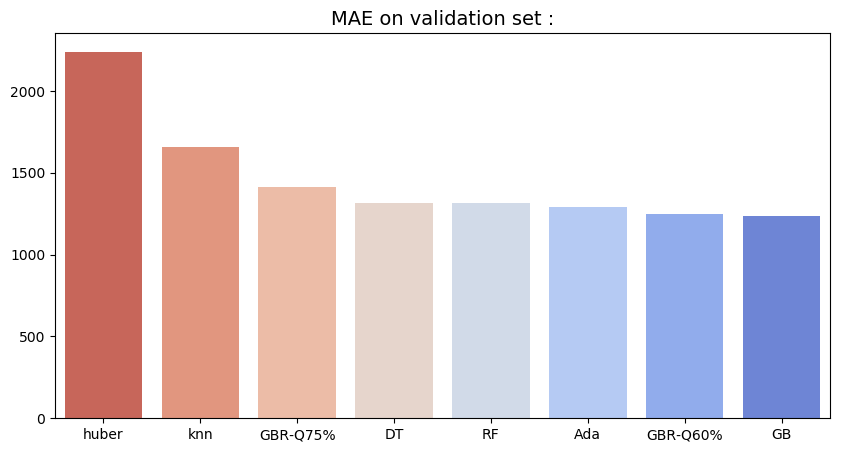

In [134]:
regressors = ['huber','knn','GBR-Q75%','DT','RF','Ada','GBR-Q60%','GB']
maes = []
plt.figure(figsize=(10,5))
plt.title('MAE on validation set :',size=14)
maes=[mae_valid_huber,mae_knn_valid,mae_upp_valid,valid_acc,mae_rf_valid,mae_ada_valid,mae_down_valid,mae_gbr_valid]
sns.barplot(regressors,maes,palette='coolwarm_r')
plt.show()

From what I see here, the boosting algorithms reduce my loss function best. I will also have a look at the cumulative paid amount predicted by my regressors because it is finally what I am interested in.

In [136]:
y_valid_final = data[data['AY']!=2005].loc[X_valid.index,:][['LoB','AY','cc','inj_part','PayCum00','PayCum01']]
y_valid_final['y_huber'] = np.round(y_valid_huber)
y_valid_final['y_knn'] = np.round(y_pred_knn)
y_valid_final['y_rf'] = np.round(y_valid_rf)
y_valid_final['y_ada'] = np.round(y_valid_ada)
y_valid_final['y_gbr'] = np.round(y_valid_gbr)
y_valid_final['y_gbr-Q60%'] = np.round(y_valid_down)
y_valid_final['y_gbr-Q75%'] = np.round(y_valid_upp)
y_valid_final.head()

,LoB,AY,cc,inj_part,PayCum00,PayCum01,y_huber,y_knn,y_rf,y_ada,y_gbr,y_gbr-Q60%,y_gbr-Q75%
153629,4,1997,41,70,1914,2895,2636.0,3498.0,2811.0,2809.0,2833.0,2794.0,2855.0
456042,2,2004,17,64,3764,4954,11764.0,5699.0,5693.0,5662.0,6015.0,5963.0,6184.0
183683,4,1998,6,21,1495,2163,1991.0,1399.0,2225.0,2119.0,2140.0,2143.0,2186.0
398885,4,2003,44,50,934,1750,1297.0,1533.0,1942.0,1730.0,1906.0,1953.0,1972.0
143848,4,1997,48,24,424,798,820.0,1090.0,691.0,680.0,683.0,682.0,701.0


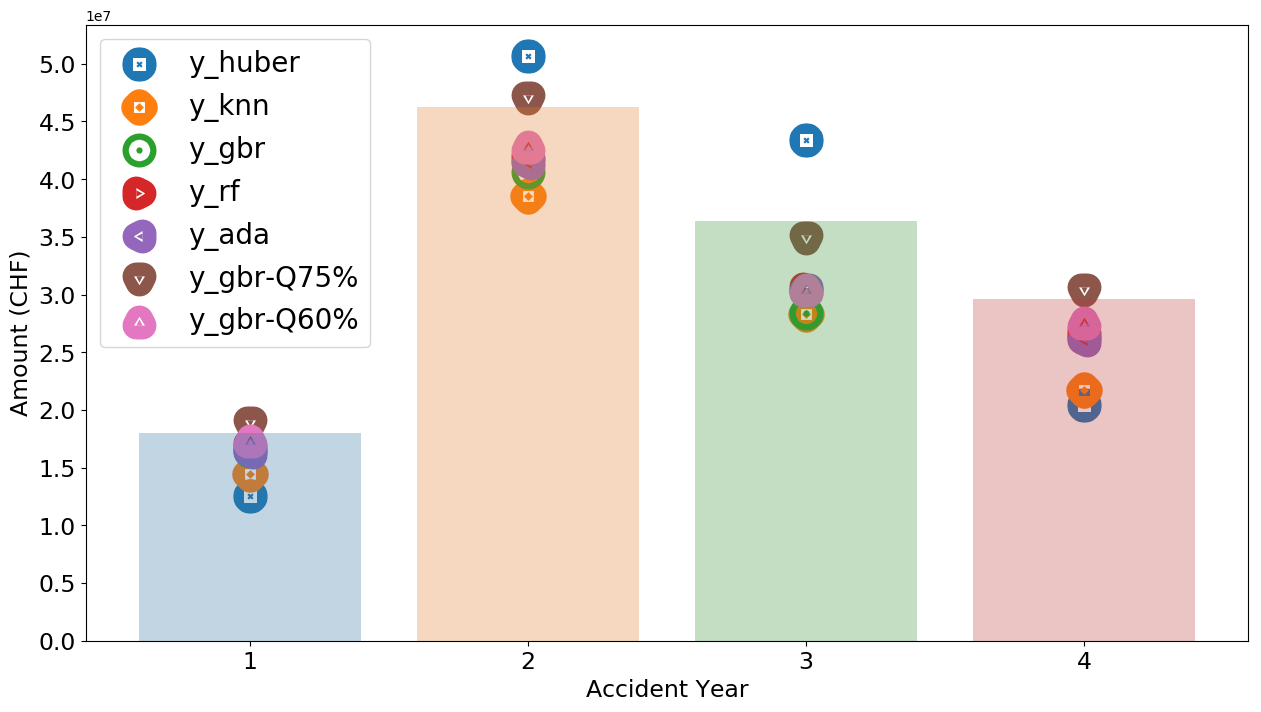

In [140]:
y_valid_group = y_valid_final.groupby('LoB')['PayCum01','y_huber','y_knn','y_rf','y_ada','y_gbr','y_gbr-Q60%','y_gbr-Q75%'].sum()
plt.figure(figsize=(15,8))
sns.barplot(x='LoB',y='PayCum01',data=y_valid_group.reset_index(),alpha=0.3)
plt.scatter(np.arange(0,4,1),y_valid_group['y_huber'],marker='X',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_valid_group['y_knn'],marker='D',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_valid_group['y_gbr'],marker='o',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_valid_group['y_rf'],marker='>',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_valid_group['y_ada'],marker='<',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_valid_group['y_gbr-Q75%'],marker='v',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_valid_group['y_gbr-Q60%'],marker='^',s=20,linewidths=20)

#Arange graph :
plt.legend(loc='best',prop={'size': 20})
plt.xticks(size=17)
plt.xlabel('Accident Year',size=17)
plt.yticks(np.linspace(0,50000000,11),size=17)
plt.ylabel('Amount (CHF)',size=17)
plt.show()
plt.show()

**Observations:**
- The huber loss over estimates the payment of Line 2 and 3 which have to lowest proportion in my training set.
- The KNN does the worst job at predicting the aggregate claim amount because it is the almost the lowests in each LoB
- The GB Regressor with a quantile regression loss of Q=75% does the best at predicting the aggregate amount per LOB.
- The other boosting and bagging algorithm are always underestimating but seems to do a better job for LOB 1 and 4 than the other two.


- **I think the MAE is probably not the right function. The MAE of a RF regressor is very low but I cannot afford to predict 15M less on my validation set. In fact, underestimating has more severe consequence than overestimating. I have read that the RMLSE penalises more underestimation so I tried it on a DT Regressor but did not have really better results. At least the GBR allows me to penalise more underestimation.**

The reason under this underestimation is still unknown to me. The fact to add a classifier was a great idea because the underestimation on the regression part was lowered. I have tried to see if I have another distribution in my validation set from the test set for a particular feature to try to identity the reason but did not see anything anormal.

In [141]:
X_tr[['LoB_1','LoB_2','LoB_3','LoB_4']].sum()

LoB_1    23049.0
LoB_2     7337.0
LoB_3     7511.0
LoB_4    27999.0
dtype: float64

As the number of claims with 0 payment is important for LoB2 and LoB3, there is a lot less claims from those in my training, validation set. Could it be a reason why predictions seems to fit more LoB 1 and 4 ?

Plot the cumulative predicted vs True Paid Amount by Accident Year :

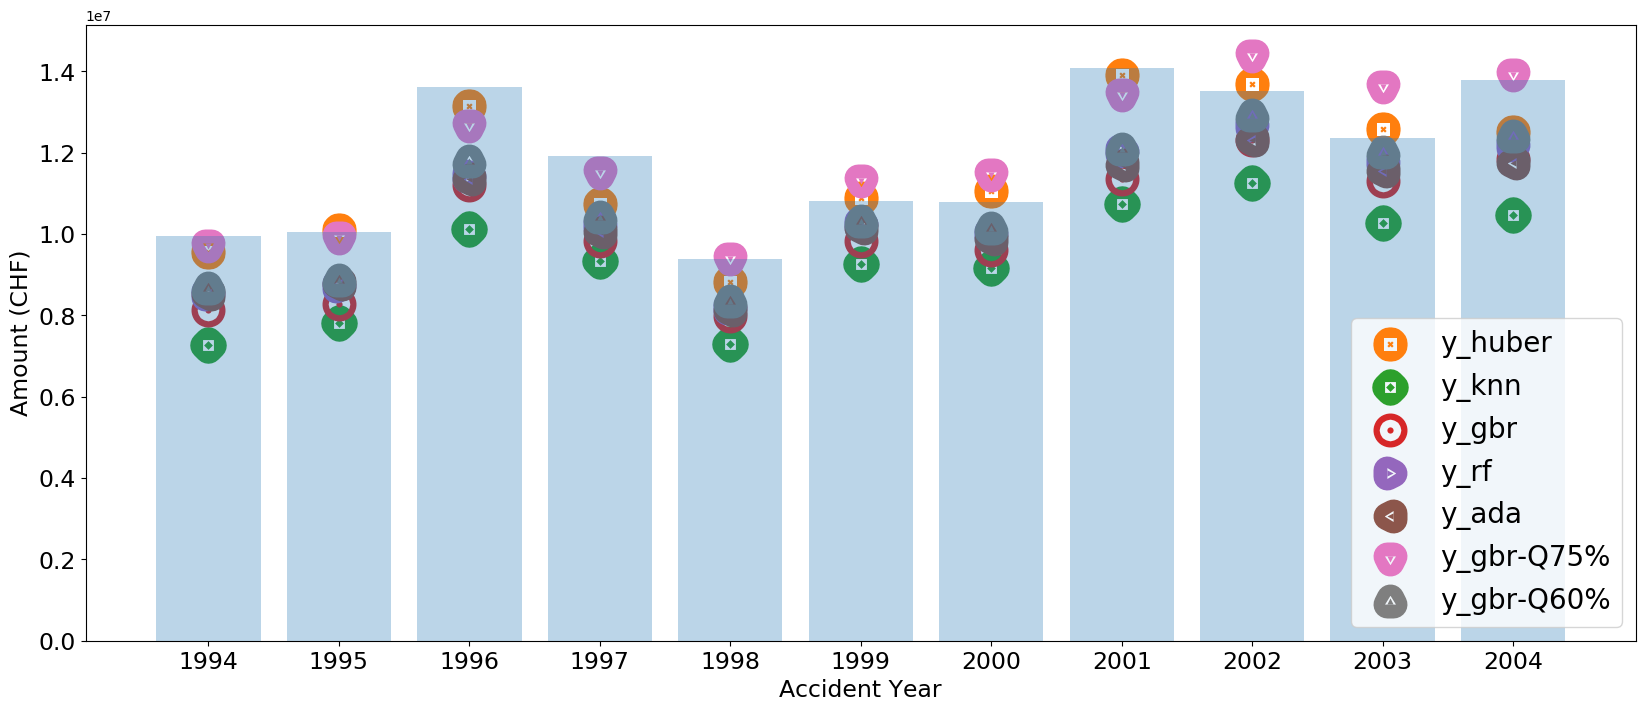

In [143]:
y_valid_group = y_valid_final.groupby('AY')['PayCum01','y_huber','y_knn','y_rf','y_ada','y_gbr','y_gbr-Q60%','y_gbr-Q75%'].sum()
plt.figure(figsize=(20,8))
plt.bar(X['AY'].unique(),y_valid_group['PayCum01'],alpha=0.3)
plt.scatter(X['AY'].unique(),y_valid_group['y_huber'],marker='X',s=20,linewidths=20)
plt.scatter(X['AY'].unique(),y_valid_group['y_knn'],marker='D',s=20,linewidths=20)
plt.scatter(X['AY'].unique(),y_valid_group['y_gbr'],marker='o',s=20,linewidths=20)
plt.scatter(X['AY'].unique(),y_valid_group['y_rf'],marker='>',s=20,linewidths=20)
plt.scatter(X['AY'].unique(),y_valid_group['y_ada'],marker='<',s=20,linewidths=20)
plt.scatter(X['AY'].unique(),y_valid_group['y_gbr-Q75%'],marker='v',s=20,linewidths=20)
plt.scatter(X['AY'].unique(),y_valid_group['y_gbr-Q60%'],marker='^',s=20,linewidths=20)

#Arange graph :
plt.legend(loc='best',prop={'size': 20})
plt.xticks(X['AY'].unique(),size=17)
plt.xlabel('Accident Year',size=17)
plt.yticks(np.linspace(0,14000000,8),size=17)
plt.ylabel('Amount (CHF)',size=17)
plt.show()

The underestimation probem seems to be on every Accident Year. I asked via the stratify argument to have the same proportion of claims in each AY. It does not seem to come from the fact that some AY have a smaller paid amount.

We can see that the Huber Regressor which does a bad job at predicting the Cumulative Amount Paid by Line of Business, does a good job at predicting by Accident Year.

Plot the cumulative predicted vs True Paid Amount by body part injured :

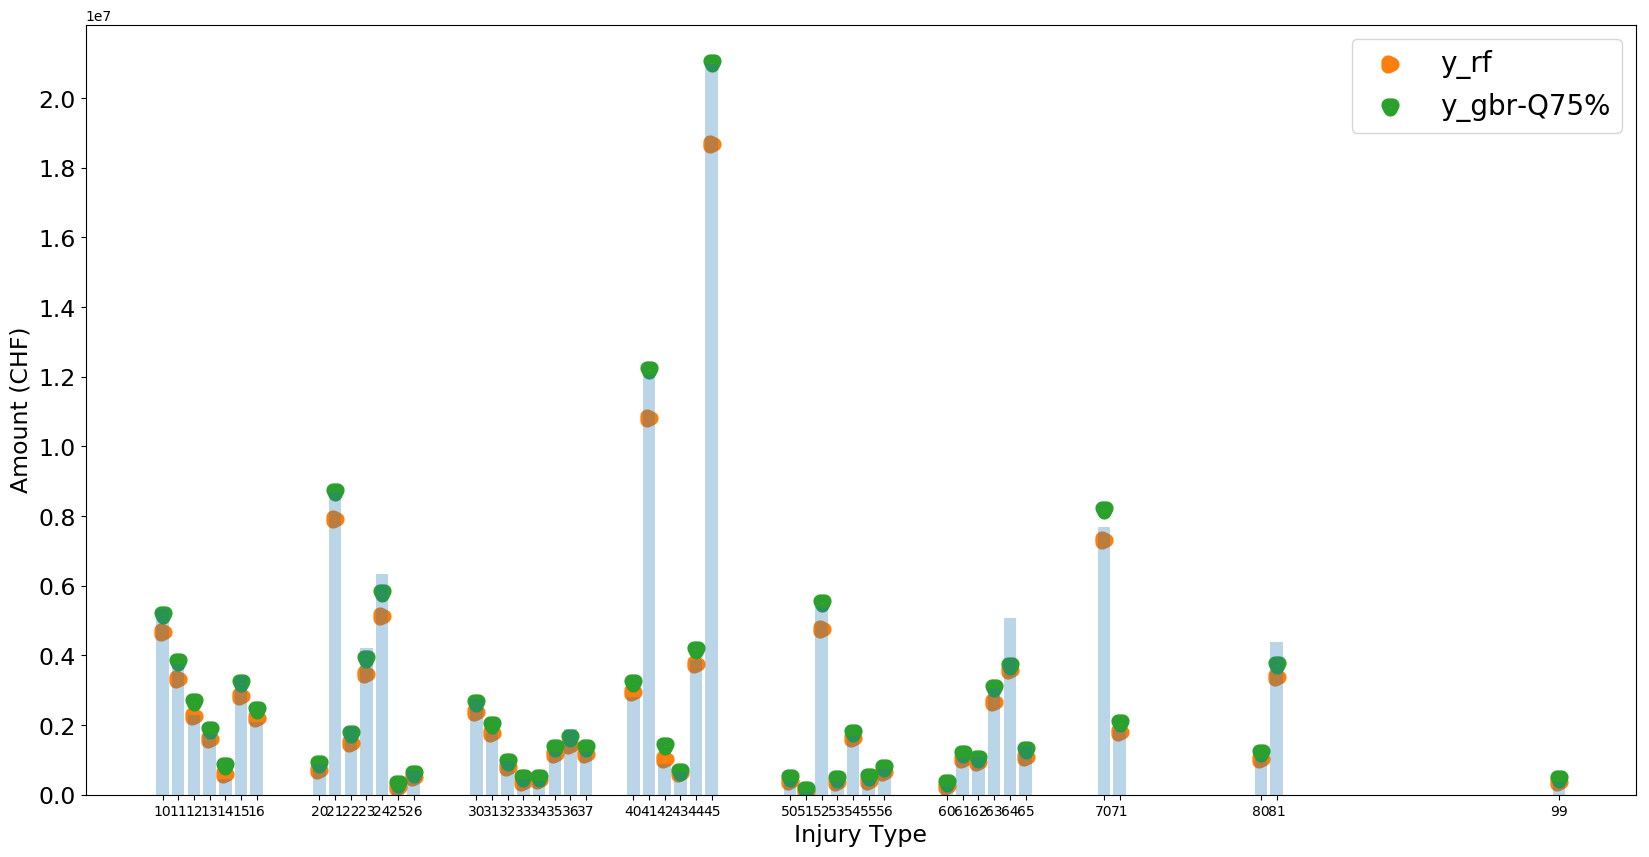

In [145]:
y_valid_group = y_valid_final.groupby('inj_part')['PayCum01','y_huber','y_knn','y_rf','y_ada','y_gbr','y_gbr-Q60%','y_gbr-Q75%'].sum()
plt.figure(figsize=(20,10))
plt.bar(data['inj_part'].unique(),y_valid_group['PayCum01'],alpha=0.3)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_huber'],marker='X',s=15,linewidths=15)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_knn'],marker='D',s=20,linewidths=20)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_gbr'],marker='o',s=10,linewidths=10)
plt.scatter(data['inj_part'].unique(),y_valid_group['y_rf'],marker='>',s=10,linewidths=10)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_ada'],marker='<',s=10,linewidths=10)
plt.scatter(data['inj_part'].unique(),y_valid_group['y_gbr-Q75%'],marker='v',s=10,linewidths=10)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_gbr-Q60%'],marker='^',s=20,linewidths=20)

#Arange graph :
plt.legend(loc='best',prop={'size': 20})
plt.xticks(data['inj_part'].unique(),size=10)
plt.xlabel('Injury Type',size=17)
plt.yticks(np.linspace(0,20000000,11),size=17)
plt.ylabel('Amount (CHF)',size=17)
plt.show()

Plot the cumulative predicted vs True Paid Amount by Activity sector :

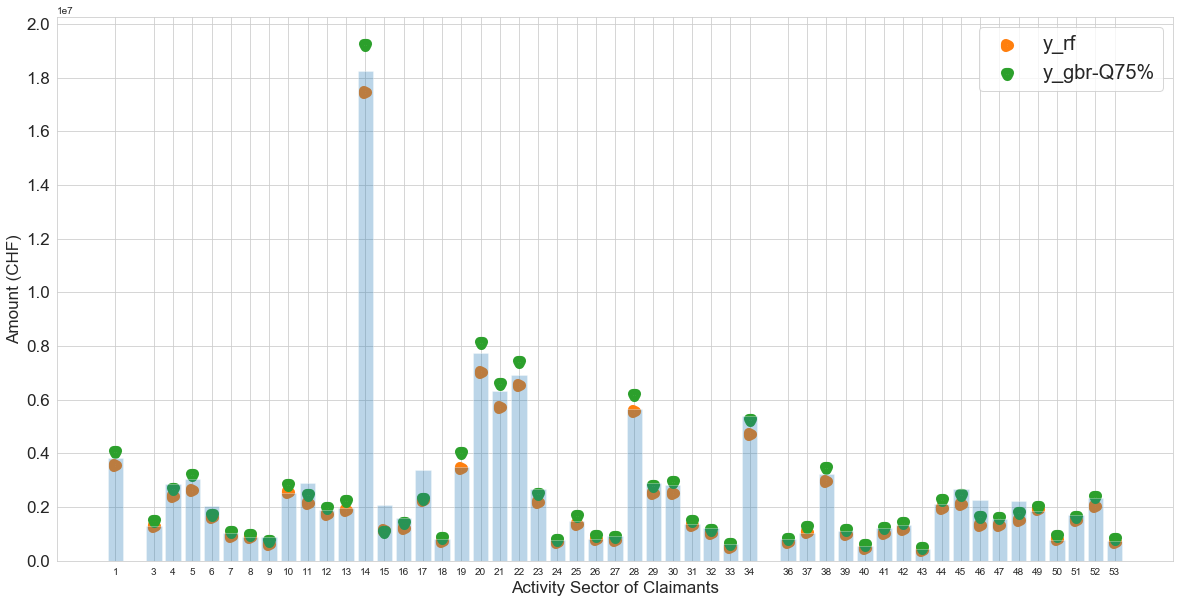

In [218]:
y_valid_group = y_valid_final.groupby('cc')['PayCum01','y_huber','y_knn','y_rf','y_ada','y_gbr','y_gbr-Q60%','y_gbr-Q75%'].sum()
plt.figure(figsize=(20,10))
plt.bar(data['cc'].unique(),y_valid_group['PayCum01'],alpha=0.3)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_huber'],marker='X',s=15,linewidths=15)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_knn'],marker='D',s=20,linewidths=20)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_gbr'],marker='o',s=10,linewidths=10)
plt.scatter(data['cc'].unique(),y_valid_group['y_rf'],marker='>',s=10,linewidths=10)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_ada'],marker='<',s=10,linewidths=10)
plt.scatter(data['cc'].unique(),y_valid_group['y_gbr-Q75%'],marker='v',s=10,linewidths=10)
#plt.scatter(data['inj_part'].unique(),y_valid_group['y_gbr-Q60%'],marker='^',s=20,linewidths=20)

#Arange graph :
plt.legend(loc='best',prop={'size': 20})
plt.xticks(data['cc'].unique(),size=10)
plt.xlabel('Activity Sector of Claimants',size=17)
plt.yticks(np.linspace(0,20000000,11),size=17)
plt.ylabel('Amount (CHF)',size=17)
plt.show()

### Evaluate Accuracy on test set

#### Of Regressor Alone : 

In addition to keep predicted payment values in my test set, I will keep a trace of True Claims with a Payment at time 1 in order to evaluate the performance of the regression model **alone**. I do it with my validation set already by passing only true payment values but I am interested at predicting what is in my test set.
<br> If I had a Classifier which would have an accuracy of 100% on unseen values (test set), how accurate would my regression model be ?

In [150]:
y_huber_teTrue = np.expm1(huber.predict(X_Paid01_te))
print('MAE due to Regressor Alone -HUBER:' , np.round(mae(y_huber_teTrue,np.expm1(y_Paid01_te))))

y_rf_teTrue = np.expm1(rf.predict(X_Paid01_te))
print('MAE due to Regressor Alone -RF: ',np.round(mae(y_rf_teTrue,np.expm1(y_Paid01_te))))

      
gbr = GradientBoostingRegressor(loss='quantile',alpha=0.75,
                                n_estimators=300, max_depth=8,learning_rate=0.05
                               )
# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on True test set
y_upp_teTrue = np.expm1(gbr.predict(X_Paid01_te))
print('MAE due to Regressor Alone -GBR 75%: ',np.round(mae(y_upp_teTrue,np.expm1(y_Paid01_te))))

#Fit GBR Q60%
gbr.set_params(alpha=0.6)
gbr.fit(X_tr, y_tr)

#Accuracy on True test set
y_down_teTrue = np.expm1(gbr.predict(X_Paid01_te))
print('MAE due to Regressor Alone -GBR Q60%: ',np.round(mae(y_down_teTrue,np.expm1(y_Paid01_te))))      


      
gbr = GradientBoostingRegressor(loss='huber',alpha=0.3,
                                n_estimators=300, max_depth=8,learning_rate=0.05
                               )
# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on True test set
y_gbr_teTrue = np.expm1(gbr.predict(X_Paid01_te))
print('MAE due to Regressor Alone -GBR : ',np.round(mae(y_gbr_teTrue,np.expm1(y_Paid01_te))))

MAE due to Regressor Alone -HUBER: 2576.0
MAE due to Regressor Alone -RF:  1420.0
MAE due to Regressor Alone -GBR 75%:  1487.0
MAE due to Regressor Alone -GBR Q60%:  1312.0
MAE due to Regressor Alone -GBR :  1270.0


In [151]:
y_teTrue_final = data[data['AY']==2005].loc[X_Paid01_te.index,:][['LoB','AY','cc','inj_part','PayCum00','PayCum01']]
y_teTrue_final['y_huber'] = np.round(y_huber_teTrue)
#y_valid_final['y_knn'] = np.round(y_pred_knn)
y_teTrue_final['y_rf'] = np.round(y_rf_teTrue)
#y_teTrue_final['y_ada'] = np.round(y_valid_ada)
y_teTrue_final['y_gbr'] = np.round(y_gbr_teTrue)
y_teTrue_final['y_gbr-Q60%'] = np.round(y_down_teTrue)
y_teTrue_final['y_gbr-Q75%'] = np.round(y_upp_teTrue)
y_teTrue_final.head()

,LoB,AY,cc,inj_part,PayCum00,PayCum01,y_huber,y_rf,y_gbr,y_gbr-Q60%,y_gbr-Q75%
457105,3,2005,49,53,0,2443,932.0,4164.0,3372.0,4099.0,5409.0
457108,4,2005,11,16,0,651,380.0,916.0,692.0,1126.0,1162.0
457120,4,2005,52,22,0,3018,329.0,303.0,450.0,514.0,766.0
457121,1,2005,10,35,1967,3516,2309.0,3591.0,3388.0,3448.0,3587.0
457123,1,2005,27,80,343,716,688.0,655.0,651.0,639.0,659.0


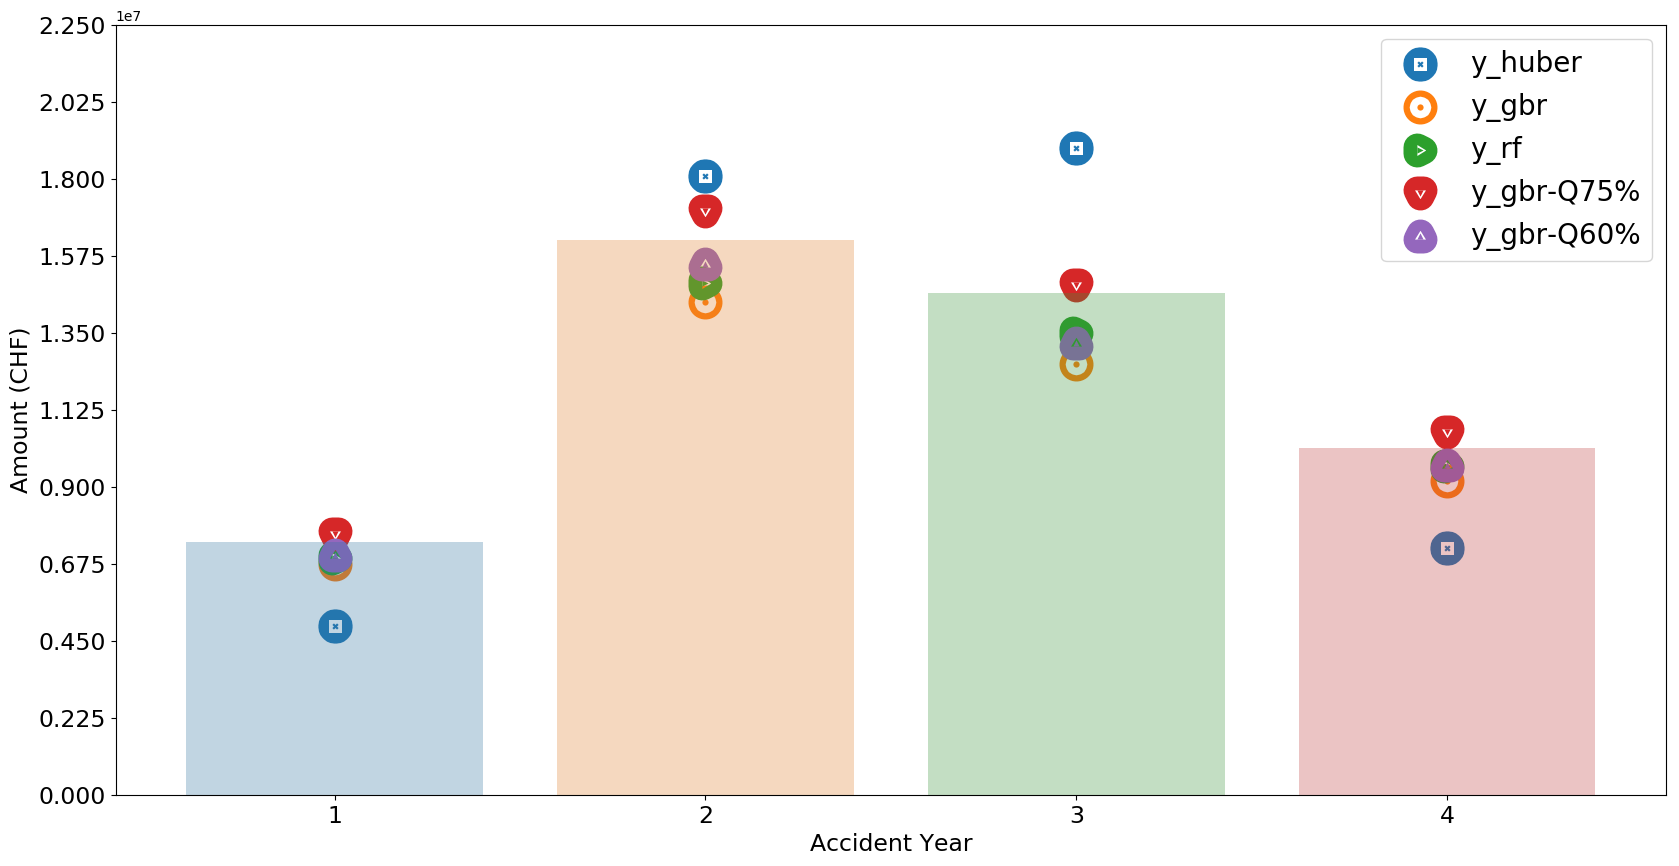

In [152]:
y_teTrue_group = y_teTrue_final.groupby('LoB')['PayCum01','y_huber','y_rf','y_gbr','y_gbr-Q60%','y_gbr-Q75%'].sum()
plt.figure(figsize=(20,10))
sns.barplot(x='LoB',y='PayCum01',data=y_teTrue_group.reset_index(),alpha=0.3)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_huber'],marker='X',s=20,linewidths=20)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_knn'],marker='D',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr'],marker='o',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_rf'],marker='>',s=20,linewidths=20)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_ada'],marker='<',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr-Q75%'],marker='v',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr-Q60%'],marker='^',s=20,linewidths=20)

#Arange graph :
plt.legend(loc='best',prop={'size': 20})
plt.xticks(size=17)
plt.xlabel('Accident Year',size=17)
plt.yticks(np.linspace(0,22500000,11),size=17)
plt.ylabel('Amount (CHF)',size=17)
plt.show()

In [153]:
print('Sum of predicted cumulative amount Paid at time 3 for claims with payment :' , np.sum(np.expm1(y_Paid01_te)))

Sum of predicted cumulative amount Paid at time 3 for claims with payment : 48370626.0


In [154]:
print('Sum of true Cumulative amount Paid at dev year 1 for claims with payment', np.round(y_upp_teTrue.sum()))

Sum of true Cumulative amount Paid at dev year 1 for claims with payment 50149225.0


#### Of Both Classifier and Regressor

In [155]:
print('MAE due to Regressor Alone -HUBER: ,', np.round(mae(np.expm1(huber.predict(X_te)),np.expm1(y_te))))
print('MAE due to Regressor Alone -RF: ,', np.round(mae_rf_te))
print('MAE due to Regressor Alone -GBR: ,', np.round(mae_gbr_te))
print('MAE due to Regressor Alone -GBR Q75%: ,', np.round(mae_upp_te))
print('MAE due to Regressor Alone -GBR Q65%: ,', np.round(mae_down_te))

MAE due to Regressor Alone -HUBER: , 2683.0
MAE due to Regressor Alone -RF: , 1548.0
MAE due to Regressor Alone -GBR: , 1377.0
MAE due to Regressor Alone -GBR Q75%: , 1802.0
MAE due to Regressor Alone -GBR Q65%: , 1489.0


In [156]:
df_pred_01 = data[data['AY'].isin(AY[11-model_number:])]
df_pred_01['pred'] = y_pred_01

print('Payment at time 0 for claims predicted as not having a payment at time =1 : ', df_pred_01[df_pred_01['pred']==False]['PayCum02'].sum())

Payment at time 0 for claims predicted as not having a payment at time =1 :  29669115


In [157]:
df_pred_01['pred_Ada'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(y_te_ada,index=y_te.index))
df_pred_01['pred_upp'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(y_te_upp,index=y_te.index))
df_pred_01['pred_rf'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(np.expm1(rf.predict(X_te)),index=y_te.index))
df_pred_01['pred_down'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(y_te_down,index=y_te.index))
df_pred_01['pred_Huber'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(np.expm1(huber.predict(X_te)),index=y_te.index))
df_pred_01['pred_KNN'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(np.expm1(pipe_knn.predict(X_KNN_te)),index=y_te.index))

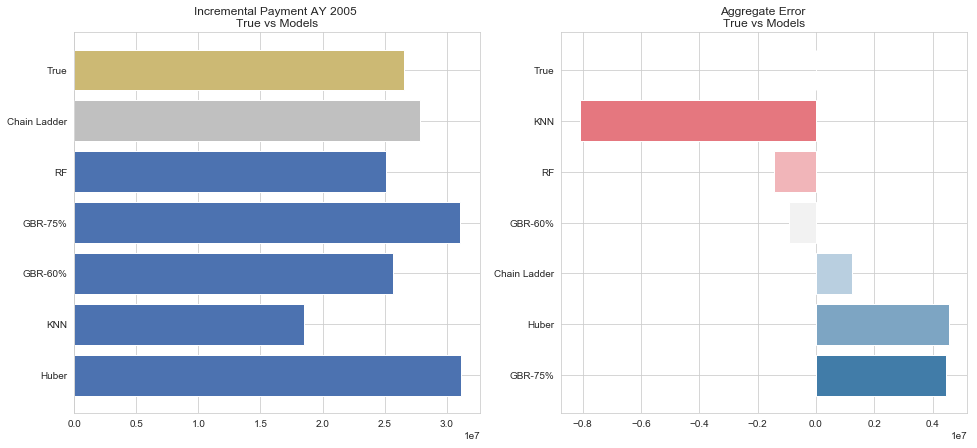

In [183]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.title('Incremental Payment AY 2005 \nTrue vs Models')
colors = ['b','b','b','b','b','silver','y']
plt.barh(['Huber','KNN','GBR-60%','GBR-75%','RF','Chain Ladder','True'], [df_pred_01['pred_Huber'].sum(),df_pred_01['pred_KNN'].sum(),df_pred_01['pred_down'].sum(),df_pred_01['pred_upp'].sum(),df_pred_01['pred_rf'].sum(),np.sum(dev_factor_df.loc[0,:]*Paid_obs_2005[-1]),df_pred_01['PayCum01'].sum()]-df_pred_01['PayCum00'].sum(),color=colors)

plt.subplot(1,2,2)
plt.title('Aggregate Error \nTrue vs Models')
colors = sns.diverging_palette(240, 10, n=7)
plt.barh(['GBR-75%','Huber','Chain Ladder','GBR-60%','RF','KNN','True'], [df_pred_01['pred_upp'].sum(),df_pred_01['pred_Huber'].sum(),np.sum(dev_factor_df.loc[0,:]*Paid_obs_2005[-1]),df_pred_01['pred_down'].sum(),df_pred_01['pred_rf'].sum(),df_pred_01['pred_KNN'].sum(),df_pred_01['PayCum01'].sum()]-df_pred_01['PayCum01'].sum(),color=colors)

plt.show()

Since actuaries take a security margin in order to avoid future losses, the Chain Ladder method is the method which is the nearest of the true value amoung the models that overestimates the true value.

Is has to be said that the CL method was computed by LoB and that the ML models were used independently of the LoB.

**True** incremental payment at development year 2 by LoB and AY :

## Model 2 - Development Year 2

Two models to predict the Cumulative Payment at time 2.
- A classifier to predict if a claim will receive a payment in the next year
- A regression model to predict the value of the future payment to be made given that there is one  

In [293]:
X,X_te = Create_FeatureSpace(model_number=1)

X feature shape after hashing encoding on inj_part feature :  (500926, 30)
X feature shape after encoding and model selection :  (413964, 30)
X_te feature shape after encoding and model selection :  (86962, 30)


In [294]:
X_te.columns

Index(['AY', 'AQ', 'age', 'RepDel', 'PayCum01', 'Open01', 'Paid_Ind00',
       'Paid_Prop00', 'Paid_Ind01', 'Paid_Prop01', 'inj_0', 'inj_1', 'inj_2',
       'inj_3', 'inj_4', 'inj_5', 'inj_6', 'inj_7', 'cc_0', 'cc_1', 'cc_2',
       'cc_3', 'cc_4', 'cc_5', 'cc_6', 'cc_7', 'LoB_1', 'LoB_2', 'LoB_3',
       'LoB_4'],
      dtype='object')

Keep the Payment indicator and the Payment predictions from the 1st model for the claims of AY 2005 :

In [295]:
X_te.loc[y_te.index]['Paid_Ind01'] = 1

In [296]:
X_te.loc[df_pred_01.index]['PayCum01'] = df_pred_01['pred_upp']

### Classification Model

Define Target Variable as an indicator variable depending on payment at time = 2 : 

In [297]:
AY = data_encode['AY'].unique()
model_number=1
    
y_te = data.loc[data['AY'].isin(AY[11-model_number:])]['Pay02'].map(lambda x: 0 if x==0 else 1)
y = data.loc[~data['AY'].isin(AY[11-model_number:])]['Pay02'].map(lambda x: 0 if x==0 else 1)

print('y shape : ',y.shape)
print('y_te shape : ',y_te.shape)

y shape :  (413964,)
y_te shape :  (86962,)


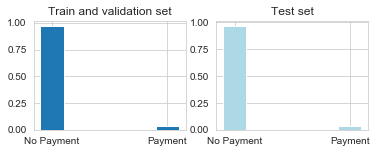

In [298]:
fig = plt.figure(figsize=(6,2))
    
#Train and valid set
ax1=fig.add_subplot(121)
ax1.set_title('Train and validation set')
ax1.bar(['No Payment','Payment',],pd.value_counts(y,normalize=True),width=0.2)

#Test set
ax2=fig.add_subplot(122)
ax2.set_title('Test set')
ax2.bar(['No Payment','Payment'],pd.value_counts(y_te,normalize=True),color='lightblue',width=0.2)
plt.show()

Only 3% of my claims have a payment at development year 2. The class imbalance problem will get higher every development year. There are techniques to deal with them such as :
- Oversample minority class
- Undersample majority class
- Generate synthetic samples
<br> 
<br>that I have not tried in this work. I will stick with defining a threshold such that the number of false negative and false positive is almost balanced.

#### Split valid and train set 

I would like my models to be trained and tested using claims from all accident year, so I will pass it in the stratify argument

In [299]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_valid, y_tr, y_valid = train_test_split(
    X, y,  train_size=0.7, test_size=0.3, random_state=0,stratify=X['AY'])

As my two classes are not uniformly distributed, I have a class imbalance problem. I will try to fix it by giving more weights to samples with a payment. The class_weight is implemented in the random forest classifier so I will use it :

In [300]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=500,class_weight='balanced')
model_RF.fit(X_tr , y_tr)
y_pred_RF = model_RF.predict(X_valid)

#Compute Evaluation Metrics :
acc_RF = accuracy_score(y_valid,y_pred_RF)
prec_RF = precision_score(y_valid,y_pred_RF)
recall_RF = recall_score(y_valid,y_pred_RF)
F1_RF = f1_score(y_valid,y_pred_RF)
#print('Evaluation Metrics of RF Classifier :')
#print('accuracy: ',acc_RF)
#print('Precision:',prec_RF)
#print('Recall: ',recall_RF)
#print('F1 Score: ',F1_RF)

target_names = ['NoPayment', 'Payment']
print(classification_report(y_valid, y_pred_RF,target_names=target_names))

              precision    recall  f1-score   support

   NoPayment       0.99      0.99      0.99    120144
     Payment       0.78      0.56      0.65      4046

   micro avg       0.98      0.98      0.98    124190
   macro avg       0.88      0.78      0.82    124190
weighted avg       0.98      0.98      0.98    124190



In [211]:
model_GB = GradientBoostingClassifier(n_estimators=100,max_depth=8)
model_GB.fit(X_tr , y_tr)
y_pred_GB = model_GB.predict(X_valid)

#Compute Evaluation Metrics :
acc_GB = accuracy_score(y_valid,y_pred_GB)
prec_GB = precision_score(y_valid,y_pred_GB)
recall_GB = recall_score(y_valid,y_pred_GB)
F1_GB = f1_score(y_valid,y_pred_GB)
print('Evaluation Metrics of GB Classifier :')
print('accuracy: ',acc_GB)
print('Precision:',prec_GB)
print('Recall: ',recall_GB)
print('F1 Score: ',F1_GB)

Evaluation Metrics of GB Classifier :
accuracy:  0.9811256945003624
Precision: 0.7629789864029666
Recall:  0.6102323282254078
F1 Score:  0.678110409228234


Keep the same methodology : Keep the GB Classifier which has a better F1 Score and then look the probability threshold from which I do get higher Error of Type 1 than Error of type 2 in order to keep a safety margin :

In [212]:
y_scores_GB = model_GB.predict_proba(X_valid)[:, 1]

In [221]:
p, r, thresholds = precision_recall_curve(y_valid, y_scores_GB)

     pred_neg  pred_pos
neg    118892      1252
pos      1257      2789


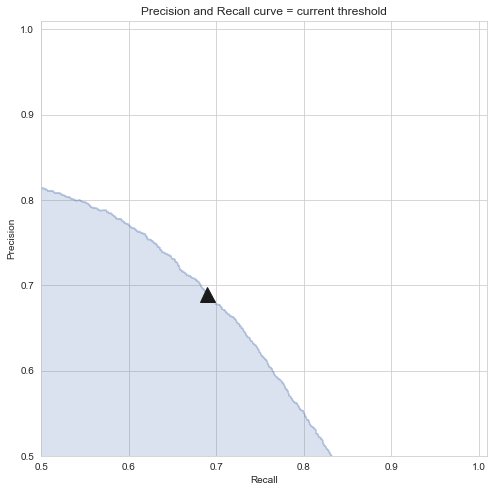

In [222]:
precision_recall_threshold(p, r, thresholds, 0.35)

In [223]:
y_pred_valid = (model_GB.predict_proba(X_valid)[:,1] >= 0.35).astype(bool)

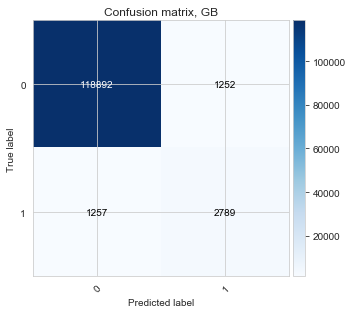

In [234]:
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
class_names = ['Payment','No Payment']

plot_confusion_matrix(y_valid, y_pred_valid, classes=class_names,
                      ax=ax1,title='Confusion matrix, GB',normalize=False)
plt.show()

35% seems to be a good threshold. I will keep this one.

In [307]:
y_pred_02 = (model_GB.predict_proba(X_te)[:,1] >= 0.35).astype(bool)

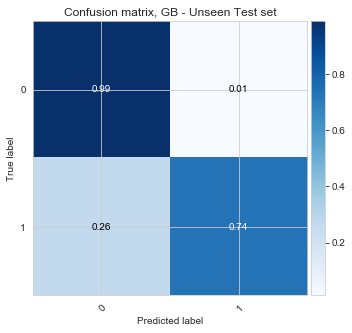

In [230]:
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
class_names = ['Payment','No Payment']

plot_confusion_matrix(y_te, y_pred_02, classes=class_names,normalize=True,
                      ax=ax1,title='Confusion matrix, GB - Unseen Test set')
plt.show()

In the test set I have a lower percentage of claims which are not detected by the model compared to validation set

### Regression Model

**Train the model only on claims with a payment at time = 2** 

In [301]:
index = data[data['Pay02']!=0].index
print('Number of datapoints with non zero payment at dev. year 2 :', index.shape[0])

Number of datapoints with non zero payment at dev. year 2 : 16427


In addition to keep predicted payment values in my test set, I will keep a trace of True Claims with a Payment at time 2 in order to evaluate the performance of the regression model **alone**. I do it with my validation set already by passing only true payment values but I am interested at predicting what is in my test set.
<br> If I had a Classifier which would have an accuracy of 100% on unseen values (test set), how accurate would my regression model be ?

In [302]:
model_number = 1

index_Paid02 = data.loc[index,:]['AY'].isin(AY[11-model_number:]).dropna()
index_Paid02_te = index_Paid02[index_Paid02].index
X_Paid02_te = X_te.loc[index_Paid02_te,:]
#Contains features from claims with AY in (2004, 2005) which had a payment in development year 2
print('X features of true payment in test set : ',X_Paid02_te.shape)

y_Paid02_te = np.log1p(data.loc[index_Paid02_te,:]['PayCum02'])

print('y shape of true payment in test set : ',y_Paid02_te.shape)

X features of true payment in test set :  (3055, 30)
y shape of true payment in test set :  (3055,)


Resize the Train and Validation set only with non zero values :

- **Recall :** The train and validation set does not contain any claims of AY (2005,2004).

In [303]:
X = X.loc[index,:].dropna()
#X.drop(columns='Unnamed: 0',inplace=True)
print('X shape :',X.shape)

X shape : (13372, 30)


In [304]:
np.sum(data[data['Pay02']!=0]['AY'].isin(['2005','2004']))

3055

Define target value as the log1p Cumulative Payment at time = 1. 
<br>
- Recall : The validation and train values are only claims not in AY=(2005,2004) 

In [305]:
model_number=1

# Second Model do not take Accident Year 2005 and 2004
y = np.log1p(data.loc[~data['AY'].isin(AY[11-model_number:])].loc[index,:].dropna()['PayCum02'])
print('Target (valid+train set) shape : ', y.shape)

Target (valid+train set) shape :  (13372,)


Redefine the size of test sample based on the first model classification predictions :

In [308]:
#Test Features sample :
#X_te.drop(columns='Unnamed: 0',inplace=True)
X_te['Class_Pred'] = y_pred_02
X_te = X_te[X_te['Class_Pred']==True]
X_te.drop(columns='Class_Pred',inplace=True)
print('Test features shape : ', X_te.shape)

#Test target sample :
y_te = np.log1p(data.loc[data['AY'].isin(AY[11-model_number:])].loc[X_te.index,:].dropna()['PayCum02'])

print('Test target shape : ',y_te.shape)

Test features shape :  (3270, 30)
Test target shape :  (3270,)


In [309]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_valid, y_tr, y_valid = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=0,stratify=X['AY'])

print('Train sample size : ', X_tr.shape)
print('Validation sample size : ', X_valid.shape)

Train sample size :  (9360, 30)
Validation sample size :  (4012, 30)


In [310]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=500, max_depth=None, random_state=0,n_jobs=-1)
# Fit estimator
rf.fit(X_tr, y_tr)

# Accuracy on the test and validation set
y_te_rf_02 = np.expm1(rf.predict(X_te))
y_valid_rf = np.expm1(rf.predict(X_valid))

mae_rf_valid = mae(np.expm1(y_valid),y_valid_rf)
mae_rf_te = mae(np.expm1(y_te),y_te_rf_02)

print(mae_rf_valid)
print(mae_rf_te)

2564.4579648282083
2697.9218272281632


In [311]:
print('Sum of predicted Cumulative Payment at time 1 on validation set :' ,np.round(y_valid_rf.sum()))
print('Sum of true Cumulative Payment at time 1 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 1 on validation set : 98690157.0
Sum of true Cumulative Payment at time 1 on validation set :  101793704.0


In [258]:
gbr = GradientBoostingRegressor(loss='quantile',alpha=0.75,
                                n_estimators=300, max_depth=8,learning_rate=0.05
                               )

# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on the test and validation set
y_te_upp_02 = np.expm1(gbr.predict(X_te))
y_valid_upp = np.expm1(gbr.predict(X_valid))

mae_upp_valid = mae(np.expm1(y_valid),y_valid_upp)
mae_upp_te = mae(np.expm1(y_te),y_te_upp_02)

print(mae_upp_valid)
print(mae_upp_te)

#Fit GBR Q60%
gbr.set_params(alpha=0.6)
gbr.fit(X_tr, y_tr)

# Accuracy on the test and validation set
y_te_down_02 = np.expm1(gbr.predict(X_te))
y_valid_down = np.expm1(gbr.predict(X_valid))

mae_down_valid = mae(np.expm1(y_valid),y_valid_down)
mae_down_te = mae(np.expm1(y_te),y_te_down_02)

print(mae_down_valid)
print(mae_down_te)

2794.1158019136433
3005.305169806362
2510.026999812777
2776.2842391781696


In [259]:
print('GBR 60% - Sum of predicted Cumulative Payment at time 2 on validation set :' ,np.round(y_valid_down.sum()))
print('GBR 75% - Sum of predicted Cumulative Payment at time 2 on validation set :' ,np.round(y_valid_upp.sum()))
print('Sum of true Cumulative Payment at time 2 on validation set : ',np.round(np.expm1(y_valid).sum()) )

GBR 60% - Sum of predicted Cumulative Payment at time 2 on validation set : 99461825.0
GBR 75% - Sum of predicted Cumulative Payment at time 2 on validation set : 101723811.0
Sum of true Cumulative Payment at time 2 on validation set :  101793704.0


I will therefore keep my Gradient Boosting with Quantile Loss Q=75% because it is the one which is the more close from the total aggreage payment at development year 2.

In [260]:
rf_imp = pd.DataFrame(X_tr.columns, columns=['Features'])
rf_imp['Importance']=np.round(rf.feature_importances_,2)
rf_imp.sort_values(by='Importance',ascending=False).head(10)

,Features,Importance
4,PayCum01,0.92
0,AY,0.01
2,age,0.01
28,LoB_3,0.01
27,LoB_2,0.01
16,inj_6,0.00
26,LoB_1,0.00
25,cc_7,0.00
24,cc_6,0.00
23,cc_5,0.00


In [261]:
gbr_imp = pd.DataFrame(X_tr.columns, columns=['Features'])
gbr_imp['Importance']=np.round(gbr.feature_importances_,2)
gbr_imp.sort_values(by='Importance',ascending=False).head(10)

,Features,Importance
4,PayCum01,0.68
9,Paid_Prop01,0.07
7,Paid_Prop00,0.07
2,age,0.04
1,AQ,0.03
0,AY,0.02
6,Paid_Ind00,0.01
8,Paid_Ind01,0.01
27,LoB_2,0.01
13,inj_3,0.01


Interesting to see that the GB Classifier keeps track of the history of the proportion paid and of the two indicator variable.

The Cumulative Payment is even more used than the first model of development year 1 which seems logical : The more you advance in the claim development, the more you are sure about it's total cumulative payment from the payment until now.

### Evaluate Accuracy on test set

#### Of Regressor Alone : 

In addition to keep predicted payment values in my test set, I will keep a trace of True Claims with a Payment at time 1 in order to evaluate the performance of the regression model **alone**. I do it with my validation set already by passing only true payment values but I am interested at predicting what is in my test set.
<br> If I had a Classifier which would have an accuracy of 100% on unseen values (test set), how accurate would my regression model be ?

In [276]:
y_rf_teTrue.shape

(8982,)

In [277]:
y_Paid02_te.shape

(3055,)

In [313]:
y_rf_teTrue = np.expm1(rf.predict(X_Paid02_te))
print('MAE due to Regressor Alone -RF: ',np.round(mae(y_rf_teTrue,np.expm1(y_Paid02_te))))

gbr = GradientBoostingRegressor(loss='quantile',alpha=0.75,
                                n_estimators=300, max_depth=8,learning_rate=0.05
                               )

# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on True test set
y_upp_teTrue = np.expm1(gbr.predict(X_Paid02_te))
print('MAE due to Regressor Alone -GBR 75%: ',np.round(mae(y_upp_teTrue,np.expm1(y_Paid02_te))))

#Fit GBR Q60%
gbr.set_params(alpha=0.6)
gbr.fit(X_tr, y_tr)

#Accuracy on True test set
y_down_teTrue = np.expm1(gbr.predict(X_Paid02_te))
print('MAE due to Regressor Alone -GBR Q60%: ',np.round(mae(y_down_teTrue,np.expm1(y_Paid02_te)))) 

MAE due to Regressor Alone -RF:  2084.0
MAE due to Regressor Alone -GBR 75%:  2235.0
MAE due to Regressor Alone -GBR Q60%:  2117.0


In [314]:
y_teTrue_final = data[data['AY'].isin(AY[11-model_number:])].loc[X_Paid02_te.index,:][['LoB','AY','cc','inj_part','PayCum00','PayCum01','PayCum02']]
#y_teTrue_final['y_huber'] = np.round(y_huber_teTrue)
y_teTrue_final['y_rf'] = np.round(y_rf_teTrue)
#y_teTrue_final['y_ada'] = np.round(y_valid_ada)
#y_teTrue_final['y_gbr'] = np.round(y_gbr_teTrue)
y_teTrue_final['y_gbr-Q60%'] = np.round(y_down_teTrue)
y_teTrue_final['y_gbr-Q75%'] = np.round(y_upp_teTrue)
y_teTrue_final.head()

,LoB,AY,cc,inj_part,PayCum00,PayCum01,PayCum02,y_rf,y_gbr-Q60%,y_gbr-Q75%
413957,4,2004,27,53,3078,3078,4135,4583.0,4623.0,4618.0
413981,4,2004,15,30,2902,5330,7200,7064.0,7344.0,7328.0
413984,4,2004,17,54,0,3968,8458,6462.0,6663.0,8247.0
413998,1,2004,17,36,399,624,792,835.0,814.0,871.0
414075,4,2004,22,25,9142,23274,32702,31533.0,32409.0,33199.0


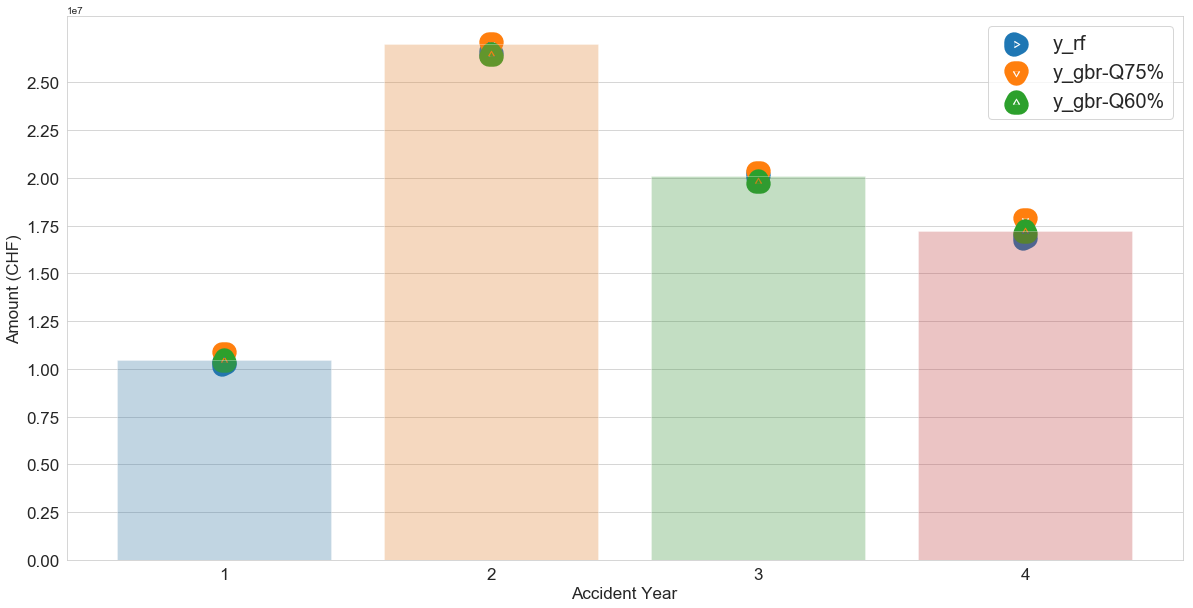

In [315]:
y_teTrue_group = y_teTrue_final.groupby('LoB')['PayCum02','y_rf','y_gbr-Q60%','y_gbr-Q75%'].sum()
plt.figure(figsize=(20,10))
sns.barplot(x='LoB',y='PayCum02',data=y_teTrue_group.reset_index(),alpha=0.3)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_huber'],marker='X',s=20,linewidths=20)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_knn'],marker='D',s=20,linewidths=20)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr'],marker='o',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_rf'],marker='>',s=20,linewidths=20)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_ada'],marker='<',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr-Q75%'],marker='v',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr-Q60%'],marker='^',s=20,linewidths=20)

#Arange graph :
plt.legend(loc='best',prop={'size': 20})
plt.xticks(size=17)
plt.xlabel('Accident Year',size=17)
plt.yticks(np.linspace(0,25000000,11),size=17)
plt.ylabel('Amount (CHF)',size=17)
plt.show()

#### Of Both Classifier and Regressor

In [316]:
print('MAE due to Regressor Alone -RF: ,', np.round(mae_rf_te))
#print('MAE due to Regressor Alone -GBR: ,', np.round(mae_gbr_te))
print('MAE due to Regressor Alone -GBR Q75%: ,', np.round(mae_upp_te))
print('MAE due to Regressor Alone -GBR Q65%: ,', np.round(mae_down_te))

MAE due to Regressor Alone -RF: , 2698.0
MAE due to Regressor Alone -GBR Q75%: , 3005.0
MAE due to Regressor Alone -GBR Q65%: , 2776.0


In [317]:
df_pred_02 = data[data['AY'].isin(AY[11-model_number:])]
df_pred_02['pred'] = y_pred_02

print('Payment at time 1 for claims predicted as not having a payment at time =2 : ', df_pred_02[df_pred_02['pred']==False]['PayCum02'].sum())

Payment at time 1 for claims predicted as not having a payment at time =2 :  81660619


Keep the Cumulative Payment at time 1 for claims not detected by the model as having a payment in the next year. For the others add the predicted payment of each model :

In [318]:
#df_pred_01['pred_Ada'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(y_te_ada,index=y_te.index))
df_pred_02['pred_upp'] = df_pred_02[df_pred_02['pred']==False]['PayCum01'].append(pd.DataFrame(y_te_upp_02,index=y_te.index))
df_pred_02['pred_rf'] = df_pred_02[df_pred_02['pred']==False]['PayCum01'].append(pd.DataFrame(np.expm1(rf.predict(X_te)),index=y_te.index))
df_pred_02['pred_down'] = df_pred_02[df_pred_02['pred']==False]['PayCum01'].append(pd.DataFrame(y_te_down_02,index=y_te.index))
#df_pred_01['pred_Huber'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(np.expm1(huber.predict(X_te)),index=y_te.index))
#df_pred_01['pred_KNN'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(np.expm1(pipe_knn.predict(X_KNN_te)),index=y_te.index))

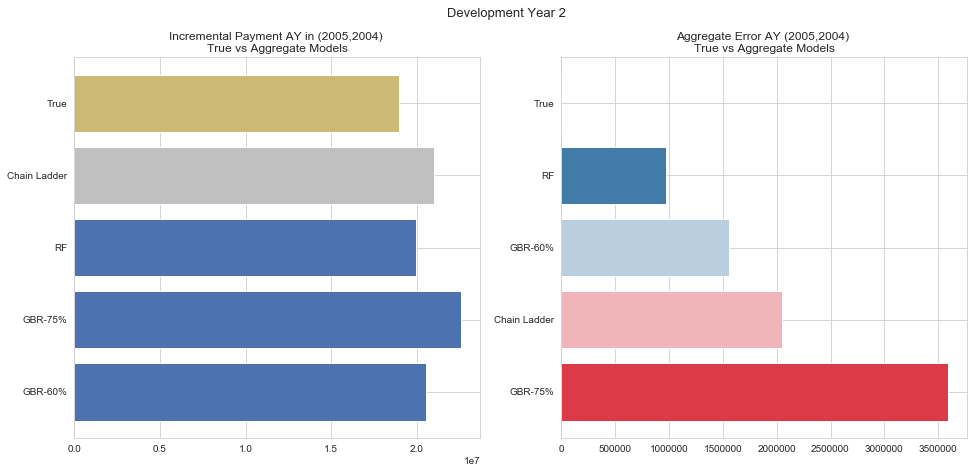

In [320]:
plt.figure(figsize=(16,7))

plt.suptitle('Development Year 2',size=13)
plt.subplot(1,2,1)
plt.title('Incremental Payment AY in (2005,2004) \nTrue vs Aggregate Models')
colors = ['b','b','b','silver','y']
plt.barh(['GBR-60%','GBR-75%','RF','Chain Ladder','True'], [df_pred_02['pred_down'].sum(),df_pred_02['pred_upp'].sum(),df_pred_02['pred_rf'].sum(),np.sum(dev_factor[0,:]*dev_factor[1,:]*Paid_obs_2005[-1]+dev_factor[1,:]*Paid_obs_2005[-2]),df_pred_02['PayCum02'].sum()]-df_pred_02['PayCum01'].sum(),color=colors)

plt.subplot(1,2,2)
plt.title('Aggregate Error AY (2005,2004) \nTrue vs Aggregate Models')
colors = sns.diverging_palette(10, 240, n=4)
plt.barh(['GBR-75%','Chain Ladder','GBR-60%','RF','True'], [df_pred_02['pred_upp'].sum(),np.sum(dev_factor[0,:]*dev_factor[1,:]*Paid_obs_2005[-1]+dev_factor[1,:]*Paid_obs_2005[-2]),df_pred_02['pred_down'].sum(),df_pred_02['pred_rf'].sum(),df_pred_02['PayCum02'].sum()]-df_pred_02['PayCum02'].sum(),color=colors)

plt.show()

Here All the method overestimates a bit the true incremental payment of AY 2004 and 2005 for the second development year. We have around 18M of incremental payment and our model overestimates from 1M to 4M. I know that a lot comes from the classification model as we have seen before that our models are well calibrated for the regression part alone.

## Model 2 - Development Year 3

Two models to predict the Cumulative Payment at time 3.
- A classifier to predict if a claim will receive a payment in the next year
- A regression model to predict the value of the future payment to be made given that there is one  

In [321]:
X,X_te = Create_FeatureSpace(model_number=2)

X feature shape after hashing encoding on inj_part feature :  (500926, 32)
X feature shape after encoding and model selection :  (370713, 32)
X_te feature shape after encoding and model selection :  (130213, 32)


In [322]:
X_te.columns

Index(['AY', 'AQ', 'age', 'RepDel', 'PayCum02', 'Open02', 'Paid_Ind00',
       'Paid_Prop00', 'Paid_Ind01', 'Paid_Prop01', 'Paid_Ind02', 'Paid_Prop02',
       'inj_0', 'inj_1', 'inj_2', 'inj_3', 'inj_4', 'inj_5', 'inj_6', 'inj_7',
       'cc_0', 'cc_1', 'cc_2', 'cc_3', 'cc_4', 'cc_5', 'cc_6', 'cc_7', 'LoB_1',
       'LoB_2', 'LoB_3', 'LoB_4'],
      dtype='object')

Keep the Payment indicators (first and second model) and the Payment predictions from the 2nd model for the claims of AY (2005,2004) :

In [323]:
X_te.loc[y_te.index]['Paid_Ind02'] = 1

# predicted value for Paid_Ind_01 should also be taken from the 1st Model  
X_te.loc[df_pred_01[df_pred_01['pred']==True].index]['Paid_Ind01'] = 1

In [324]:
X_te.loc[df_pred_02.index]['PayCum02'] = df_pred_02['pred_upp']

### Classification Model

Define Target Variable as an indicator variable depending on payment at time = 3 : 

In [325]:
AY = data_encode['AY'].unique()
model_number=2
    
y_te = data.loc[data['AY'].isin(AY[11-model_number:])]['Pay03'].map(lambda x: 0 if x==0 else 1)
y = data.loc[~data['AY'].isin(AY[11-model_number:])]['Pay03'].map(lambda x: 0 if x==0 else 1)

print('y shape : ',y.shape)
print('y_te shape : ',y_te.shape)

y shape :  (370713,)
y_te shape :  (130213,)


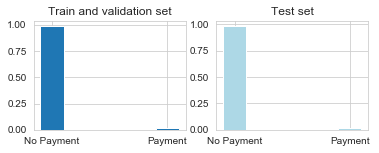

In [326]:
fig = plt.figure(figsize=(6,2))
    
#Train and valid set
ax1=fig.add_subplot(121)
ax1.set_title('Train and validation set')
ax1.bar(['No Payment','Payment',],pd.value_counts(y,normalize=True),width=0.2)

#Test set
ax2=fig.add_subplot(122)
ax2.set_title('Test set')
ax2.bar(['No Payment','Payment'],pd.value_counts(y_te,normalize=True),color='lightblue',width=0.2)
plt.show()

In [327]:
pd.value_counts(y,normalize=False)

0    364946
1      5767
Name: Pay03, dtype: int64

Only 1.5% of my claims have a payment at development year 2. The class imbalance problem will get higher every development year. There are techniques to deal with them such as :
- Oversample minority class
- Undersample majority class
- Generate synthetic samples
<br> 
<br>that I have not tried in this work. I will stick with defining a threshold such that the number of false negative and false positive is almost balanced.

#### Split valid and train set 

I would like my models to be trained and tested using claims from all accident year, so I will pass it in the stratify argument

In [328]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_valid, y_tr, y_valid = train_test_split(
    X, y,  train_size=0.7, test_size=0.3, random_state=0,stratify=X['AY'])

As my two classes are not uniformly distributed, I have a class imbalance problem. I will try to fix it by giving more weights to samples with a payment. The class_weight is implemented in the random forest classifier so I will use it :

In [329]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=500,class_weight='balanced')
model_RF.fit(X_tr , y_tr)
y_pred_RF = model_RF.predict(X_valid)

#Compute Evaluation Metrics :
acc_RF = accuracy_score(y_valid,y_pred_RF)
prec_RF = precision_score(y_valid,y_pred_RF)
recall_RF = recall_score(y_valid,y_pred_RF)
F1_RF = f1_score(y_valid,y_pred_RF)
#print('Evaluation Metrics of RF Classifier :')
#print('accuracy: ',acc_RF)
#print('Precision:',prec_RF)
#print('Recall: ',recall_RF)
#print('F1 Score: ',F1_RF)

target_names = ['NoPayment', 'Payment']
print(classification_report(y_valid, y_pred_RF,target_names=target_names))

              precision    recall  f1-score   support

   NoPayment       0.99      1.00      1.00    109530
     Payment       0.79      0.57      0.66      1684

   micro avg       0.99      0.99      0.99    111214
   macro avg       0.89      0.78      0.83    111214
weighted avg       0.99      0.99      0.99    111214



In [330]:
model_GB = GradientBoostingClassifier(n_estimators=100,max_depth=8)
model_GB.fit(X_tr , y_tr)
y_pred_GB = model_GB.predict(X_valid)

#Compute Evaluation Metrics :
acc_GB = accuracy_score(y_valid,y_pred_GB)
prec_GB = precision_score(y_valid,y_pred_GB)
recall_GB = recall_score(y_valid,y_pred_GB)
F1_GB = f1_score(y_valid,y_pred_GB)
print('Evaluation Metrics of GB Classifier :')
print('accuracy: ',acc_GB)
print('Precision:',prec_GB)
print('Recall: ',recall_GB)
print('F1 Score: ',F1_GB)

Evaluation Metrics of GB Classifier :
accuracy:  0.990288992393044
Precision: 0.7029569892473119
Recall:  0.6211401425178147
F1 Score:  0.6595208070617907


In [331]:
y_scores_GB = model_GB.predict_proba(X_valid)[:, 1]

In [332]:
p, r, thresholds = precision_recall_curve(y_valid, y_scores_GB)

     pred_neg  pred_pos
neg    108932       598
pos       562      1122


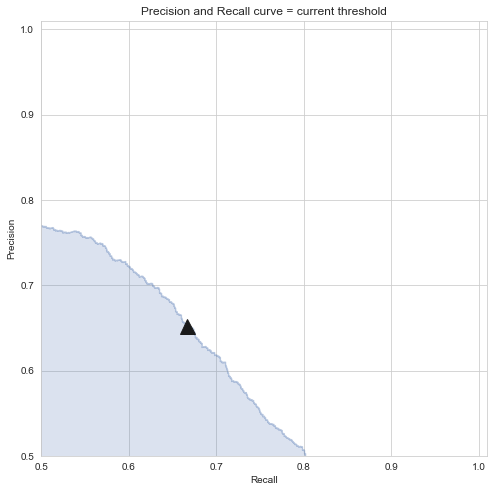

In [333]:
precision_recall_threshold(p, r, thresholds, 0.35)

In [334]:
y_pred_valid = (model_GB.predict_proba(X_valid)[:,1] >= 0.35).astype(bool)

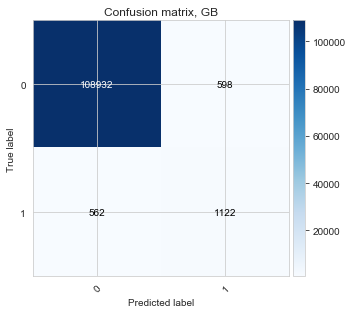

In [335]:
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
class_names = ['Payment','No Payment']

plot_confusion_matrix(y_valid, y_pred_valid, classes=class_names,
                      ax=ax1,title='Confusion matrix, GB',normalize=False)
plt.show()

In [336]:
y_pred_03 = (model_GB.predict_proba(X_te)[:,1] >= 0.35).astype(bool)

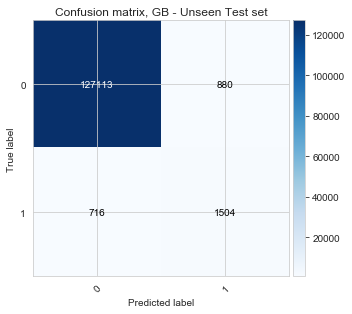

In [337]:
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
class_names = ['Payment','No Payment']

plot_confusion_matrix(y_te, y_pred_03, classes=class_names,
                      ax=ax1,title='Confusion matrix, GB - Unseen Test set')
plt.show()

Two cells which are apart of the model : Should I have added an inflation on the cost of for claims of 2005 ? Probably yes because claims category which are insured (Loss of salary, medical costs ..,) have a positive trend every year.

In [338]:
data.groupby(['AY','LoB'])['PayCum11'].mean().unstack()

LoB,1,2,3,4
AY,,,,
1994,999.152343,2060.513534,2862.891639,1434.635350
1995,985.866364,2035.993804,2638.827259,1561.201326
1996,1153.707622,2327.805327,2658.272842,1533.176459
1997,998.989061,2355.506461,2481.245558,1854.060470
1998,975.744805,1834.324473,3012.943017,1733.722806
1999,1195.553356,2176.320373,2302.330310,1679.055592
2000,1066.713647,1871.883963,2827.022455,1562.919714
2001,1139.544649,2034.365048,3053.155569,1731.090087
2002,1122.077878,2562.519638,2907.970120,1866.259197


Not evident from here that I should add an inflation factor to my claims of 2005. For LoB 1 and 2 I maybe should but more sceptical about 3 and 4.

### Regression Model

**Train the model only on claims with a payment at time = 3** 

In [339]:
index = data[data['Pay03']!=0].index
print('Number of datapoints with non zero payment at time 3 :', index.shape[0])

Number of datapoints with non zero payment at time 3 : 7987


From the 3rd model and on, it is evident I should not continue to use my two models predictions. I only have 5000 claims form training and validation in the 3rd model.

In addition to keep predicted payment values in my test set, I will keep a trace of True Claims with a Payment at time 3 in order to evaluate the performance of the regression model **alone**. I do it with my validation set already by passing only true payment values but I am interested at predicting what is in my test set.
<br> If I had a Classifier which would have an accuracy of 100% on unseen values (test set), how accurate would my regression model be ?

In [340]:
model_number = 2

index_Paid03 = data.loc[index,:]['AY'].isin(AY[11-model_number:]).dropna()
index_Paid03_te = index_Paid03[index_Paid03].index
X_Paid03_te = X_te.loc[index_Paid03_te,:]
#Contains features from claims with AY in (2003,2004, 2005) which had a payment in development year 3
print('X features of true payment in test set : ',X_Paid03_te.shape)

y_Paid03_te = np.log1p(data.loc[index_Paid03_te,:]['PayCum03'])

print('y shape of true payment in test set : ',y_Paid03_te.shape)

X features of true payment in test set :  (2220, 32)
y shape of true payment in test set :  (2220,)


Resize the Train and Validation set only with non zero values :

- **Recall :** The train and validation set does not contain any claims of AY (2005,2004,2003).

In [341]:
X = X.loc[index,:].dropna()
#X.drop(columns='Unnamed: 0',inplace=True)
print('X shape :',X.shape)

X shape : (5767, 32)


In [342]:
np.sum(data[data['Pay03']!=0]['AY'].isin(['2005','2004','2003']))

2220

Define target value as the log1p Cumulative Payment at time = 3. 
<br>
- Recall : The validation and train values are only claims not in AY=(2005,2004,2003) 

In [343]:
# Third Model do not take Accident Year 2005,2004 and 2003
y = np.log1p(data.loc[~data['AY'].isin(AY[11-model_number:])].loc[index,:].dropna()['PayCum03'])
print('Target (valid+train set) shape : ', y.shape)

Target (valid+train set) shape :  (5767,)


Redefine the size of test sample based on the first model classification predictions :

In [344]:
#Test Features sample :
#X_te.drop(columns='Unnamed: 0',inplace=True)
X_te['Class_Pred'] = y_pred_03
X_te = X_te[X_te['Class_Pred']==True]
X_te.drop(columns='Class_Pred',inplace=True)
print('Test features shape : ', X_te.shape)

#Test target sample :
y_te = np.log1p(data.loc[data['AY'].isin(AY[11-model_number:])].loc[X_te.index,:].dropna()['PayCum03'])

print('Test target shape : ',y_te.shape)

Test features shape :  (2384, 32)
Test target shape :  (2384,)


In [345]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_valid, y_tr, y_valid = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=0,stratify=X['AY'])

print('Train sample size : ', X_tr.shape)
print('Validation sample size : ', X_valid.shape)

Train sample size :  (4036, 32)
Validation sample size :  (1731, 32)


In [346]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=2000, max_depth=None, random_state=0,n_jobs=-1)
# Fit estimator
rf.fit(X_tr, y_tr)

# Accuracy on the test and validation set
y_te_rf_03 = np.expm1(rf.predict(X_te))
y_valid_rf = np.expm1(rf.predict(X_valid))

mae_rf_valid = mae(np.expm1(y_valid),y_valid_rf)
mae_rf_te = mae(np.expm1(y_te),y_te_rf_03)

print(mae_rf_valid)
print(mae_rf_te)

4319.770590315325
3179.472984578551


In [347]:
print('Sum of predicted Cumulative Payment at time 3 on validation set :' ,np.round(y_valid_rf.sum()))
print('Sum of true Cumulative Payment at time 3 on validation set : ',np.round(np.expm1(y_valid).sum()) )

Sum of predicted Cumulative Payment at time 3 on validation set : 79776087.0
Sum of true Cumulative Payment at time 3 on validation set :  83076520.0


In [348]:
gbr = GradientBoostingRegressor(loss='quantile',alpha=0.75,
                                n_estimators=300, max_depth=8,learning_rate=0.05
                               )

# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on the test and validation set
y_te_upp_03 = np.expm1(gbr.predict(X_te))
y_valid_upp = np.expm1(gbr.predict(X_valid))

mae_upp_valid = mae(np.expm1(y_valid),y_valid_upp)
mae_upp_te = mae(np.expm1(y_te),y_te_upp_03)

print(mae_upp_valid)
print(mae_upp_te)

#Fit GBR Q60%
gbr.set_params(alpha=0.6)
gbr.fit(X_tr, y_tr)

# Accuracy on the test and validation set
y_te_down_03 = np.expm1(gbr.predict(X_te))
y_valid_down = np.expm1(gbr.predict(X_valid))

mae_down_valid = mae(np.expm1(y_valid),y_valid_down)
mae_down_te = mae(np.expm1(y_te),y_te_down_03)

print(mae_down_valid)
print(mae_down_te)

4340.447365285565
3585.585827510744
4626.271684213849
3488.770385481038


In [349]:
print('GBR 60% - Sum of predicted Cumulative Payment at time 2 on validation set :' ,np.round(y_valid_down.sum()))
print('GBR 75% - Sum of predicted Cumulative Payment at time 2 on validation set :' ,np.round(y_valid_upp.sum()))
print('Sum of true Cumulative Payment at time 2 on validation set : ',np.round(np.expm1(y_valid).sum()) )

GBR 60% - Sum of predicted Cumulative Payment at time 2 on validation set : 79974260.0
GBR 75% - Sum of predicted Cumulative Payment at time 2 on validation set : 81624248.0
Sum of true Cumulative Payment at time 2 on validation set :  83076520.0


I will therefore keep my Gradient Boosting with Quantile Loss Q=75% because it is the one which is the more close from the total aggregate payment at development year 3.

### Evaluate Accuracy on test set

#### Of Regressor Alone : 

In addition to keep predicted payment values in my test set, I will keep a trace of True Claims with a Payment at time 3 in order to evaluate the performance of the regression model **alone**. I do it with my validation set already by passing only true payment values but I am interested at predicting what is in my test set.
<br> If I had a Classifier which would have an accuracy of 100% on unseen values (test set), how accurate would my regression model be ?

In [350]:
y_rf_teTrue = np.expm1(rf.predict(X_Paid03_te))
print('MAE due to Regressor Alone -RF: ',np.round(mae(y_rf_teTrue,np.expm1(y_Paid03_te))))

gbr = GradientBoostingRegressor(loss='quantile',alpha=0.75,
                                n_estimators=300, max_depth=8,learning_rate=0.05
                               )

# Fit estimator
gbr.fit(X_tr, y_tr)

# Accuracy on True test set
y_upp_teTrue = np.expm1(gbr.predict(X_Paid03_te))
print('MAE due to Regressor Alone -GBR 75%: ',np.round(mae(y_upp_teTrue,np.expm1(y_Paid03_te))))

#Fit GBR Q60%
gbr.set_params(alpha=0.6)
gbr.fit(X_tr, y_tr)

#Accuracy on True test set
y_down_teTrue = np.expm1(gbr.predict(X_Paid03_te))
print('MAE due to Regressor Alone -GBR Q60%: ',np.round(mae(y_down_teTrue,np.expm1(y_Paid03_te)))) 

MAE due to Regressor Alone -RF:  2939.0
MAE due to Regressor Alone -GBR 75%:  3046.0
MAE due to Regressor Alone -GBR Q60%:  2940.0


The MAE are lower than the MAE of the aggregate model on the test set which is logical as we add uncertainty with our classifier.

In [351]:
y_teTrue_final = data[data['AY'].isin(AY[11-model_number:])].loc[X_Paid03_te.index,:][['LoB','AY','cc','inj_part','PayCum00','PayCum01','PayCum02','PayCum03']]
#y_teTrue_final['y_huber'] = np.round(y_huber_teTrue)
y_teTrue_final['y_rf'] = np.round(y_rf_teTrue)
#y_teTrue_final['y_ada'] = np.round(y_valid_ada)
#y_teTrue_final['y_gbr'] = np.round(y_gbr_teTrue)
y_teTrue_final['y_gbr-Q60%'] = np.round(y_down_teTrue)
y_teTrue_final['y_gbr-Q75%'] = np.round(y_upp_teTrue)
y_teTrue_final.head()

,LoB,AY,cc,inj_part,PayCum00,PayCum01,PayCum02,PayCum03,y_rf,y_gbr-Q60%,y_gbr-Q75%
370717,3,2003,50,51,14960,30245,41806,51568,52517.0,51899.0,51182.0
370780,3,2003,31,51,0,3754,3754,6075,5444.0,6197.0,7746.0
370786,3,2003,10,51,0,13888,13888,22579,14916.0,17499.0,19867.0
370800,2,2003,19,21,31959,49496,55924,32413,62505.0,58877.0,59786.0
370999,4,2003,15,53,6913,11414,11414,13090,13844.0,13888.0,14539.0


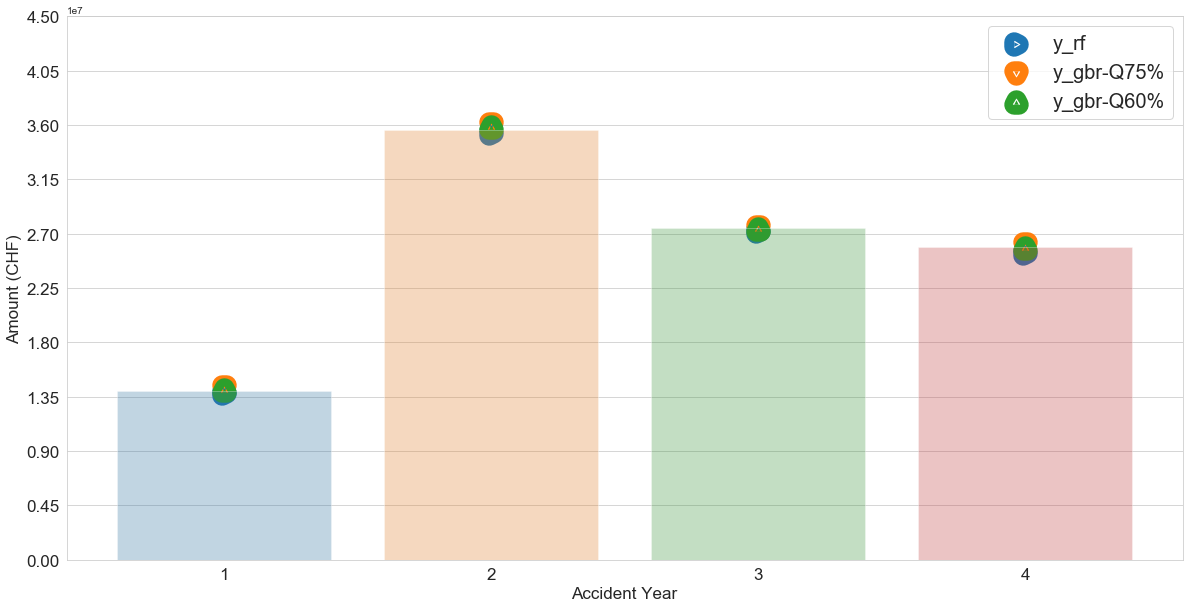

In [353]:
y_teTrue_group = y_teTrue_final.groupby('LoB')['PayCum03','y_rf','y_gbr-Q60%','y_gbr-Q75%'].sum()
plt.figure(figsize=(20,10))
sns.barplot(x='LoB',y='PayCum03',data=y_teTrue_group.reset_index(),alpha=0.3)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_huber'],marker='X',s=20,linewidths=20)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_knn'],marker='D',s=20,linewidths=20)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr'],marker='o',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_rf'],marker='>',s=20,linewidths=20)
#plt.scatter(np.arange(0,4,1),y_teTrue_group['y_ada'],marker='<',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr-Q75%'],marker='v',s=20,linewidths=20)
plt.scatter(np.arange(0,4,1),y_teTrue_group['y_gbr-Q60%'],marker='^',s=20,linewidths=20)

#Arange graph :
plt.legend(loc='best',prop={'size': 20})
plt.xticks(size=17)
plt.xlabel('Accident Year',size=17)
plt.yticks(np.linspace(0,45000000,11),size=17)
plt.ylabel('Amount (CHF)',size=17)
plt.show()

In [354]:
y_teTrue_final.sum()

LoB                6128.0
AY              4448820.0
cc                58081.0
inj_part          94030.0
PayCum00       27900229.0
PayCum01       65569458.0
PayCum02       88572132.0
PayCum03      102963040.0
y_rf          101677252.0
y_gbr-Q60%    102998465.0
y_gbr-Q75%    104101104.0
dtype: float64

The model seems to be well calibrated as the aggregate payment at development 3 per LoB is near the true value. GBR with Quantile Loss overestimates a bit and the RF regressor underestimate with 1M less than the true value.

#### Of Both Classifier and Regressor

In [355]:
print('MAE due to Regressor Alone -RF: ,', np.round(mae_rf_te))
#print('MAE due to Regressor Alone -GBR: ,', np.round(mae_gbr_te))
print('MAE due to Regressor Alone -GBR Q75%: ,', np.round(mae_upp_te))
print('MAE due to Regressor Alone -GBR Q65%: ,', np.round(mae_down_te))

MAE due to Regressor Alone -RF: , 3179.0
MAE due to Regressor Alone -GBR Q75%: , 3586.0
MAE due to Regressor Alone -GBR Q65%: , 3489.0


In [356]:
df_pred_03 = data[data['AY'].isin(AY[11-model_number:])]
df_pred_03['pred'] = y_pred_03

print('Payment at time 2 for claims predicted as not having a payment at time =3 : ', df_pred_03[df_pred_03['pred']==False]['PayCum02'].sum())

Payment at time 2 for claims predicted as not having a payment at time =3 :  147176420


In [357]:
#df_pred_01['pred_Ada'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(y_te_ada,index=y_te.index))
df_pred_03['pred_upp'] = df_pred_03[df_pred_03['pred']==False]['PayCum02'].append(pd.DataFrame(y_te_upp_03,index=y_te.index))
df_pred_03['pred_rf'] = df_pred_03[df_pred_03['pred']==False]['PayCum02'].append(pd.DataFrame(np.expm1(rf.predict(X_te)),index=y_te.index))
df_pred_03['pred_down'] = df_pred_03[df_pred_03['pred']==False]['PayCum02'].append(pd.DataFrame(y_te_down_03,index=y_te.index))
#df_pred_01['pred_Huber'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(np.expm1(huber.predict(X_te)),index=y_te.index))
#df_pred_01['pred_KNN'] = df_pred_01[df_pred_01['pred']==False]['PayCum00'].append(pd.DataFrame(np.expm1(pipe_knn.predict(X_KNN_te)),index=y_te.index))

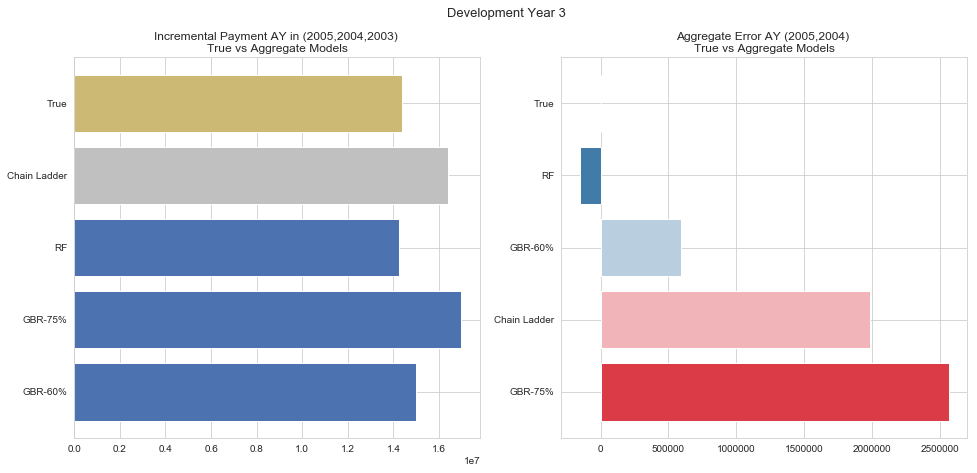

In [358]:
plt.figure(figsize=(16,7))

plt.suptitle('Development Year 3',size=13)
plt.subplot(1,2,1)
plt.title('Incremental Payment AY in (2005,2004,2003) \nTrue vs Aggregate Models')
colors = ['b','b','b','silver','y']
plt.barh(['GBR-60%','GBR-75%','RF','Chain Ladder','True'], [df_pred_03['pred_down'].sum(),df_pred_03['pred_upp'].sum(),df_pred_03['pred_rf'].sum(),np.sum(dev_factor[0,:]*dev_factor[1,:]*dev_factor[2,:]*Paid_obs_2005[-1]+dev_factor[1,:]*dev_factor[2,:]*Paid_obs_2005[-2]+dev_factor[2,:]*Paid_obs_2005[-3]),df_pred_03['PayCum03'].sum()]-df_pred_03['PayCum02'].sum(),color=colors)

plt.subplot(1,2,2)
plt.title('Aggregate Error AY (2005,2004) \nTrue vs Aggregate Models')
colors = sns.diverging_palette(10, 240, n=4)
plt.barh(['GBR-75%','Chain Ladder','GBR-60%','RF','True'], [df_pred_03['pred_upp'].sum(),np.sum(dev_factor[0,:]*dev_factor[1,:]*dev_factor[2,:]*Paid_obs_2005[-1]+dev_factor[1,:]*dev_factor[2,:]*Paid_obs_2005[-2]+dev_factor[2,:]*Paid_obs_2005[-3]),df_pred_03['pred_down'].sum(),df_pred_03['pred_rf'].sum(),df_pred_03['PayCum03'].sum()]-df_pred_03['PayCum03'].sum(),color=colors)

plt.show()

Here All the method expect RF overestimates a bit the true incremental payment of AY 2003,2004 and 2005 for the second development year. We have around 15M of incremental payment and our models have an error from -0.5M to 2.5M. I know that a lot comes from the classification model as we have seen before that our models are well calibrated for the regression part alone.

**Reflections on the models and future development :**
- The number of claims with a payment begins to be too low to train a model from development year 3
- Training a model without a classification part and just a regression might be a good solution.
- Only Line of Business 2 and 4 really have a payment increase from that point. Can maybe use more traditional techniques like applying a development factor for each development year.
- I took the full history of accident years in order to train my models. I could maybe have restricted the training and validation set to more recent years in order to account for changes in payment behaviour (frequency, size).

The goal of this project was to see if a more granular approach could be used in order to compute  the Ultimate Cost of claims. I think I showed with the three models that it can be implemented and I will not go further in the model development.
Moreover, many Lines of Business such as collision car insurance or loss of salary due to illness are very short term in the sense that all the claims are paid in maximum 2 years time and are well suited for the model presented above.
 

**Open Question:**

We would like to be on the safer side with our estimation and therefore in line with good practices in insurance reserving. We can either introduce a penalty for underestimation in our objective function or either we could reforumlate our optimisation problem by constraining the parameter space (example minimise the MAE but with a constraint on the total sum of predicted payment to be higher than a certain level.

## END OF NOTEBOOK

### Ensemble Methods 

In [ ]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor


# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
#reg3 = LinearRegression()
ereg = VotingRegressor([('gb', reg1), ('rf', reg2)])
reg1.fit(X_tr, y_tr)
reg2.fit(X_tr, y_tr)
#reg3.fit(X_tr, y_tr)
ereg.fit(X_tr, y_tr)

xt = X_te[:50]

plt.figure()
plt.plot(reg1.predict(xt), 'gd', label='GradientBoostingRegressor')
plt.plot(reg2.predict(xt), 'b^', label='RandomForestRegressor')
#plt.plot(reg3.predict(xt), 'ys', label='LinearRegression')
plt.plot(ereg.predict(xt), 'r*', label='VotingRegressor')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()

In [ ]:
data.groupby('AY')['Paid_Ind00','Paid_Ind01','Paid_Ind02','Paid_Ind03','Paid_Ind04','Paid_Ind05','Paid_Ind06','Paid_Ind07','Paid_Ind08','Paid_Ind09','Paid_Ind10','Paid_Ind11'].sum()

In [ ]:
c1 = data[data['LoB']==1].groupby('inj_part')['Paid_Ind00','Paid_Ind01','Paid_Ind02','Paid_Ind03','Paid_Ind04','Paid_Ind05','Paid_Ind06','Paid_Ind07','Paid_Ind08','Paid_Ind09','Paid_Ind10','Paid_Ind11'].sum()

In [ ]:
c2 = data[data['LoB']==2].groupby('inj_part')['Paid_Ind00','Paid_Ind01','Paid_Ind02','Paid_Ind03','Paid_Ind04','Paid_Ind05','Paid_Ind06','Paid_Ind07','Paid_Ind08','Paid_Ind09','Paid_Ind10','Paid_Ind11'].sum()

In [ ]:
c1.head()

In [ ]:
c_new = c / c.sum()

In [ ]:
plt.bar(c_new.index,c1.sum(axis=1)/data[data['LoB']==1].groupby('inj_part')['ClNr'].count())

In [ ]:
plt.bar(c_new.index,c2.sum(axis=1)/data[data['LoB']==1].groupby('inj_part')['ClNr'].count())

In [ ]:
durée des paiements par diag : 
    
nombre de paiements moyen par diag : 

In [ ]:
plt.bar(c_new.index, c_new['Paid_Ind00'])

In [ ]:
plt.bar(c_new.index, c_new['Paid_Ind09'])

In [ ]:
# Plot the validation curves
plt.plot(epsilons, train_scores, label='train curve')
plt.plot(epsilons, test_scores, label='test curve')
plt.legend()
plt.show()

In [ ]:
X_tr = X_tr['Pay00']
X_te = X_te['Pay00']
X_tr = X_tr[:,np.newaxis]
X_te = X_te[:,np.newaxis]

In [ ]:
from sklearn.linear_model import LinearRegression

# Create a linear regression object
lr = LinearRegression()
lr.fit(X_tr,y_tr)
lr.score(X_te,y_te)

X_te_pred = lr.predict(X_te)

MSE_Huber = mse(y_te,y_te_pred)
MAE_Huber = mae(y_te,y_te_pred)

print("RMSLE of Huber Model : {0:.4f} ".format(MSE_Huber))
print ("MAE of Huber Model : {0:.4f} ".format(MAE_Huber))

In [ ]:
plt.scatter(y_te_pred/1e3,y_te/1e3)
plt.show()

Can we improve the error using Regularisation ?

In [ ]:
# Define a set of alpha values
alphas = np.logspace(-1, -5, num=5)

# Save error on train/test sets
train_scores = []
test_scores = []


# Grid search
for alpha in alphas:
    # Create and fit ridge regression
    huber = HuberRegressor(alpha=alpha,epsilon=1.35)
    huber.fit(X_tr, y_tr)

    # Performance on train set
    y_pred = huber.predict(X_tr)
    train_mae = mae(y_tr, y_pred)
    train_scores.append(train_mae)

    # Performance on test set
    y_pred =huber.predict(X_te)
    test_mae = mae(y_te, y_pred)
    test_scores.append(test_mae)

In [ ]:
alphas

In [ ]:
# Plot the validation curves
plt.semilogx(alphas, train_scores, label='train curve')
plt.semilogx(alphas, test_scores, label='test curve')
plt.legend()
plt.show()

### First model : Predict cost of claims dev=1

In [ ]:
data['Pay01_cum'] = data['Pay00']+data['Pay01']

In [ ]:
y = data['Pay01_cum'].values
X = data[['LoB','Pay00','Open00','age']].values

In [ ]:
# Split data
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, train_size=0.5, test_size=0.5, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create the transformer object
scaler = StandardScaler()

# Compute mean and std on train set
scaler.fit(X_tr)

# Standardize train and test sets
X_tr_stand = scaler.transform(X_tr)
X_te_stand = scaler.transform(X_te)

In [ ]:
np.median(y_te)

In [ ]:
y_med = [np.median(y_te)] * len(y_te)

y_mean = [np.mean(y_te)] * len(y_te)

MSE_Bas = mse(y_te,y_mean)
MAE_Bas = mae(y_te,y_med)
                    
print("RMSLE of Baseline Model : {0:.4f} ".format(MSE_Bas))
print ("MAE of Baseline Model : {0:.4f} ".format(MAE_Bas))

In [ ]:
print(y.mean())

In [ ]:
plt.scatter(y_pred,y_te)

In [ ]:
y_te

In [ ]:
y_pred

In [ ]:
RMSLE_LR = mse(y_pred,y_te)
MAE_LR = mae(y_pred,y_te)
print ("RMSLE of manual LR : {0:.4f} ".format(RMSLE_LR))
print ("MAE of manual LR : {0:.1f} ".format(MAE_LR))

## Ridge Regression

In [ ]:
num_cols = X.columns[X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
num_cols

In [ ]:
X[['cc','inj_part','LoB']].isnull().shape

In [ ]:
df_rescaled.isnull().shape

In [ ]:
df_merged = pd.concat([df_rescaled.reset_index(drop=True), X[['cc','inj_part','LoB']].reset_index(drop=True)],axis=1)
#df_merged.dropna(inplace=True)

In [ ]:
mca = prince.FAMD(
     n_components=30,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
    )



mca = mca.fit_transform(df_merged)

In [ ]:
mca

In [ ]:
import prince
from sklearn.preprocessing import StandardScaler

mca = prince.FAMD(
     n_components=105,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
    )



mca = mca.fit(df_merged)


# Proportion of variance explained
pve = mca.explained_inertia_

xcor = np.arange(1, len(pve) + 1)
# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.figure(figsize=(20,10))
plt.step(
    xcor+0.5,
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Create bar plot
 # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(np.arange(0,xcor[-1],2))


# Add labels
plt.xlabel('principal component')
plt.ylabel('variance explained')
plt.title('Scree plot')
plt.legend(loc='best')
plt.show()

Can I visualise anything interesting with dimensionality reduction based on categorical and numerical features ?

In [ ]:
import prince
mca = prince.MCA(
     n_components=105,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
    )


mca = mca.fit(X[['LoB','cc','inj_part']])


# Proportion of variance explained
pve = mca.explained_inertia_

xcor = np.arange(1, len(pve) + 1)
# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.figure(figsize=(20,10))
plt.step(
    xcor+0.5,
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Create bar plot
 # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(np.arange(0,xcor[-1],2))


# Add labels
plt.xlabel('principal component')
plt.ylabel('variance explained')
plt.title('Scree plot')
plt.legend(loc='best')
plt.show()

It shows that there is no structured pattern in my categorical variables

In [ ]:
data.groupby(['cc','inj_part','age','LoB','RepDel'])['Pay01_cum'].sum()

In [ ]:
data_grouped = pd.DataFrame(data.groupby(['cc','inj_part','age','LoB','RepDel'])['Pay01_cum'].sum() / data.groupby(['cc','inj_part','age','LoB','RepDel'])['Pay00'].sum())

In [ ]:
data_grouped

### Quantile Loss

In [ ]:
## Quantile regression for the median, 0.5th quantile
  
import statsmodels.formula.api as smf   
mod = smf.quantreg('y ~ x', ) 
res = mod.fit(q=.5) 
print(res.summary())

In [ ]:
y_tr.shape

In [ ]:
#%%time

import statsmodels.regression.quantile_regression as sm
res = sm.QuantReg(y_tr, X_tr.iloc[:,0:20]).fit(q=0.7)

res.summary()

y_pred_te = res.predict(X_te.iloc[:,0:20])

print(mae(y_te,y_pred_te))

In [ ]:
y_pred_te.mean()

In [ ]:
def quantile_loss(q, y, f):
  # q: Quantile to be evaluated, e.g., 0.5 for median.
  # y: True value.
  # f: Fitted (predicted) value.
  e = y - f
  return np.maximum(q * e, (q - 1) * e)

Gradient Boosting :

In [ ]:
ensemble.GradientBoostingRegressor(loss='quantile', alpha=q)

Linear Quantile Regression

In [ ]:
sm.QuantReg(train_labels, X_train).fit(q=q).predict(X_test)
# Provide q.